In [ ]:
#Imports
from os import listdir
from os.path import isfile, join
from collections import Counter
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint as sp_randint
from statsmodels.graphics.tsaplots import plot_pacf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

In [ ]:
%cd /content/drive/MyDrive/VIU/14MBID/
#!ls

/content/drive/MyDrive/VIU/14MBID


# 1 Import initial preprocessed data

In [ ]:
#del (df, data)
files = ["20230317TransformedData.csv", "20230319TransformedData.csv", "20230320TransformedData.csv", "20230321TransformedData.csv", "20230322TransformedData.csv", "20230326TransformedData.csv"\
         , "20230327TransformedData.csv", "20230328TransformedData.csv", "20230329TransformedData.csv", "20230330TransformedData.csv", "20230331TransformedData.csv", "20230401TransformedData.csv"\
         , "20230402TransformedData.csv", "20230403TransformedData.csv", "20230404TransformedData.csv", "20230405TransformedData.csv", "20230406TransformedData.csv", "20230407TransformedData.csv"\
         , "20230408TransformedData.csv", "20230409TransformedData.csv", "20230410TransformedData.csv", "20230411TransformedData.csv", "20230412TransformedData.csv", "20230413TransformedData.csv"]
# Initialize an empty DataFrame
data = pd.DataFrame()

for file in files:
  df =  pd.read_csv(file, sep='\t')
  if data.empty:
    data = df
  else:
    data = pd.concat([data, df], ignore_index=True)

# Reset the index for a new continuous index in the concatenated DataFrame
data.reset_index(drop=True, inplace=True)

print(data.shape)
data.tail()

In [ ]:
backupData = data

In [ ]:
#data = backupData

In [ ]:
data.head()

Unnamed: 0     ID        Date             Time  MotorTemperature  \
0           0  10005  2023-03-17  0 days 12:56:54            100.32   
1           1  10005  2023-03-17  0 days 12:56:54            100.32   
2           2  10005  2023-03-17  0 days 12:56:54            100.32   
3           3  10011  2023-03-17  0 days 12:57:00            100.45   
4           4  10011  2023-03-17  0 days 12:57:00            100.45   

   BrakeTemperature               Config Process   CurveProcess  TimeLength  \
0             68.58  P-47_S63_A21000_BF5     BF5   acceleration         150   
1             68.58  P-47_S63_A21000_BF5     BF5            top         606   
2             68.58  P-47_S63_A21000_BF5     BF5  decceleration         171   
3             68.58  P-47_S63_A21000_BF5     BF5   acceleration         150   
4             68.58  P-47_S63_A21000_BF5     BF5            top         606   

   ...  Torque1Q2  Torque1Q3  Torque1Max  BrakeCMDForceMean  BrakeCMDForceStd  \
0  ...      -1.99    -1.3275        0.03        1692.000000        581.887694   
1  ...      -0.77    -0.7400       -0.57        1551.155116        179.596386   
2  ...      -0.77    -0.7400       -0.57        1551.155116        179.596386   
3  ...      -1.94    -1.4200        0.00        1682.666667        588.108864   
4  ...      -0.77    -0.7400       -0.57        1550.000000        177.656926   

   BrakeCMDForceMin  BrakeCMDForceQ1  BrakeCMDForceQ2  BrakeCMDForceQ3  \
0             600.0           2000.0           2000.0           2000.0   
1            1500.0           1500.0           1500.0           1500.0   
2            1500.0           1500.0           1500.0           1500.0   
3             600.0           2000.0           2000.0           2000.0   
4            1500.0           1500.0           1500.0           1500.0   

   BrakeCMDForceMax  
0            2000.0  
1            2200.0  
2            2200.0  
3            2000.0  
4            2200.0  

[5 rows x 33 columns]

In [ ]:
data.columns

Index(['Unnamed: 0', 'ID', 'Date', 'Time', 'MotorTemperature',
       'BrakeTemperature', 'Config', 'Process', 'CurveProcess', 'TimeLength',
       'PositionInit', 'PositionLength', 'Speed1Mean', 'Speed1Std',
       'Speed1Min', 'Speed1Q1', 'Speed1Q2', 'Speed1Q3', 'Speed1Max',
       'Torque1Mean', 'Torque1Std', 'Torque1Min', 'Torque1Q1', 'Torque1Q2',
       'Torque1Q3', 'Torque1Max', 'BrakeCMDForceMean', 'BrakeCMDForceStd',
       'BrakeCMDForceMin', 'BrakeCMDForceQ1', 'BrakeCMDForceQ2',
       'BrakeCMDForceQ3', 'BrakeCMDForceMax'],
      dtype='object')

## 1.1. Date

First we check the date of our data.

In [ ]:
print ("Data is between: ", data['Date'].min(), " and: ", data['Date'].max())
print ("Time is between: ", data['Time'].min(), " and: ", data['Time'].max())

Data is between:  2023-03-17  and:  2023-04-13
Time is between:  0 days 00:00:00  and:  0 days 23:59:59


In [ ]:
#print(data.dtypes)
print(data['Date'].dtype)
print(data['Time'].dtype)

object
object


Adding a datetime column to ensure the rows are ordered based on time

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data['Time'] = pd.to_timedelta(data['Time'])
print(data['Date'].dtype)
print(data['Time'].dtype)

datetime64[ns]
timedelta64[ns]


In [ ]:
# Create a new column "Datetime" by combining "Date" and "Time"
data['Datetime'] = data['Date'] + data['Time']

# Sort the DataFrame based on the "Datetime" column
data = data.sort_values('Datetime')
data.reset_index(drop=True, inplace=True)

We use visualization to discover potential outliers.



In [ ]:
data.columns

Index(['Unnamed: 0', 'ID', 'Date', 'Time', 'MotorTemperature',
       'BrakeTemperature', 'Config', 'Process', 'CurveProcess', 'TimeLength',
       'PositionInit', 'PositionLength', 'Speed1Mean', 'Speed1Std',
       'Speed1Min', 'Speed1Q1', 'Speed1Q2', 'Speed1Q3', 'Speed1Max',
       'Torque1Mean', 'Torque1Std', 'Torque1Min', 'Torque1Q1', 'Torque1Q2',
       'Torque1Q3', 'Torque1Max', 'BrakeCMDForceMean', 'BrakeCMDForceStd',
       'BrakeCMDForceMin', 'BrakeCMDForceQ1', 'BrakeCMDForceQ2',
       'BrakeCMDForceQ3', 'BrakeCMDForceMax', 'Datetime'],
      dtype='object')

# 2 Data Selection

Drop the infor regarding the brake since is not a related component to our system, just a teststand.

In [ ]:
columnsToDrop = ['Unnamed: 0', 'Date', 'Time', 'Config', 'BrakeTemperature', 'BrakeCMDForceMean', 'BrakeCMDForceStd', 'BrakeCMDForceMin', 'BrakeCMDForceQ1', 'BrakeCMDForceQ2', 'BrakeCMDForceQ3', 'BrakeCMDForceMax']
for col in columnsToDrop:
  data = data.drop(col, axis=1)


In [ ]:
data.columns

Index(['ID', 'MotorTemperature', 'Process', 'CurveProcess', 'TimeLength',
       'PositionInit', 'PositionLength', 'Speed1Mean', 'Speed1Std',
       'Speed1Min', 'Speed1Q1', 'Speed1Q2', 'Speed1Q3', 'Speed1Max',
       'Torque1Mean', 'Torque1Std', 'Torque1Min', 'Torque1Q1', 'Torque1Q2',
       'Torque1Q3', 'Torque1Max', 'Datetime'],
      dtype='object')

# 3 Preprocess

## 3.1 Missing Value

Verify that there's no missing values.

In [ ]:
if (0 == sum(data.isnull().sum())):
    print ("No missing values found")
else:
    print ("Missing values found")
    print ("Graph: ", data.isnull().sum())

No missing values found


## 3.2 Outliers

### 3.2.1 Position

We know each of the movements, BF1 to BF6, shall be always the same in distance/position, therefore we can delete the outliers based on *PositionInit, PositionLength*

First, we visualize the boxplot for each process. We also differentiate between acceleration, top and decceleration

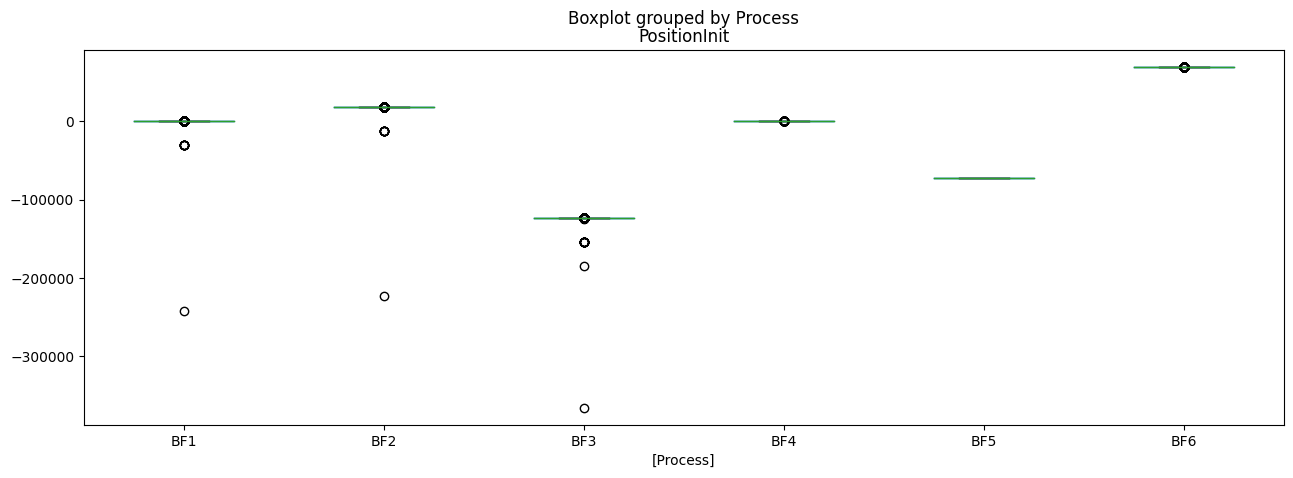

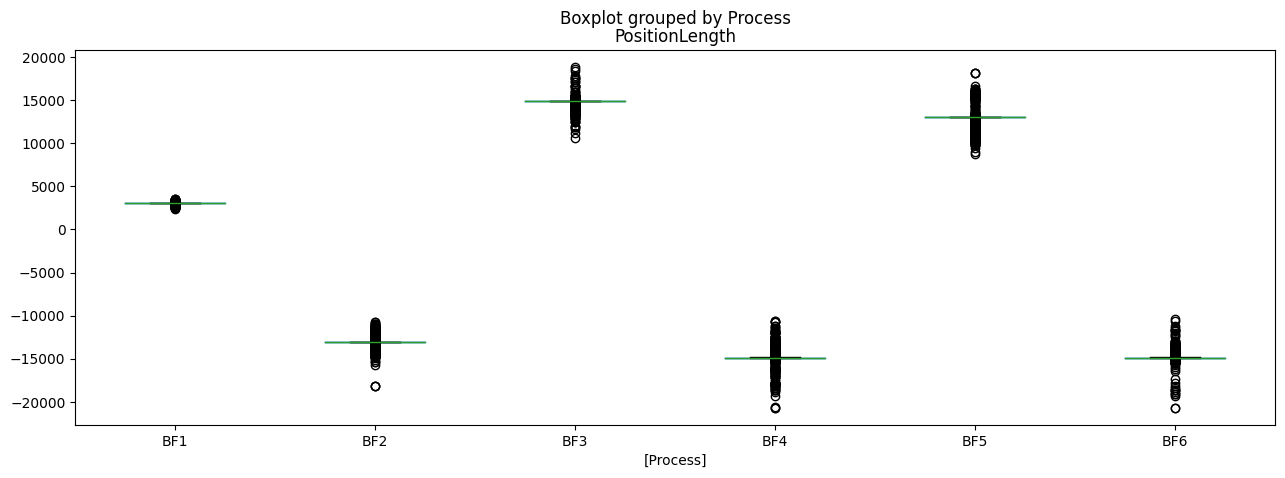

In [ ]:
positionData = ['PositionInit', 'PositionLength']
filtered_data = data[data['CurveProcess'] == 'acceleration']
for var in positionData:
  filtered_data.boxplot(by =['Process'], column=var, grid = False, figsize=(15,5))

We remove the outliers base on position, we consider just 1% for the outliers i.e. above 99th or below 1%

In [ ]:
processes = ['BF1', 'BF2', 'BF3', 'BF4', 'BF5', 'BF6' ]
columns = ['PositionInit','PositionLength']
for column in columns:
  print("\n\033[1mRemoving Outliers based on outliers at", column, "\033[0m")
  for process in processes:
    # Filter data by CurveProcess = 'acceleration' and Process = 'BF1'
    filtered_data = data[(data['CurveProcess'] == 'acceleration') & (data['Process'] == process)]

    # Calculate the 1st and 4th quarter values for column
    o1 = filtered_data[column].quantile(0.01)
    o4 = filtered_data[column].quantile(0.99)

    # Filter data to include only rows in the 1st or 4th quarter
    outliers = filtered_data[(filtered_data[column] <= o1) | (filtered_data[column] >= o4)]

    # Create a list of 'ID' values for the outliers
    outlier_ids = outliers['ID'].tolist()

    # Drop rows from the original 'data' DataFrame where 'ID' matches the outliers
    print("\n\033[1mRemoving Outliers from process:", process, "\033[0m")
    print ("IDs found as outliers based on the init length: ", len(outlier_ids) )
    print("Data shape before removing: ", data.shape)
    data = data[~data['ID'].isin(outlier_ids)]
    print("Data shape after removing: ", data.shape)


Removing Outliers based on outliers at PositionInit 

Removing Outliers from process: BF1 
IDs found as outliers based on the init length:  5811
Data shape before removing:  (4999986, 22)
Data shape after removing:  (4971384, 22)

Removing Outliers from process: BF2 
IDs found as outliers based on the init length:  5742
Data shape before removing:  (4971384, 22)
Data shape after removing:  (4942305, 22)

Removing Outliers from process: BF3 
IDs found as outliers based on the init length:  5613
Data shape before removing:  (4942305, 22)
Data shape after removing:  (4914183, 22)

Removing Outliers from process: BF4 
IDs found as outliers based on the init length:  6652
Data shape before removing:  (4914183, 22)
Data shape after removing:  (4883073, 22)

Removing Outliers from process: BF5 
IDs found as outliers based on the init length:  6029
Data shape before removing:  (4883073, 22)
Data shape after removing:  (4855362, 22)

Removing Outliers from process: BF6 
IDs found as outliers b

 acceleration 


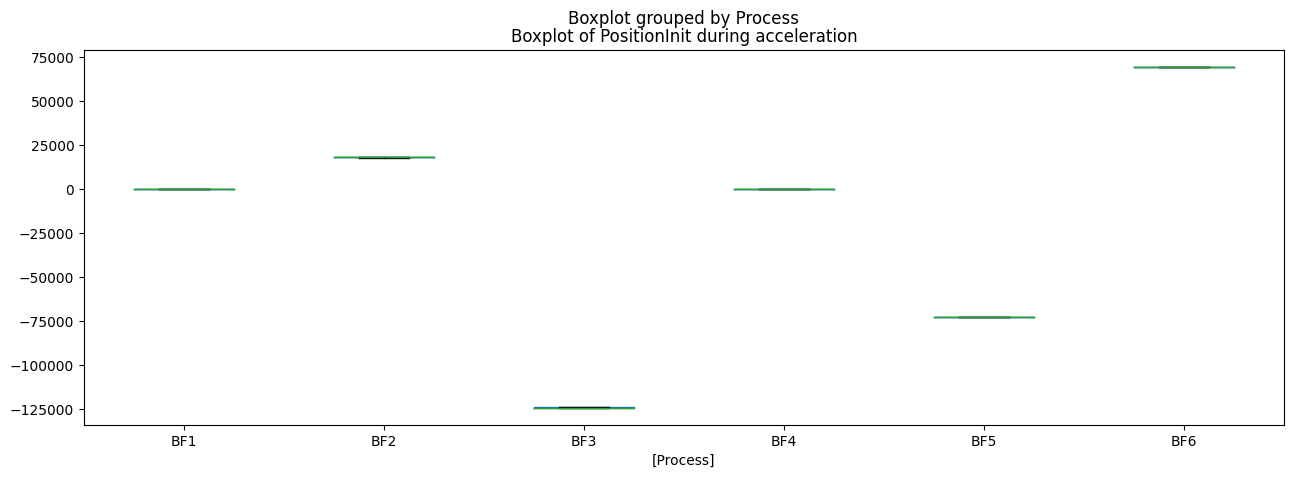

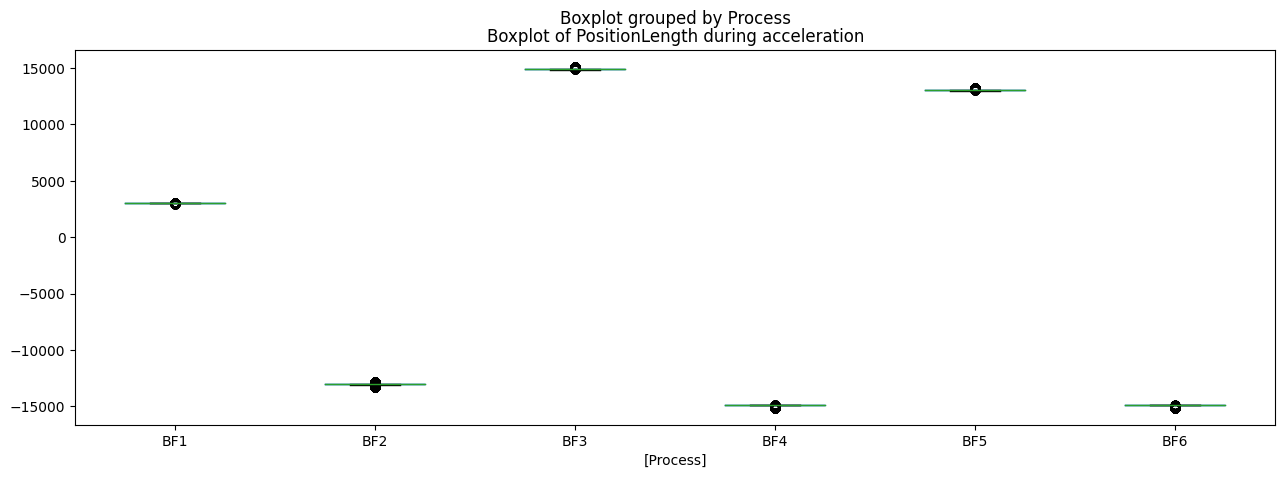

 top 


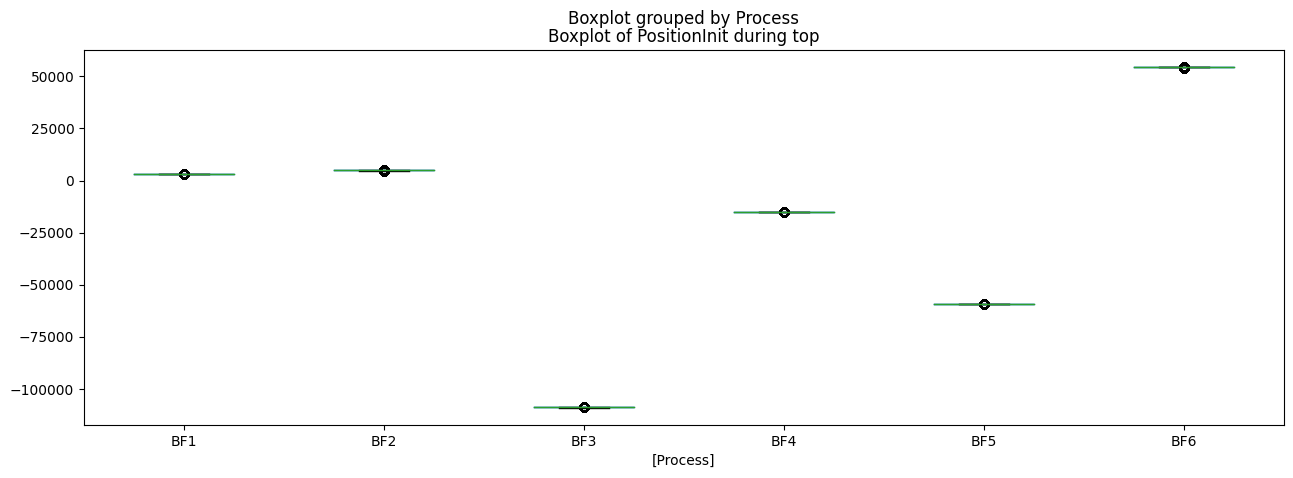

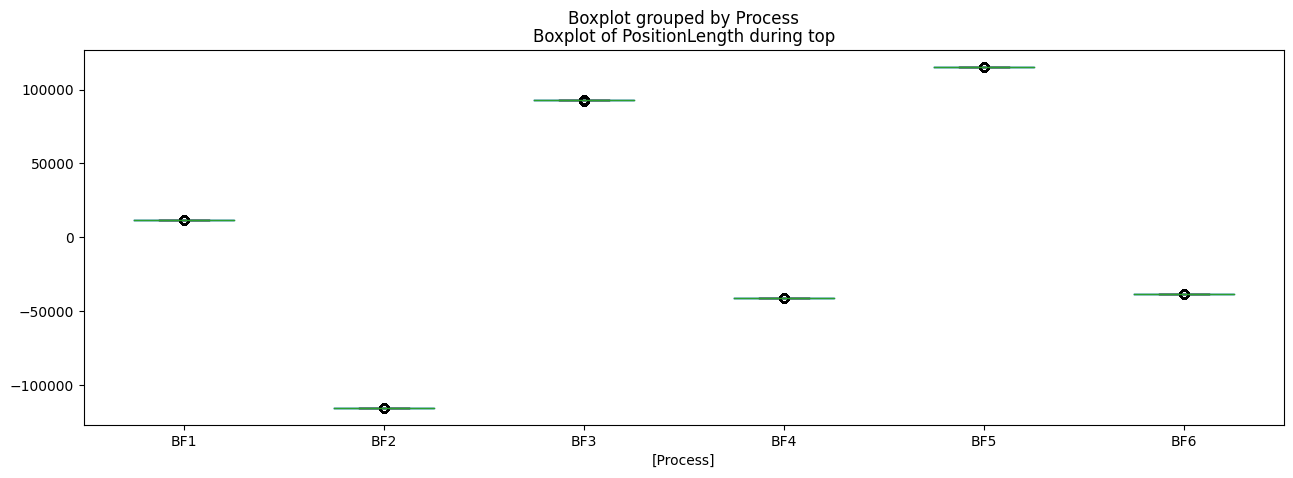

 decceleration 


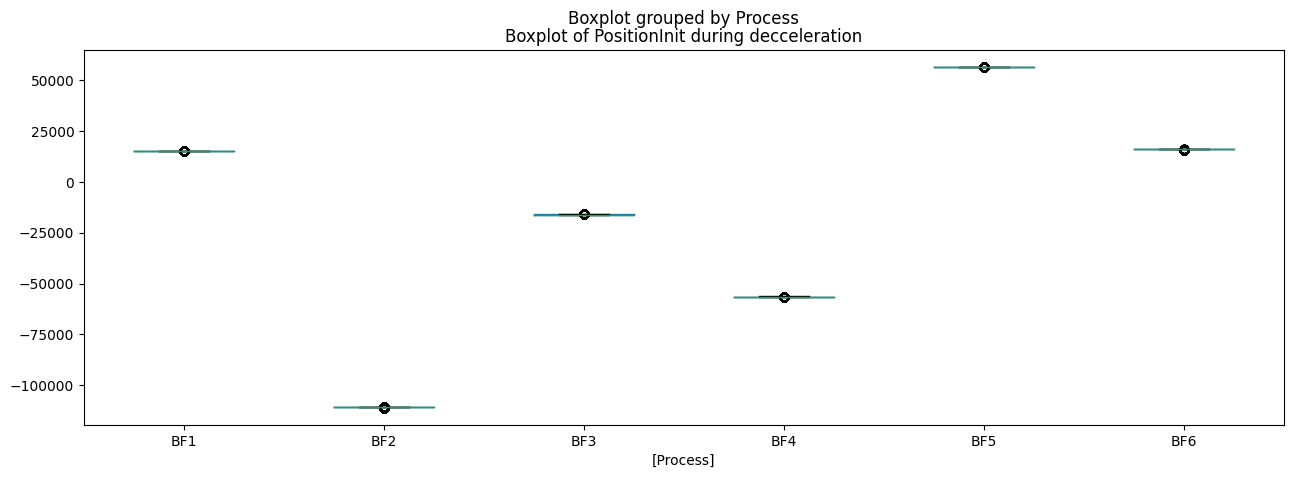

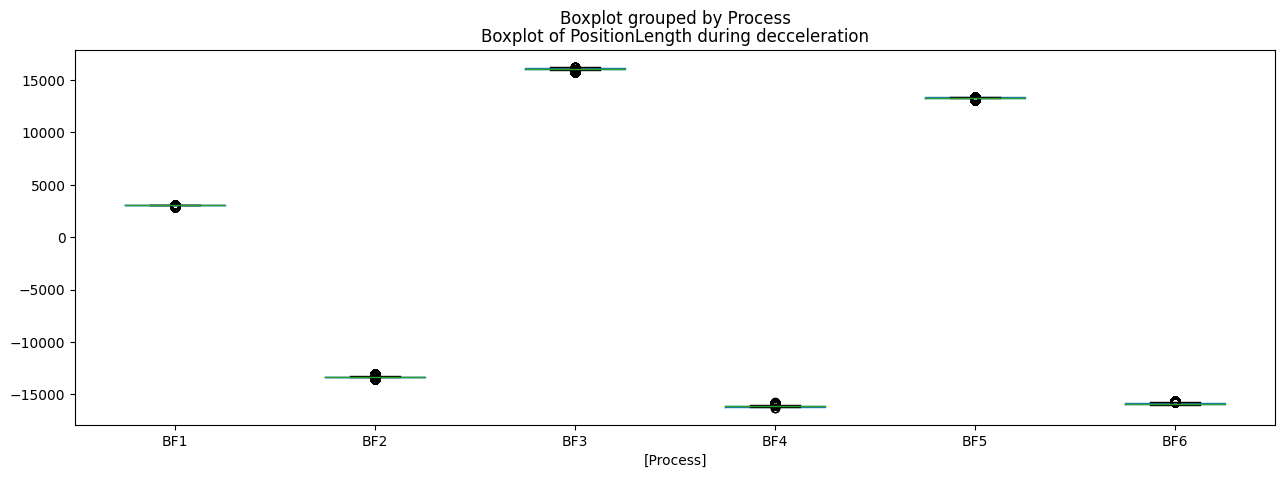

In [ ]:
curveProcesses = ['acceleration', 'top', 'decceleration']
positionData = ['PositionInit', 'PositionLength']
for curveProcess in curveProcesses:
  filtered_data = data[data['CurveProcess'] == curveProcess]
  print ("\033[1m", curveProcess, "\033[0m" )
  for var in positionData:
    filtered_data.boxplot(by =['Process'], column=var, grid = False, figsize=(15,5))
    plt.title('Boxplot of ' + var + ' during '+ curveProcess)

  plt.show()

In [ ]:
data.reset_index(drop=True, inplace=True)

### Correlation

<Axes: >

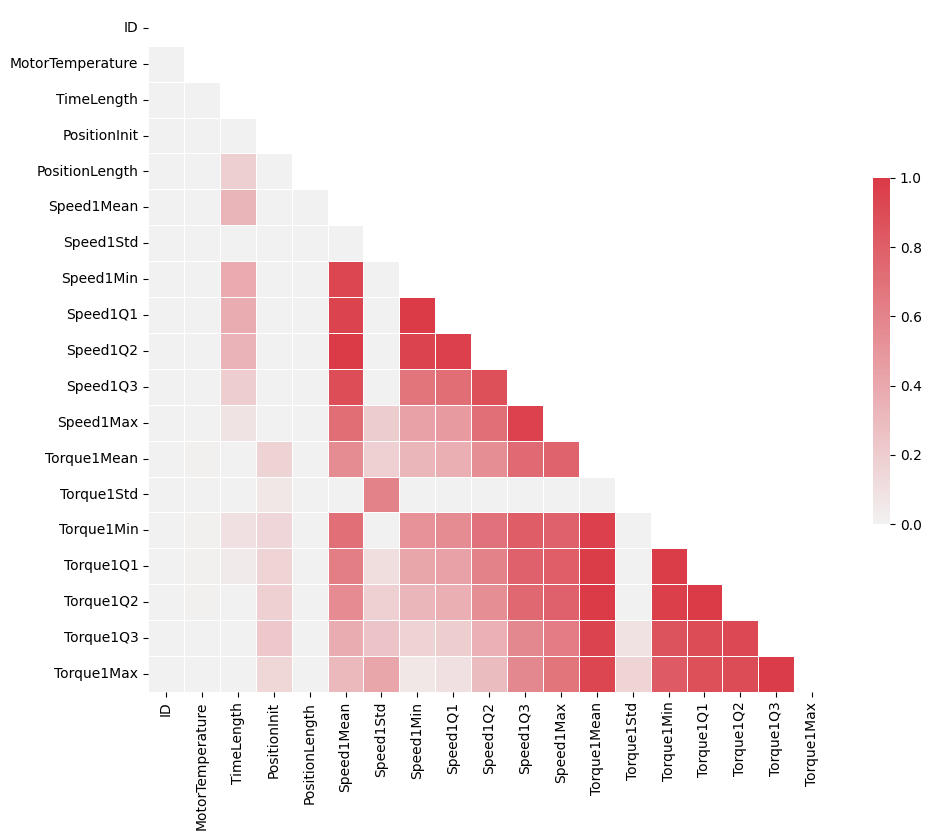

In [ ]:
data_corr = data.corr(numeric_only=True)

# Generate a mask for the upper triangle
data_mask = np.zeros_like(data_corr, dtype=bool)
data_mask[np.triu_indices_from(data_mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_corr, mask=data_mask, cmap=cmap, vmin=0, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can observe a high corralation among the speed variables and among the toques --> make sense!

In [ ]:
data.head()

ID  MotorTemperature Process   CurveProcess  TimeLength  PositionInit  \
0  638              28.8     BF4  decceleration         176        -56673   
1  638              28.8     BF4            top         187        -15291   
2  638              28.8     BF4   acceleration         150            17   
3  639              28.8     BF5            top         606        -59180   
4  640              28.8     BF6   acceleration         150         69627   

   PositionLength    Speed1Mean     Speed1Std  Speed1Min  ...  Speed1Q3  \
0          -15887  36868.310160    139.198899    36595.0  ...  36921.00   
1          -41162  36868.310160    139.198899    36595.0  ...  36921.00   
2          -15086  16593.513333  13020.848000        0.0  ...  29192.75   
3          115461  31800.496700    120.678807    31417.0  ...  31886.00   
4          -15080  16601.233333  13010.840585        0.0  ...  29081.50   

   Speed1Max  Torque1Mean  Torque1Std  Torque1Min  Torque1Q1  Torque1Q2  \
0    37487.0     1.723262    0.280134        1.04       1.52       1.76   
1    37487.0     1.723262    0.280134        1.04       1.52       1.76   
2    36977.0     1.965200    0.913576        0.03       1.65       2.20   
3    32249.0    -0.795875    0.095773       -1.35      -0.84      -0.77   
4    36774.0     1.794734    0.837885        0.03       1.52       1.92   

   Torque1Q3  Torque1Max            Datetime  
0     1.9600        2.30 2023-03-17 09:49:57  
1     1.9600        2.30 2023-03-17 09:49:57  
2     2.6400        3.14 2023-03-17 09:49:57  
3    -0.7400       -0.60 2023-03-17 09:49:58  
4     2.4225        3.08 2023-03-17 09:49:58  

[5 rows x 22 columns]

In [ ]:
columnsToDrop = ['ID']
for col in columnsToDrop:
  data = data.drop(col, axis=1)

## Transformation

### One Hot Encoding

In [ ]:
unique_processes = data['Process'].unique()
print(unique_processes)

['BF4' 'BF5' 'BF6' 'BF1' 'BF2' 'BF3']


In [ ]:
# Use pd.get_dummies to perform one-hot encoding
one_hot_encoded = pd.get_dummies(data['Process'], prefix='Process')

# Concatenate the one-hot encoded columns to the original DataFrame
data = pd.concat([data, one_hot_encoded], axis=1)

# Drop the original 'Process' column if needed
data = data.drop('Process', axis=1)

# Display the DataFrame with one-hot encoding
#data.head()

In [ ]:
data.columns

Index(['MotorTemperature', 'CurveProcess', 'TimeLength', 'PositionInit',
       'PositionLength', 'Speed1Mean', 'Speed1Std', 'Speed1Min', 'Speed1Q1',
       'Speed1Q2', 'Speed1Q3', 'Speed1Max', 'Torque1Mean', 'Torque1Std',
       'Torque1Min', 'Torque1Q1', 'Torque1Q2', 'Torque1Q3', 'Torque1Max',
       'Datetime', 'Process_BF1', 'Process_BF2', 'Process_BF3', 'Process_BF4',
       'Process_BF5', 'Process_BF6'],
      dtype='object')

In [ ]:
unique_curveProcesses = data['CurveProcess'].unique()
print(unique_curveProcesses)

['decceleration' 'top' 'acceleration']


In [ ]:
# Use pd.get_dummies to perform one-hot encoding
one_hot_encoded = pd.get_dummies(data['CurveProcess'], prefix='CurveProcess')

# Concatenate the one-hot encoded columns to the original DataFrame
data = pd.concat([data, one_hot_encoded], axis=1)

# Drop the original 'CurveProcess' column if needed
data = data.drop('CurveProcess', axis=1)

# Display the DataFrame with one-hot encoding
#data.head()

# 4.0. Restart point

In [ ]:
restartFromHere = True

if restartFromHere == False:
  data.to_csv('ProcessedData.csv', index=False)
else:
  files = ["ProcessedData.csv"]
  %cd /content/drive/MyDrive/VIU/14MBID/

  # Initialize an empty DataFrame
  data = pd.DataFrame()

  for file in files:
    df =  pd.read_csv(file)
    if data.empty:
      data = df
    else:
      data = pd.concat([data, df], ignore_index=True)

  data = data.sort_values('Datetime')
  # Reset the index for a new continuous index in the concatenated DataFrame
  data.reset_index(drop=True, inplace=True)



/content/drive/MyDrive/VIU/14MBID


In [ ]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
print(data.shape)
print(data.columns)
print(data.dtypes)
data.head()

(4658352, 28)
Index(['MotorTemperature', 'TimeLength', 'PositionInit', 'PositionLength',
       'Speed1Mean', 'Speed1Std', 'Speed1Min', 'Speed1Q1', 'Speed1Q2',
       'Speed1Q3', 'Speed1Max', 'Torque1Mean', 'Torque1Std', 'Torque1Min',
       'Torque1Q1', 'Torque1Q2', 'Torque1Q3', 'Torque1Max', 'Datetime',
       'Process_BF1', 'Process_BF2', 'Process_BF3', 'Process_BF4',
       'Process_BF5', 'Process_BF6', 'CurveProcess_acceleration',
       'CurveProcess_decceleration', 'CurveProcess_top'],
      dtype='object')
MotorTemperature                     float64
TimeLength                             int64
PositionInit                           int64
PositionLength                         int64
Speed1Mean                           float64
Speed1Std                            float64
Speed1Min                            float64
Speed1Q1                             float64
Speed1Q2                             float64
Speed1Q3                             float64
Speed1Max                     

MotorTemperature  TimeLength  PositionInit  PositionLength    Speed1Mean  \
0              28.8         176        -56673          -15887  36868.310160   
1              28.8         187        -15291          -41162  36868.310160   
2              28.8         150            17          -15086  16593.513333   
3              28.8         150        -72577           13204  14534.480000   
4              28.8         178         15823          -15740  36878.097701   

      Speed1Std  Speed1Min  Speed1Q1  Speed1Q2  Speed1Q3  ...  \
0    139.198899    36595.0  36780.00   36840.0  36921.00  ...   
1    139.198899    36595.0  36780.00   36840.0  36921.00  ...   
2  13020.848000        0.0   3586.75   15605.5  29192.75  ...   
3  11352.091406        0.0   2980.75   13664.0  25542.25  ...   
4    139.269717    36582.0  36773.00   36853.5  36945.25  ...   

             Datetime  Process_BF1  Process_BF2  Process_BF3  Process_BF4  \
0 2023-03-17 09:49:57            0            0            0            1   
1 2023-03-17 09:49:57            0            0            0            1   
2 2023-03-17 09:49:57            0            0            0            1   
3 2023-03-17 09:49:58            0            0            0            0   
4 2023-03-17 09:49:58            0            0            0            0   

   Process_BF5  Process_BF6  CurveProcess_acceleration  \
0            0            0                          0   
1            0            0                          0   
2            0            0                          1   
3            1            0                          1   
4            0            1                          0   

  CurveProcess_decceleration  CurveProcess_top  
0                          1                 0  
1                          0                 1  
2                          0                 0  
3                          0                 0  
4                          1                 0  

[5 rows x 28 columns]

# 4 Modeling - Predictions

## Temperature


### Random Forest for feature selection


Random Forest is known for its robustness with data so it is not really strictly necessary to have standardized data. In this case we will use RF to select the best features to then apply the different algorithms and predict.

The optimization process we follow is simple:
1.   Random Search with a wider range of parameters.
2.   Grid Search for a more thorough search on the best results obtained from the Random Search.





**Random Search**

In [ ]:
param_dist = {"n_estimators": [2, 4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_features": [1.0], # Auto, Number of features to consider at every split
              "max_depth": [None, 2, 4, 8, 16], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["absolute_error"]}


We work with **time series** data so instead of using a typical cross validation, we use one that takes into account the temporal relationship, in this case **window cross-validation**.

To get the same results we have to set the seed in random.seed, also in random_state and not use parallel processing with n_jobs=-1.

**Selection**
Only temperature of one curve

*   Only temperature of only one curve process coz it's the same for the three
*   Only every 60 cycles, each cycles 6 movements i.e. every 360 samples



In [ ]:
filtered_data = data[data['CurveProcess_top'] == 1]
filtered_data = filtered_data.drop(['Datetime'], axis=1)
print(filtered_data.shape)
filtered_data = filtered_data.iloc[::360]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

(1552784, 27)
(4314, 27)


In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor()

# Initialize the RandomizedSearchCV with time series split
rnd_regres = RandomizedSearchCV(estimator=regressor, param_distributions=param_dist, n_iter=10, cv=tscv, random_state=42, verbose=1) #n_jobs=1

# Fit the random search model
rnd_regres.fit(X=filtered_data.drop(['MotorTemperature'], axis=1), y=filtered_data['MotorTemperature'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['absolute_error'],
                                        'max_depth': [4, 16],
                                        'max_features': [1.0],
                                        'min_samples_leaf': [11, 9, 22],
                                        'min_samples_split': [25, 40, 3],
                                        'n_estimators': [32, 4, 16]},
                   random_state=42, verbose=1)

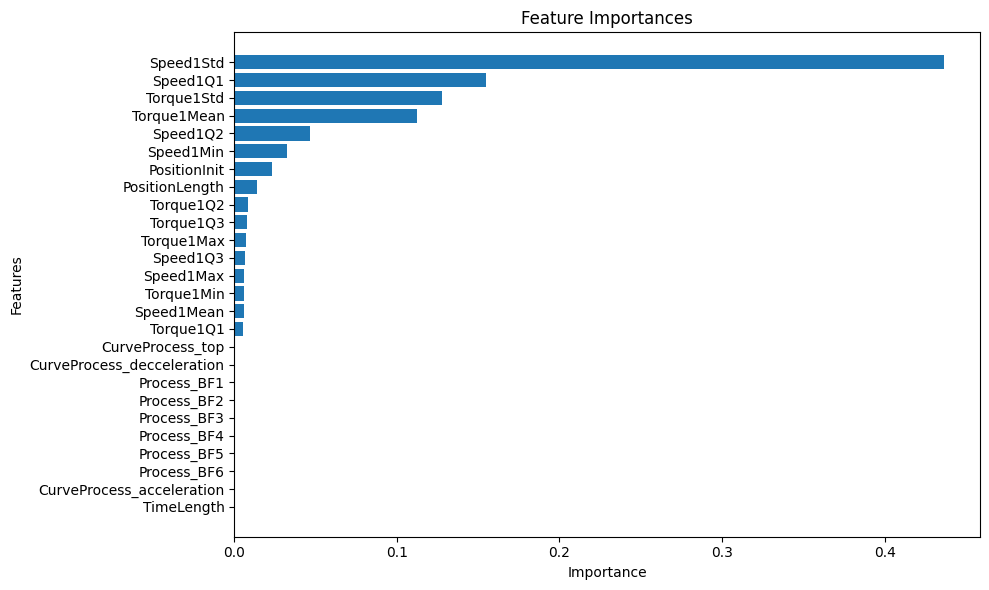

In [ ]:
best_model = rnd_regres.best_estimator_

# Get feature importances
importances = best_model.feature_importances_

# Create a list of feature names
feature_names = filtered_data.drop(['MotorTemperature'], axis=1).columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices][::-1], align='center')
plt.yticks(range(len(importances)), feature_names[indices][::-1])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()



Function to show the results of the n best models and their parameters.

In [ ]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(rnd_regres.cv_results_, 5)

Model with rank: 1
Mean validation score: -3.392 (std: 2.630)
Parameters: {'n_estimators': 16, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 1.0, 'max_depth': 16, 'criterion': 'absolute_error', 'bootstrap': True}

Model with rank: 2
Mean validation score: -4.553 (std: 4.091)
Parameters: {'n_estimators': 16, 'min_samples_split': 40, 'min_samples_leaf': 11, 'max_features': 1.0, 'max_depth': 16, 'criterion': 'absolute_error', 'bootstrap': True}

Model with rank: 3
Mean validation score: -5.487 (std: 4.598)
Parameters: {'n_estimators': 16, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 1.0, 'max_depth': 4, 'criterion': 'absolute_error', 'bootstrap': True}

Model with rank: 4
Mean validation score: -5.581 (std: 4.855)
Parameters: {'n_estimators': 16, 'min_samples_split': 40, 'min_samples_leaf': 11, 'max_features': 1.0, 'max_depth': 4, 'criterion': 'absolute_error', 'bootstrap': True}

Model with rank: 5
Mean validation score: -5.608 (std: 5.036)
Parameters: 

We'll tray to predict the last values of our timeseries.

In [ ]:
filtered_data.shape[0]

25880

### Random Forest for predictions

**Using the last 10% for test**

(1552784, 27)
(4314, 27)
431


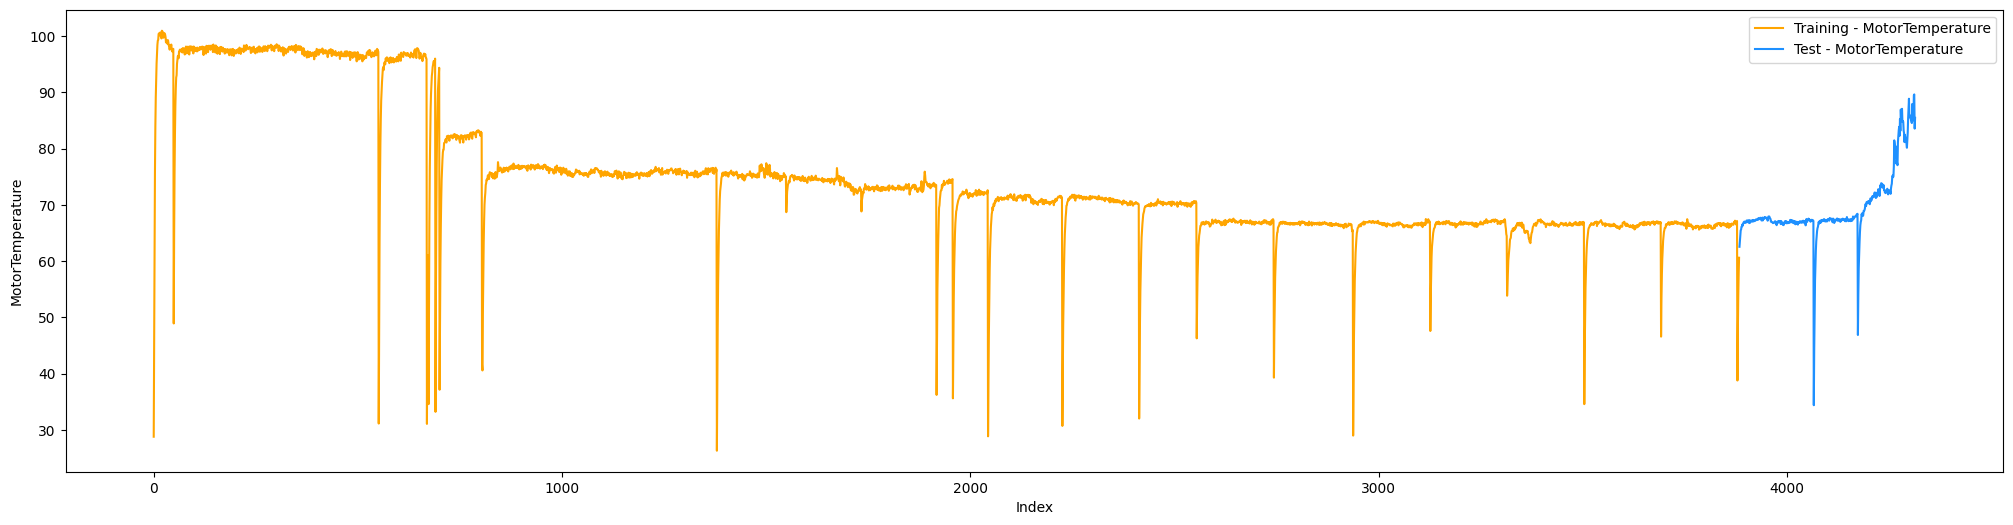

In [ ]:
filtered_data = data[data['CurveProcess_top'] == 1]
filtered_data = filtered_data.drop(['Datetime'], axis=1)
print(filtered_data.shape)
filtered_data = filtered_data.iloc[::360] #Every 10 cycles is around every minute
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

testSize = int(filtered_data.shape[0]*0.1) #Last N values coz it's time series
#testSize = 50
print(testSize)

plt.figure(figsize=(25, 6))
# Plot the 'MotorTemperature' column
plt.plot(filtered_data.index[:-testSize], filtered_data['MotorTemperature'][:-testSize], label='Training - MotorTemperature', color='orange')
plt.plot(filtered_data.index[-testSize:], filtered_data['MotorTemperature'][-testSize:], label='Test - MotorTemperature', color='dodgerblue')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()


Select the variables that have really importance based on the Random Forest

In [ ]:
print(filtered_data.shape)
filtered_data = filtered_data[['Speed1Std', 'Speed1Q1', 'Torque1Std', 'Torque1Mean', 'MotorTemperature']]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

# Split the data into training and test sets
training_data = filtered_data.iloc[:-testSize]
test_data = filtered_data.iloc[-testSize:]


print('Training: ', training_data.shape)
print('Test: ', test_data.shape)


(4314, 27)
(4314, 5)
Training:  (3883, 5)
Test:  (431, 5)


In [ ]:
param_dist = {
    'bootstrap': [True],
    'criterion': ['absolute_error'],
    'max_depth': [4, 16],
    'max_features': [1.0],
    'min_samples_leaf': [11, 9],
    'min_samples_split': [3, 40],
    'n_estimators': [32, 16]
}

In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor()

grid_regres = GridSearchCV(estimator=regressor, param_grid=param_dist, cv=tscv, verbose=1)

# Fit the grid search model
grid_regres.fit(X=training_data.drop(['MotorTemperature'], axis=1), y=training_data['MotorTemperature'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': [4, 16], 'max_features': [1.0],
                         'min_samples_leaf': [11, 9],
                         'min_samples_split': [3, 40],
                         'n_estimators': [32, 16]},
             verbose=1)

Show the best results after the grid search

In [ ]:
report(grid_regres.cv_results_, 5)

Model with rank: 1
Mean validation score: -4.161 (std: 2.837)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 32}

Model with rank: 2
Mean validation score: -4.176 (std: 2.798)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 16}

Model with rank: 3
Mean validation score: -4.239 (std: 2.974)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 11, 'min_samples_split': 3, 'n_estimators': 16}

Model with rank: 4
Mean validation score: -4.259 (std: 2.823)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 11, 'min_samples_split': 40, 'n_estimators': 32}

Model with rank: 5
Mean validation score: -4.267 (std: 2.805)
Parameters:

In [ ]:
# Get the best model from the optimization
best_model = grid_regres.best_estimator_

# Make predictions on the test_data
predictions = best_model.predict(test_data.drop(['MotorTemperature'], axis=1))

actual_values = test_data['MotorTemperature']

# Evaluate using MAE un MSE
mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(actual_values, predictions)
print("Mean Squared Error:", mse)

Mean Absolute Error: 3.09953596287703
Mean Squared Error: 28.924398734094034


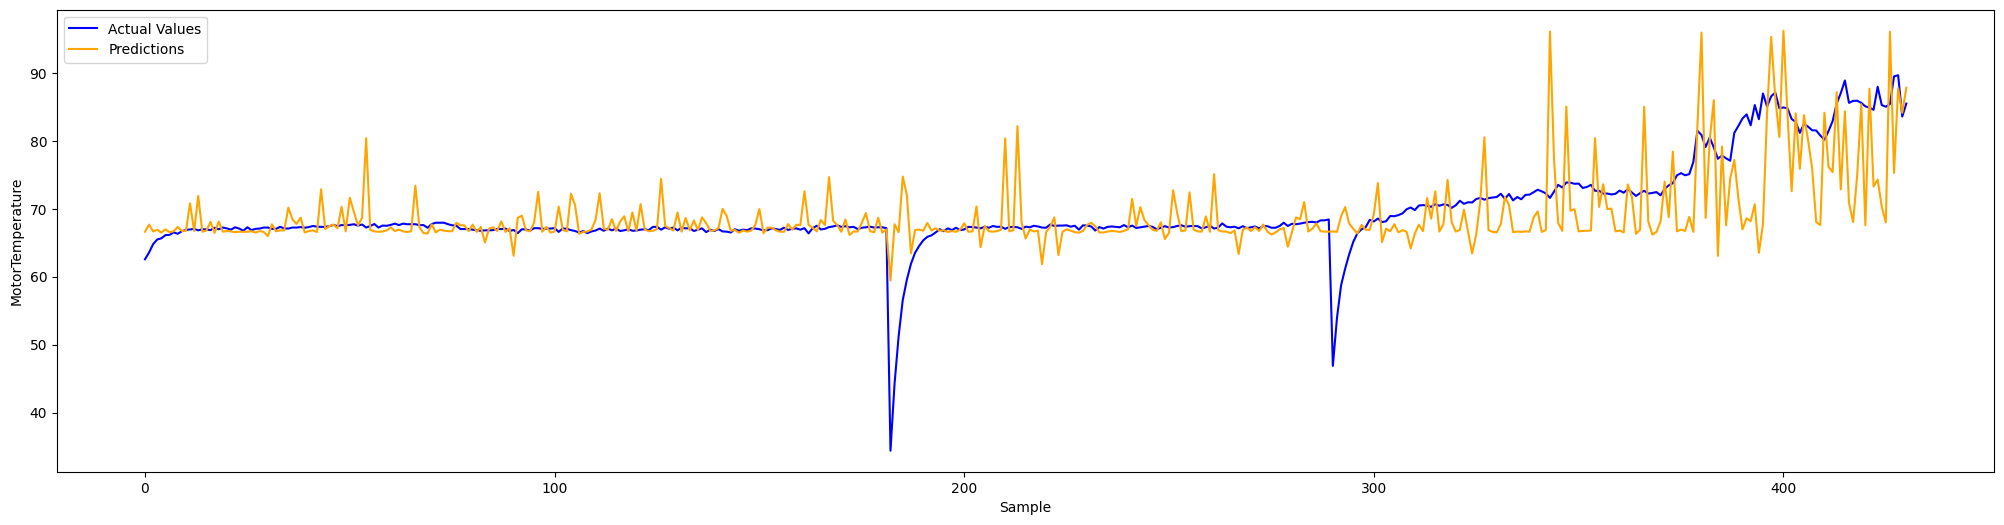

In [ ]:
# Create an array for the x-axis (you can use an index or a timestamp)
x_axis = range(len(actual_values))

plt.figure(figsize=(25, 6))
# Plot the actual values in blue and the predictions in red
plt.plot(x_axis, actual_values, label='Actual Values', color='blue')
plt.plot(x_axis, predictions, label='Predictions', color='orange')

# Add labels and legend
plt.xlabel('Sample')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()

**Using the last 2% for test**

(1552784, 27)
(4314, 27)
86


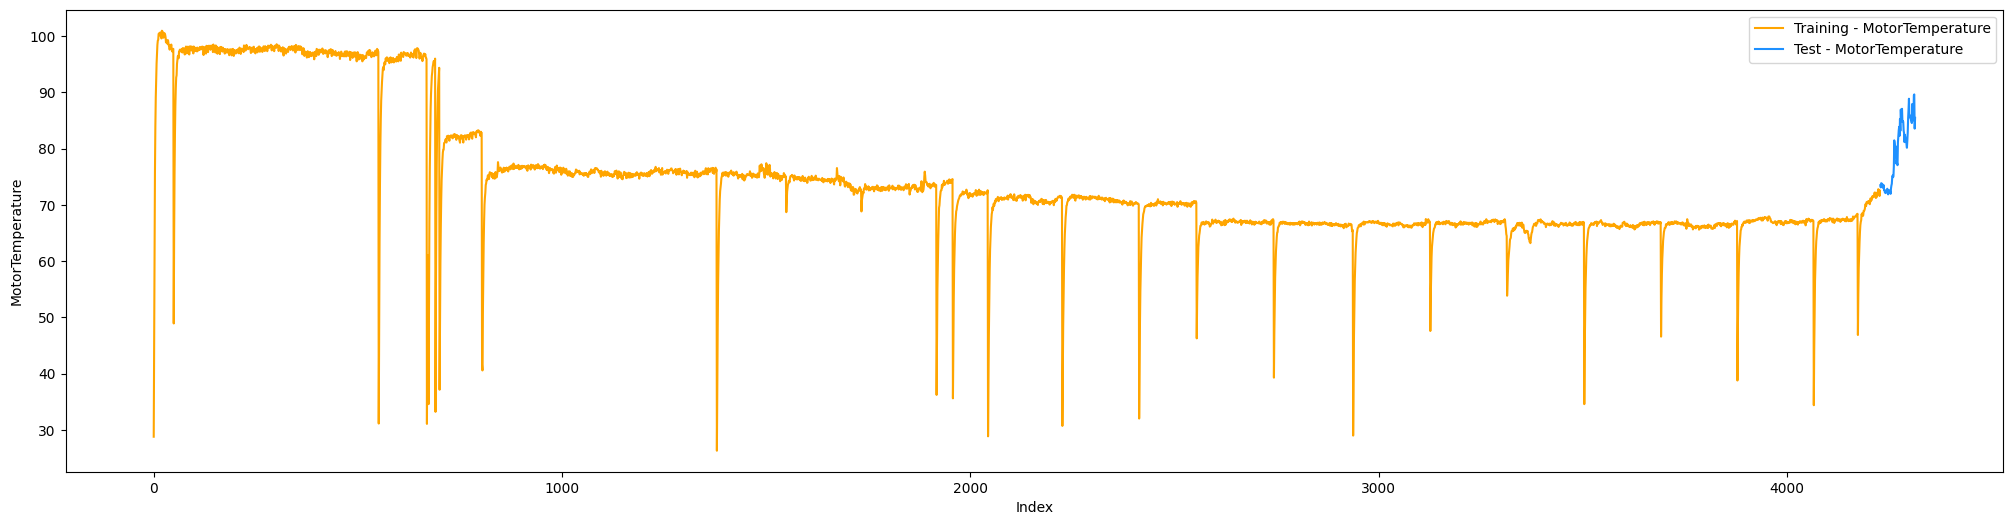

In [ ]:
filtered_data = data[data['CurveProcess_top'] == 1]
filtered_data = filtered_data.drop(['Datetime'], axis=1)
print(filtered_data.shape)
filtered_data = filtered_data.iloc[::360] #Every 10 cycles is around every minute
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

testSize = int(filtered_data.shape[0]*0.02) #Last N values coz it's time series
#testSize = 50
print(testSize)

plt.figure(figsize=(25, 6))
# Plot the 'MotorTemperature' column
plt.plot(filtered_data.index[:-testSize], filtered_data['MotorTemperature'][:-testSize], label='Training - MotorTemperature', color='orange')
plt.plot(filtered_data.index[-testSize:], filtered_data['MotorTemperature'][-testSize:], label='Test - MotorTemperature', color='dodgerblue')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()


Select the variables that have really importance based on the Random Forest

In [ ]:
print(filtered_data.shape)
filtered_data = filtered_data[['Speed1Std', 'Speed1Q1', 'Torque1Std', 'Torque1Mean', 'MotorTemperature']]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

# Split the data into training and test sets
training_data = filtered_data.iloc[:-testSize]
test_data = filtered_data.iloc[-testSize:]


print('Training: ', training_data.shape)
print('Test: ', test_data.shape)


(4314, 27)
(4314, 5)
Training:  (4228, 5)
Test:  (86, 5)


In [ ]:
param_dist = {
    'bootstrap': [True],
    'criterion': ['absolute_error'],
    'max_depth': [4, 16],
    'max_features': [1.0],
    'min_samples_leaf': [11, 9],
    'min_samples_split': [3, 40],
    'n_estimators': [32, 16]
}

In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor()

grid_regres = GridSearchCV(estimator=regressor, param_grid=param_dist, cv=tscv, verbose=1)

# Fit the grid search model
grid_regres.fit(X=training_data.drop(['MotorTemperature'], axis=1), y=training_data['MotorTemperature'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': [4, 16], 'max_features': [1.0],
                         'min_samples_leaf': [11, 9],
                         'min_samples_split': [3, 40],
                         'n_estimators': [32, 16]},
             verbose=1)

In [ ]:
# Get the best model from the optimization
best_model = grid_regres.best_estimator_

# Make predictions on the test_data
predictions = best_model.predict(test_data.drop(['MotorTemperature'], axis=1))

actual_values = test_data['MotorTemperature']

# Evaluate using MAE un MSE
mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(actual_values, predictions)
print("Mean Squared Error:", mse)

Mean Absolute Error: 7.614244186046514
Mean Squared Error: 83.27915462163882


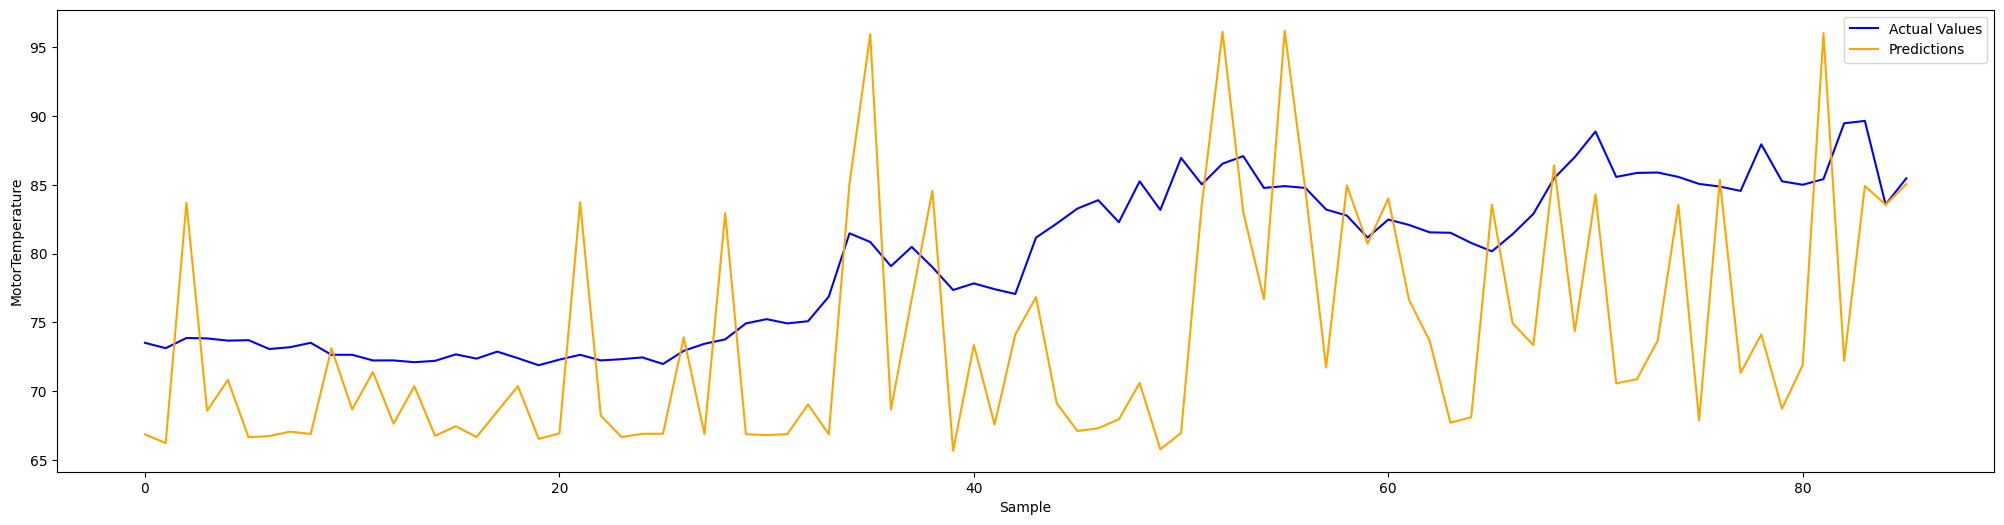

In [ ]:
# Create an array for the x-axis (you can use an index or a timestamp)
x_axis = range(len(actual_values))

plt.figure(figsize=(25, 6))
# Plot the actual values in blue and the predictions in red
plt.plot(x_axis, actual_values, label='Actual Values', color='blue')
plt.plot(x_axis, predictions, label='Predictions', color='orange')

# Add labels and legend
plt.xlabel('Sample')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()

### Lag features

In the context of time series forecasting, **lagged features** are used to capture dependencies between the current value and previous values in the sequence. When you create a lag 1 feature, it helps the model make predictions based on the immediate past, which is one time step earlier.

(1552784, 27)
(4314, 27)
431


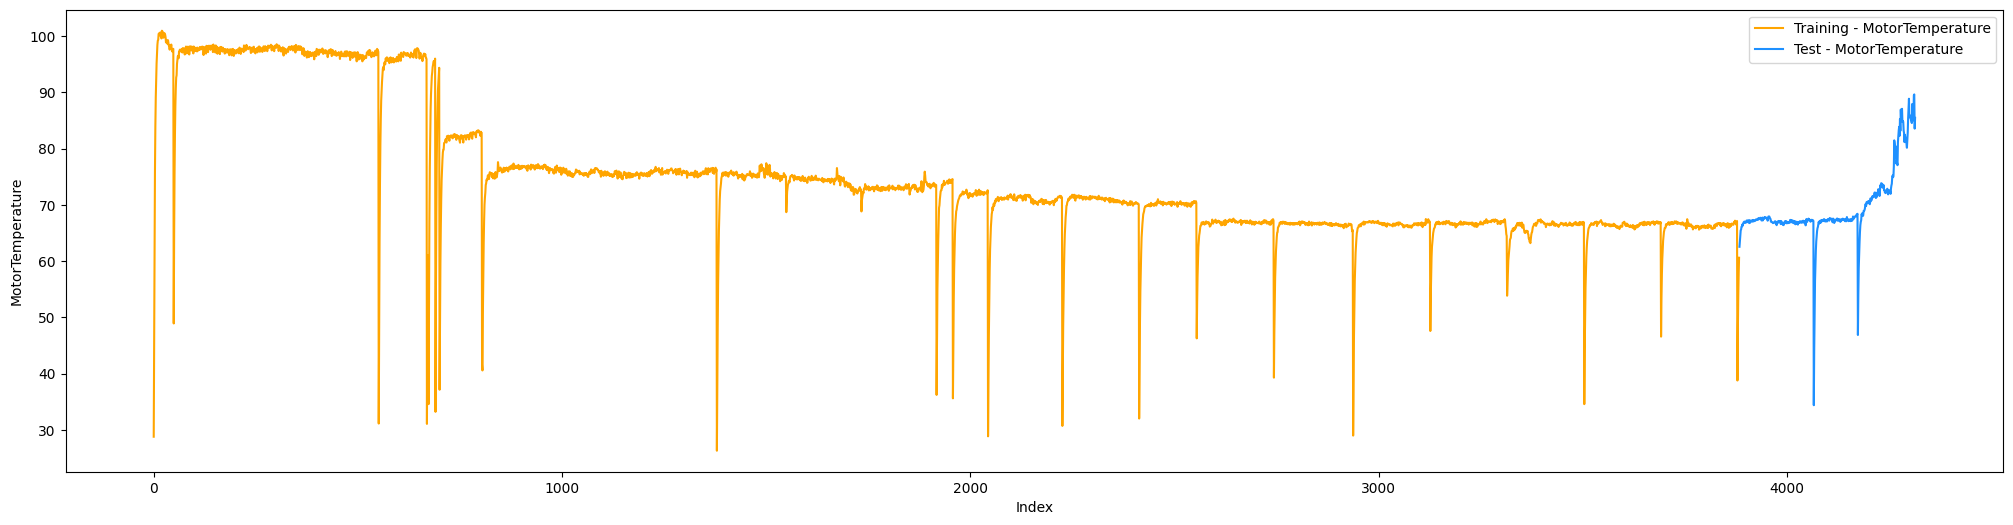

In [ ]:
filtered_data = data[data['CurveProcess_top'] == 1]
filtered_data = filtered_data.drop(['Datetime'], axis=1)
print(filtered_data.shape)
filtered_data = filtered_data.iloc[::360] #Every 10 cycles is around every minute
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

testSize = int(filtered_data.shape[0]*0.1) #Last N values coz it's time series
#testSize = 50
print(testSize)

plt.figure(figsize=(25, 6))
# Plot the 'MotorTemperature' column
plt.plot(filtered_data.index[:-testSize], filtered_data['MotorTemperature'][:-testSize], label='Training - MotorTemperature', color='orange')
plt.plot(filtered_data.index[-testSize:], filtered_data['MotorTemperature'][-testSize:], label='Test - MotorTemperature', color='dodgerblue')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()


On the y axis is the autocorrelation. The x axis tells you the lag. It means:
 ,

*   if x=1 we are looking at the correlation of the valu *n* with the value *n-1*
*  If x=2, we have a lag of 2 and we are looking at the correlation of *n* with the value *n-2*,etc.



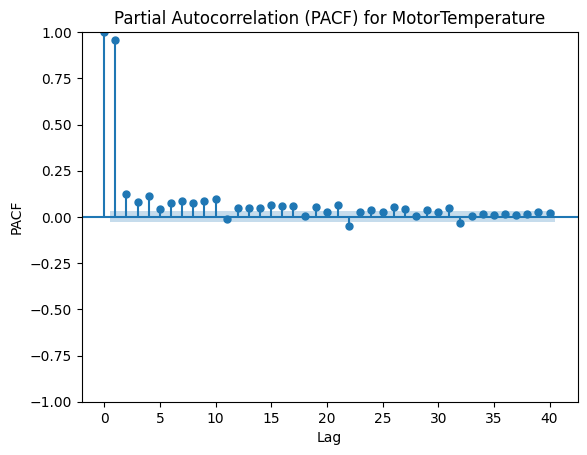

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf


# Plot the PACF (Partial Autocorrelation Function)
plot_pacf(filtered_data['MotorTemperature'], lags=40)
plt.title('Partial Autocorrelation (PACF) for MotorTemperature')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()


We consider **1 lag**

In [ ]:
print(filtered_data.shape)
filtered_data = filtered_data[['MotorTemperature']]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)


# Create lag features
lag = 1
filtered_data['MotorTemperature_Lag1'] = filtered_data['MotorTemperature'].shift(lag)
filtered_data['MotorTemperature_Lag1'].iloc[0] = filtered_data['MotorTemperature_Lag1'].iloc[1] # Delete NAN


# Split the data into training and test sets
training_data = filtered_data.iloc[:-testSize]
test_data = filtered_data.iloc[-testSize:]


print('Training: ', training_data.shape)
print('Test: ', test_data.shape)


(4314, 2)
(4314, 1)
Training:  (3883, 2)
Test:  (431, 2)


In [ ]:
filtered_data.head()

MotorTemperature  MotorTemperature_Lag1
0             28.80                  28.80
1             45.67                  28.80
2             63.39                  45.67
3             75.72                  63.39
4             83.88                  75.72

We verify the values for the lag correspond to the past to avoid data leakage --> Correct!

In [ ]:
param_dist = {
    'bootstrap': [True],
    'criterion': ['absolute_error'],
    'max_depth': [4, 16],
    'max_features': [1.0],
    'min_samples_leaf': [11, 9],
    'min_samples_split': [3, 40],
    'n_estimators': [32, 16]
}

In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor(n_estimators=32, random_state=42)

grid_regres = GridSearchCV(estimator=regressor, param_grid=param_dist, cv=tscv, verbose=1)

# Fit the grid search model
grid_regres.fit(X=training_data.drop(['MotorTemperature'], axis=1), y=training_data['MotorTemperature']) #Training with 'MotorTemperature_Lag1'

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_estimators=32, random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': [4, 16], 'max_features': [1.0],
                         'min_samples_leaf': [11, 9],
                         'min_samples_split': [3, 40],
                         'n_estimators': [32, 16]},
             verbose=1)

Show the best results after the grid search

In [ ]:
report(grid_regres.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.404 (std: 0.054)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 32}

Model with rank: 2
Mean validation score: 0.401 (std: 0.062)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 16}

Model with rank: 3
Mean validation score: 0.388 (std: 0.050)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 32}

Model with rank: 4
Mean validation score: 0.382 (std: 0.059)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 16}

Model with rank: 5
Mean validation score: 0.314 (std: 0.206)
Parameters: {'boo

In [ ]:
# Get the best model from the optimization
best_model = grid_regres.best_estimator_

# Make predictions on the test_data
predictions = best_model.predict(test_data.drop(['MotorTemperature'], axis=1))

actual_values = test_data['MotorTemperature']

# Evaluate using MAE un MSE
mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(actual_values, predictions)
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.9455300174013942
Mean Squared Error: 6.688523458572023


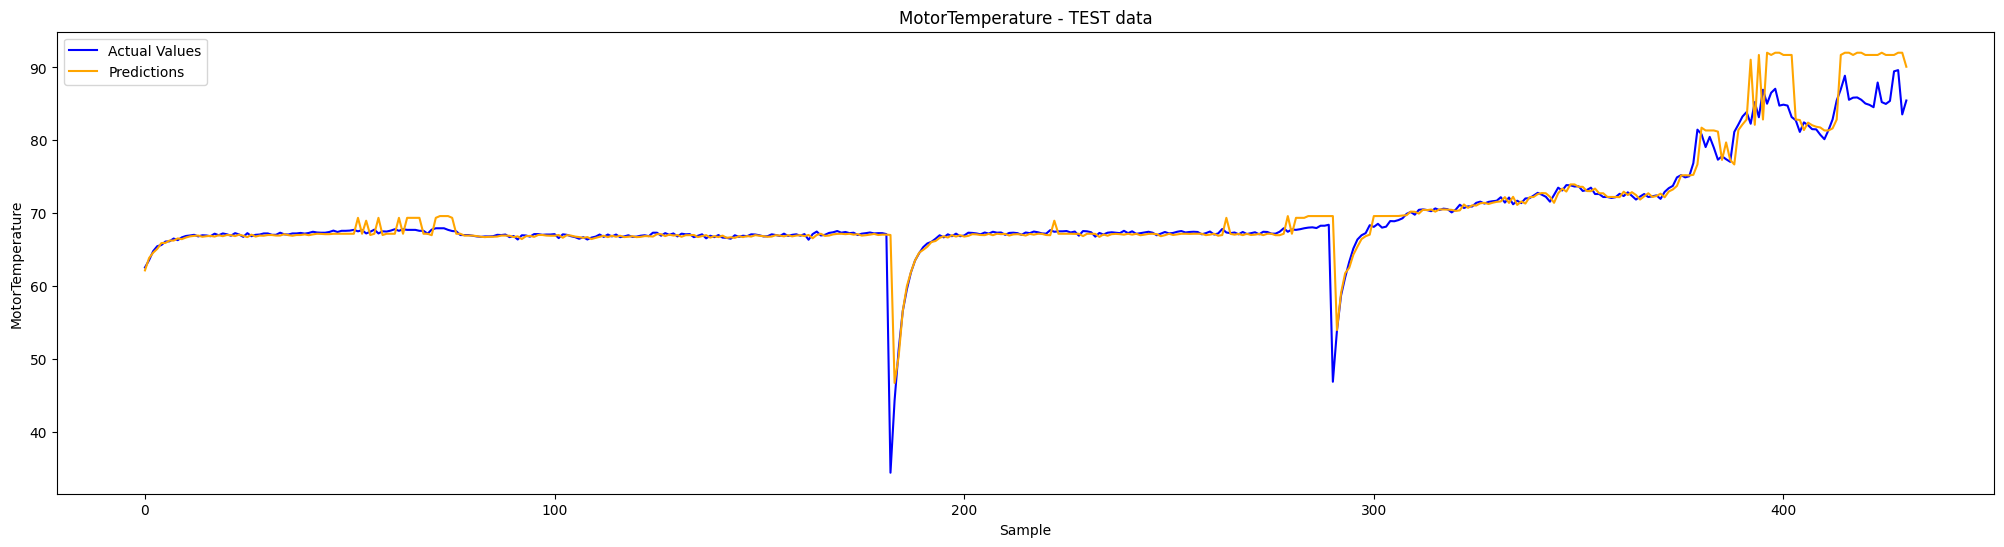

In [ ]:
# Create an array for the x-axis (you can use an index or a timestamp)
x_axis = range(len(actual_values))

plt.figure(figsize=(25, 6))
# Plot the actual values in blue and the predictions in red
plt.plot(x_axis, actual_values, label='Actual Values', color='blue')
plt.plot(x_axis, predictions, label='Predictions', color='orange')

# Add labels, title and legend
plt.title('MotorTemperature - TEST data')
plt.xlabel('Sample')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()

**Finding**
We're able to predict the temperature based on its value

**2 Lags**

In [ ]:
filtered_data = data[data['CurveProcess_top'] == 1]
filtered_data = filtered_data.drop(['Datetime'], axis=1)
print(filtered_data.shape)
filtered_data = filtered_data.iloc[::360] #Every 10 cycles is around every minute
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

testSize = int(filtered_data.shape[0]*0.1) #Last N values coz it's time series
#testSize = 50
print(testSize)

(1552784, 27)
(4314, 27)
431


In [ ]:
print(filtered_data.shape)
filtered_data = filtered_data[['MotorTemperature']]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)


# Create lag features
lag = 1
lag2 = 2
filtered_data['MotorTemperature_Lag1'] = filtered_data['MotorTemperature'].shift(lag)
filtered_data['MotorTemperature_Lag2'] = filtered_data['MotorTemperature'].shift(lag2)
filtered_data['MotorTemperature_Lag1'].iloc[0] = filtered_data['MotorTemperature_Lag1'].iloc[1] # Handle NAN
filtered_data['MotorTemperature_Lag2'].iloc[0] = filtered_data['MotorTemperature_Lag2'].iloc[2] # Handle NAN
filtered_data['MotorTemperature_Lag2'].iloc[1] = filtered_data['MotorTemperature_Lag2'].iloc[2] # Handle NAN

# Split the data into training and test sets
training_data = filtered_data.iloc[:-testSize]
test_data = filtered_data.iloc[-testSize:]


print('Training: ', training_data.shape)
print('Test: ', test_data.shape)


(4314, 27)
(4314, 1)
Training:  (3883, 3)
Test:  (431, 3)


<ipython-input-73-a1fcfa99ea08>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['MotorTemperature_Lag1'] = filtered_data['MotorTemperature'].shift(lag)
<ipython-input-73-a1fcfa99ea08>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['MotorTemperature_Lag2'] = filtered_data['MotorTemperature'].shift(lag2)
<ipython-input-73-a1fcfa99ea08>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [ ]:
filtered_data.head()

MotorTemperature  MotorTemperature_Lag1  MotorTemperature_Lag2
0             28.80                  28.80                  28.80
1             45.67                  28.80                  28.80
2             63.39                  45.67                  28.80
3             75.72                  63.39                  45.67
4             83.88                  75.72                  63.39

We verify the values for the lags correspond to the past to avoid data leackage --> Correct!

In [ ]:
param_dist = {
    'bootstrap': [True],
    'criterion': ['absolute_error'],
    'max_depth': [4, 16],
    'max_features': [1.0],
    'min_samples_leaf': [11, 9],
    'min_samples_split': [3, 40],
    'n_estimators': [32, 16]
}

In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor(n_estimators=32, random_state=42)

grid_regres = GridSearchCV(estimator=regressor, param_grid=param_dist, cv=tscv, verbose=1)

# Fit the grid search model
grid_regres.fit(X=training_data.drop(['MotorTemperature'], axis=1), y=training_data['MotorTemperature']) #Training with 'MotorTemperature_Lag1' and Lag2

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_estimators=32, random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': [4, 16], 'max_features': [1.0],
                         'min_samples_leaf': [11, 9],
                         'min_samples_split': [3, 40],
                         'n_estimators': [32, 16]},
             verbose=1)

Show the best results after the grid search

In [ ]:
report(grid_regres.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.404 (std: 0.053)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 32}

Model with rank: 2
Mean validation score: 0.398 (std: 0.060)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 16}

Model with rank: 3
Mean validation score: 0.389 (std: 0.051)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 32}

Model with rank: 4
Mean validation score: 0.382 (std: 0.060)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 16}

Model with rank: 5
Mean validation score: 0.315 (std: 0.210)
Parameters: {'boo

In [ ]:
# Get the best model from the optimization
best_model = grid_regres.best_estimator_

# Make predictions on the test_data
predictions = best_model.predict(test_data.drop(['MotorTemperature'], axis=1))

actual_values = test_data['MotorTemperature']

# Evaluate using MAE un MSE
mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(actual_values, predictions)
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.9115650377030187
Mean Squared Error: 6.624212049840964


Comparing the result, we have slightly improve it, from:

*   MAE: 0.9455 --> 0.9115
*   MSE: 6.6885 --> 6.6242



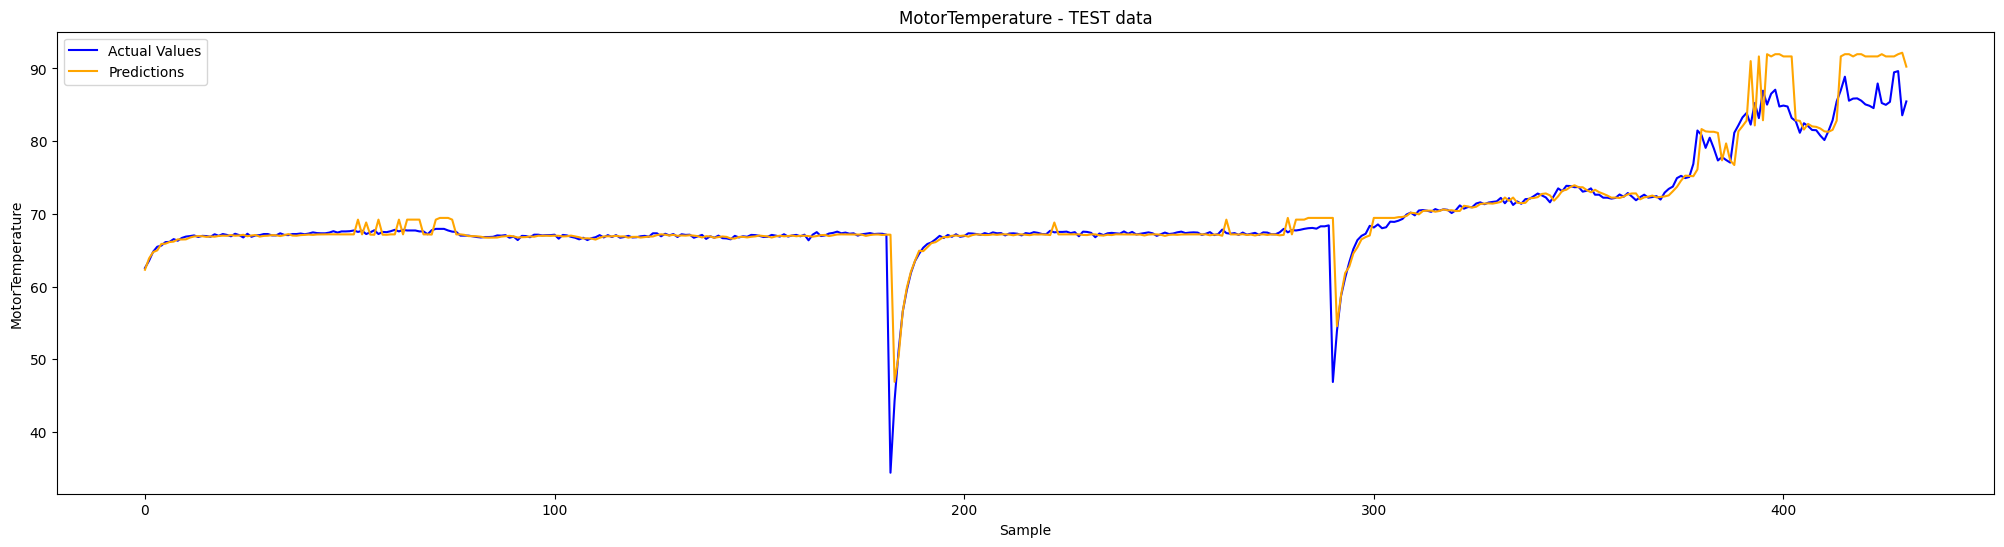

In [ ]:
# Create an array for the x-axis (you can use an index or a timestamp)
x_axis = range(len(actual_values))

plt.figure(figsize=(25, 6))
# Plot the actual values in blue and the predictions in red
plt.plot(x_axis, actual_values, label='Actual Values', color='blue')
plt.plot(x_axis, predictions, label='Predictions', color='orange')

# Add labels, title and legend
plt.title('MotorTemperature - TEST data')
plt.xlabel('Sample')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()

**2 Lags & important feautures**

In [ ]:
filtered_data = data[data['CurveProcess_top'] == 1]
filtered_data = filtered_data.drop(['Datetime'], axis=1)
print(filtered_data.shape)
filtered_data = filtered_data.iloc[::360] #Every 10 cycles is around every minute
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

testSize = int(filtered_data.shape[0]*0.1) #Last N values coz it's time series
#testSize = 50
print(testSize)

(1552784, 27)
(4314, 27)
431


In [ ]:
print(filtered_data.shape)
filtered_data = filtered_data[['Speed1Std', 'Speed1Q1', 'Torque1Std', 'Torque1Mean', 'MotorTemperature']]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)


# Create lag features
lag = 1
lag2 = 2
filtered_data['MotorTemperature_Lag1'] = filtered_data['MotorTemperature'].shift(lag)
filtered_data['MotorTemperature_Lag2'] = filtered_data['MotorTemperature'].shift(lag2)
filtered_data['MotorTemperature_Lag1'].iloc[0] = filtered_data['MotorTemperature_Lag1'].iloc[1] # Handle NAN
filtered_data['MotorTemperature_Lag2'].iloc[0] = filtered_data['MotorTemperature_Lag2'].iloc[2] # Handle NAN
filtered_data['MotorTemperature_Lag2'].iloc[1] = filtered_data['MotorTemperature_Lag2'].iloc[2] # Handle NAN

# Split the data into training and test sets
training_data = filtered_data.iloc[:-testSize]
test_data = filtered_data.iloc[-testSize:]


print('Training: ', training_data.shape)
print('Test: ', test_data.shape)


(4314, 27)
(4314, 5)
Training:  (3883, 7)
Test:  (431, 7)


<ipython-input-81-63cea1a745c9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['MotorTemperature_Lag1'] = filtered_data['MotorTemperature'].shift(lag)
<ipython-input-81-63cea1a745c9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['MotorTemperature_Lag2'] = filtered_data['MotorTemperature'].shift(lag2)
<ipython-input-81-63cea1a745c9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [ ]:
filtered_data.head()

Speed1Std  Speed1Q1  Torque1Std  Torque1Mean  MotorTemperature  \
0  139.198899  36780.00    0.280134     1.723262             28.80   
1  115.267359  31713.00    0.137671     0.814703             45.67   
2  118.337361  36769.00    0.218364    -1.163262             63.39   
3  144.334125  36778.25    0.232129     1.281552             75.72   
4  119.504135  31717.00    0.094645    -0.803020             83.88   

   MotorTemperature_Lag1  MotorTemperature_Lag2  
0                  28.80                  28.80  
1                  28.80                  28.80  
2                  45.67                  28.80  
3                  63.39                  45.67  
4                  75.72                  63.39

We verify the values for the lags correspond to the past to avoid data leackage --> Correct!

In [ ]:
param_dist = {
    'bootstrap': [True],
    'criterion': ['absolute_error'],
    'max_depth': [4, 16],
    'max_features': [1.0],
    'min_samples_leaf': [11, 9],
    'min_samples_split': [3, 40],
    'n_estimators': [32, 16]
}

In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor(n_estimators=32, random_state=42)

grid_regres = GridSearchCV(estimator=regressor, param_grid=param_dist, cv=tscv, verbose=1)

# Fit the grid search model
grid_regres.fit(X=training_data.drop(['MotorTemperature'], axis=1), y=training_data['MotorTemperature']) #Training with 'MotorTemperature_Lag1' and Lag2

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_estimators=32, random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': [4, 16], 'max_features': [1.0],
                         'min_samples_leaf': [11, 9],
                         'min_samples_split': [3, 40],
                         'n_estimators': [32, 16]},
             verbose=1)

Show the best results after the grid search

In [ ]:
report(grid_regres.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.399 (std: 0.051)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 32}

Model with rank: 2
Mean validation score: 0.396 (std: 0.060)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 16}

Model with rank: 3
Mean validation score: 0.383 (std: 0.050)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 32}

Model with rank: 4
Mean validation score: 0.375 (std: 0.062)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 16}

Model with rank: 5
Mean validation score: 0.311 (std: 0.207)
Parameters: {'boo

In [ ]:
# Get the best model from the optimization
best_model = grid_regres.best_estimator_

# Make predictions on the test_data
predictions = best_model.predict(test_data.drop(['MotorTemperature'], axis=1))

actual_values = test_data['MotorTemperature']

# Evaluate using MAE un MSE
mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(actual_values, predictions)
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.9348259860788909
Mean Squared Error: 6.740543252202382


Comparing the result, we have worse the results, from:

*   MAE: 0.9455 --> 0.9115 --> 0.9348
*   MSE: 6.6885 --> 6.6242 --> 6.7405



In [ ]:
# Create an empty DataFrame with columns
data2 = {'Algorithm': [],
        'Method': [],
        'MAE': [],
        'MSE': []}

results = pd.DataFrame(data2)

# Add a row of data
row1 = pd.DataFrame({'Algorithm': ['Random Forest'],
                         'Method': ['GridSearchCV + Flag 1'],
                         'MAE': [0.9455],
                         'MSE': [6.6885]})

row2 = pd.DataFrame({'Algorithm': ['Random Forest'],
                         'Method': ['GridSearchCV + Flag 1&2'],
                         'MAE': [0.9115],
                         'MSE': [6.6242]})

row3 = pd.DataFrame({'Algorithm': ['Random Forest'],
                         'Method': ['GridSearchCV + Flag 1&2 & Features'],
                         'MAE': [0.9348],
                         'MSE': [6.7405]})


results = pd.concat([results, row1], ignore_index=True)
results = pd.concat([results, row2], ignore_index=True)
results = pd.concat([results, row3], ignore_index=True)

# Print the DataFrame
print(results)

       Algorithm                              Method     MAE     MSE
0  Random Forest               GridSearchCV + Flag 1  0.9455  6.6885
1  Random Forest             GridSearchCV + Flag 1&2  0.9115  6.6242
2  Random Forest  GridSearchCV + Flag 1&2 & Features  0.9348  6.7405


In [ ]:
data

{'Algorithm': [], 'Method': [], 'MAE': [], 'MSE': []}

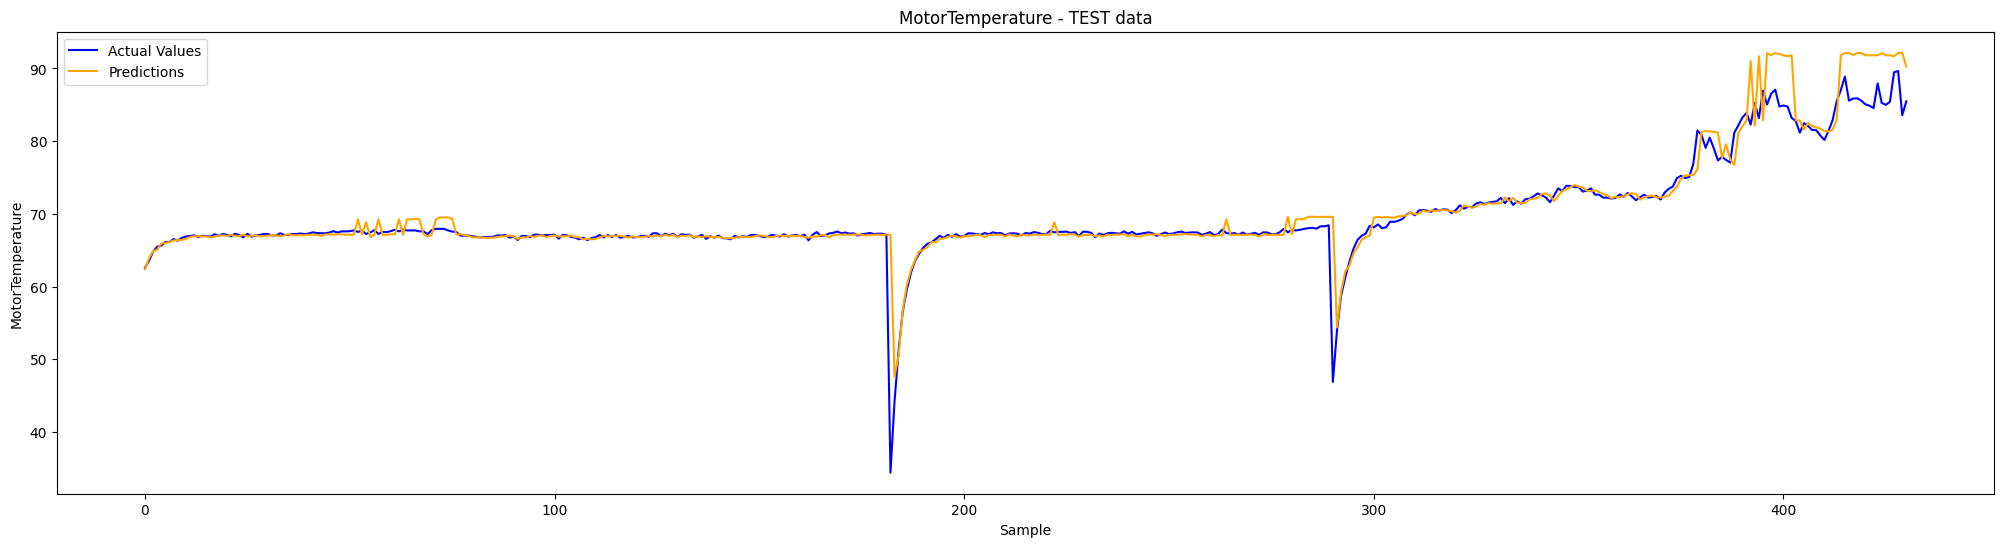

In [ ]:
# Create an array for the x-axis (you can use an index or a timestamp)
x_axis = range(len(actual_values))

plt.figure(figsize=(25, 6))
# Plot the actual values in blue and the predictions in red
plt.plot(x_axis, actual_values, label='Actual Values', color='blue')
plt.plot(x_axis, predictions, label='Predictions', color='orange')

# Add labels, title and legend
plt.title('MotorTemperature - TEST data')
plt.xlabel('Sample')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()

### LSTM

(1552784, 27)
(25880, 27)
2588


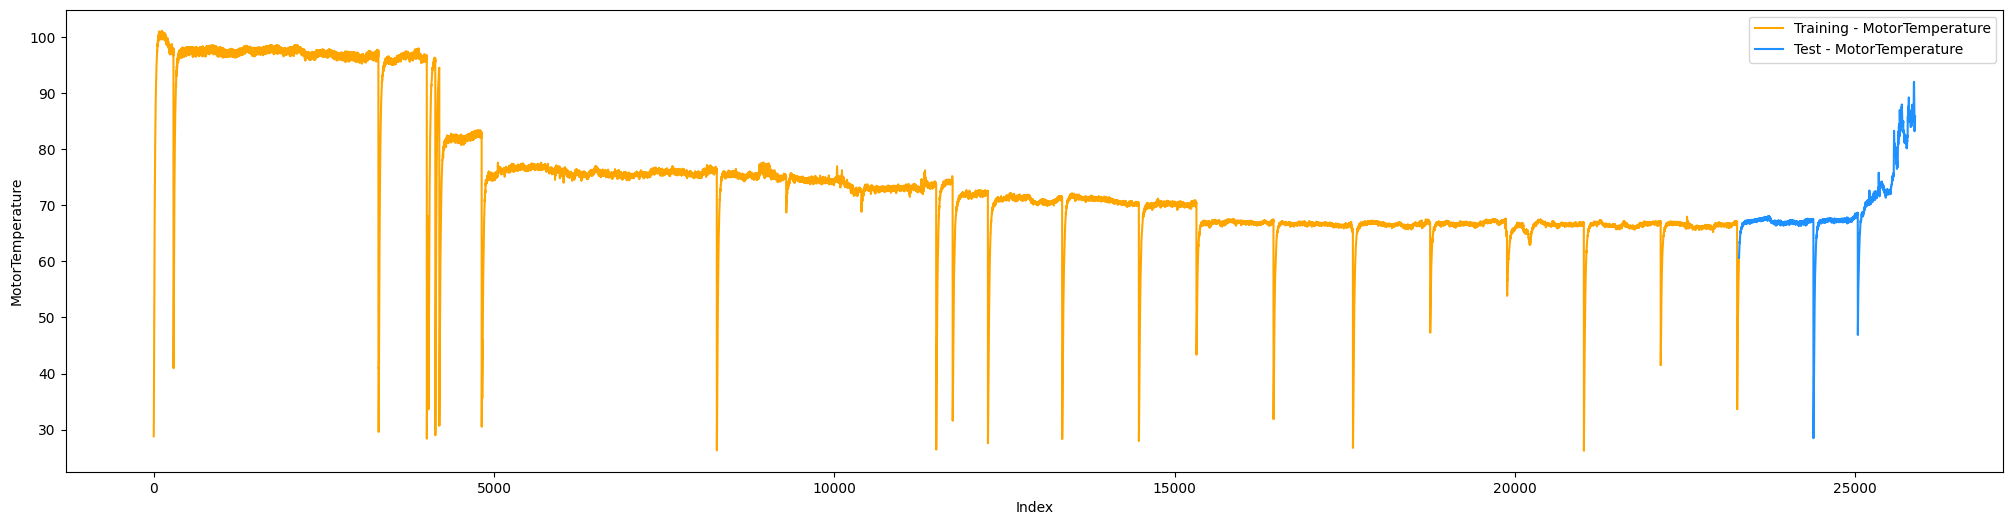

In [ ]:
filtered_data = data[data['CurveProcess_top'] == 1]
filtered_data = filtered_data.drop(['Datetime'], axis=1)
print(filtered_data.shape)
filtered_data = filtered_data.iloc[::60] #Every 10 cycles
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

testSize = int(filtered_data.shape[0]*0.1) #Last N values coz it's time series
#testSize = 50
print(testSize)

plt.figure(figsize=(25, 6))
# Plot the 'MotorTemperature' column
plt.plot(filtered_data.index[:-testSize], filtered_data['MotorTemperature'][:-testSize], label='Training - MotorTemperature', color='orange')
plt.plot(filtered_data.index[-testSize:], filtered_data['MotorTemperature'][-testSize:], label='Test - MotorTemperature', color='dodgerblue')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('MotorTemperature')
plt.legend()

# Show the plot
plt.show()


In [ ]:
print(filtered_data.shape)
filtered_data = filtered_data[['Speed1Std', 'Speed1Q1', 'Torque1Std', 'Torque1Mean', 'MotorTemperature']]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)

# Split the data into training and test sets
training_data = filtered_data.iloc[:-testSize]
test_data = filtered_data.iloc[-testSize:]


print('Training: ', training_data.shape)
print('Test: ', test_data.shape)


(25880, 27)
(25880, 5)
Training:  (23292, 5)
Test:  (2588, 5)


**Normalization**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Create a Min-Max scaler
scaler = MinMaxScaler()

# Extract the target variable (MotorTemperature) and feature columns
X_train = training_data.drop(columns=['MotorTemperature'])  # Features
y_train = training_data['MotorTemperature']  # Target

# Fit the scaler on your feature data only
scaler.fit(X_train)

# Transform both training and test feature data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(test_data.drop(columns=['MotorTemperature']))

# Create DataFrames for the normalized feature data
columns = X_train.columns  # Get the column names from the original DataFrame
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=columns)

# Combine the normalized feature data with the target variable
training_data_normalized_df = pd.concat([X_train_normalized_df, y_train.reset_index(drop=True)], axis=1)
test_data_normalized_df = pd.concat([X_test_normalized_df, test_data['MotorTemperature'].reset_index(drop=True)], axis=1)


In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5,  min_delta=0.01, verbose=1, restore_best_weights=True)

Epoch 1/100
67/67 [==============================] - 3s 15ms/step - loss: 94.8140 - val_loss: 85.8047
Epoch 2/100
67/67 [==============================] - 1s 8ms/step - loss: 83.3729 - val_loss: 76.6919
Epoch 3/100
67/67 [==============================] - 0s 7ms/step - loss: 77.6026 - val_loss: 72.1495
Epoch 4/100
67/67 [==============================] - 0s 7ms/step - loss: 73.3318 - val_loss: 68.0744
Epoch 5/100
67/67 [==============================] - 0s 7ms/step - loss: 69.3640 - val_loss: 64.1965
Epoch 6/100
67/67 [==============================] - 0s 7ms/step - loss: 65.5489 - val_loss: 60.4565
Epoch 7/100
67/67 [==============================] - 0s 7ms/step - loss: 61.8330 - val_loss: 56.8119
Epoch 8/100
67/67 [==============================] - 0s 7ms/step - loss: 58.1796 - val_loss: 53.2415
Epoch 9/100
67/67 [==============================] - 1s 10ms/step - loss: 54.5786 - val_loss: 49.7449
Epoch 10/100
67/67 [==============================] - 0s 6ms/step - loss: 51.0216 - val_l

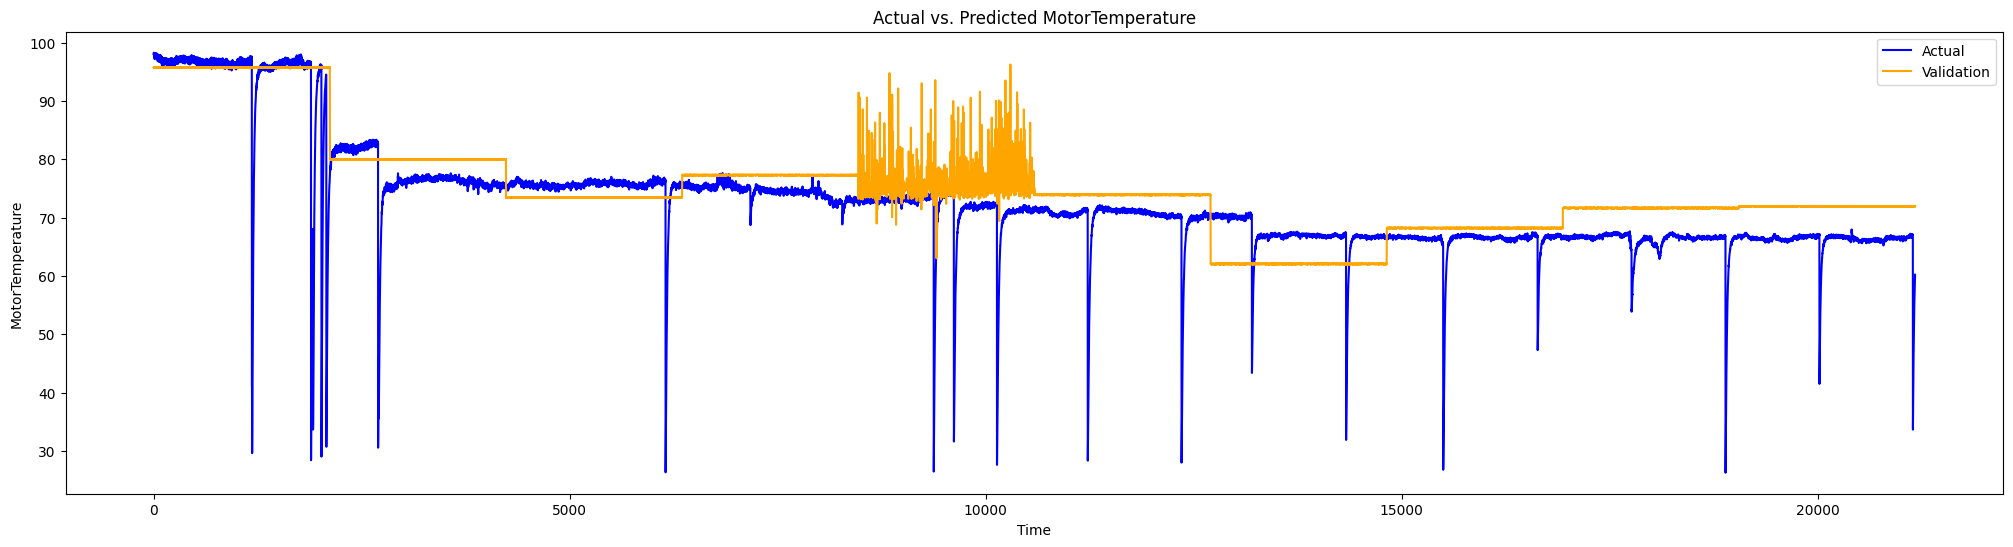

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store actual and predicted values
actual_values = []
predicted_values = []
histories = []

# Iterate through the cross-validation folds
for train_index, val_index in tscv.split(training_data_normalized_df):
    train_fold = training_data_normalized_df.iloc[train_index]
    val_fold = training_data_normalized_df.iloc[val_index]

    # Prepare sequences and targets for training
    X_train = train_fold.drop('MotorTemperature', axis=1).values
    y_train = train_fold['MotorTemperature'].values

    X_val = val_fold.drop('MotorTemperature', axis=1).values
    y_val = val_fold['MotorTemperature'].values

    # Define and compile the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # Train the model with early stopping
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
    histories.append(history)

    # Make predictions on the validation fold
    predictions = model.predict(X_val)

    # Append actual and predicted values to the lists
    actual_values.extend(y_val)
    predicted_values.extend(predictions.flatten())

# Evaluate using MAE un MSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

# Plot actual vs. predicted values
plt.figure(figsize=(25, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(predicted_values, label='Validation', color='orange')
plt.xlabel('Time')
plt.ylabel('MotorTemperature')
plt.title('Actual vs. Predicted MotorTemperature')
plt.legend()
plt.show()


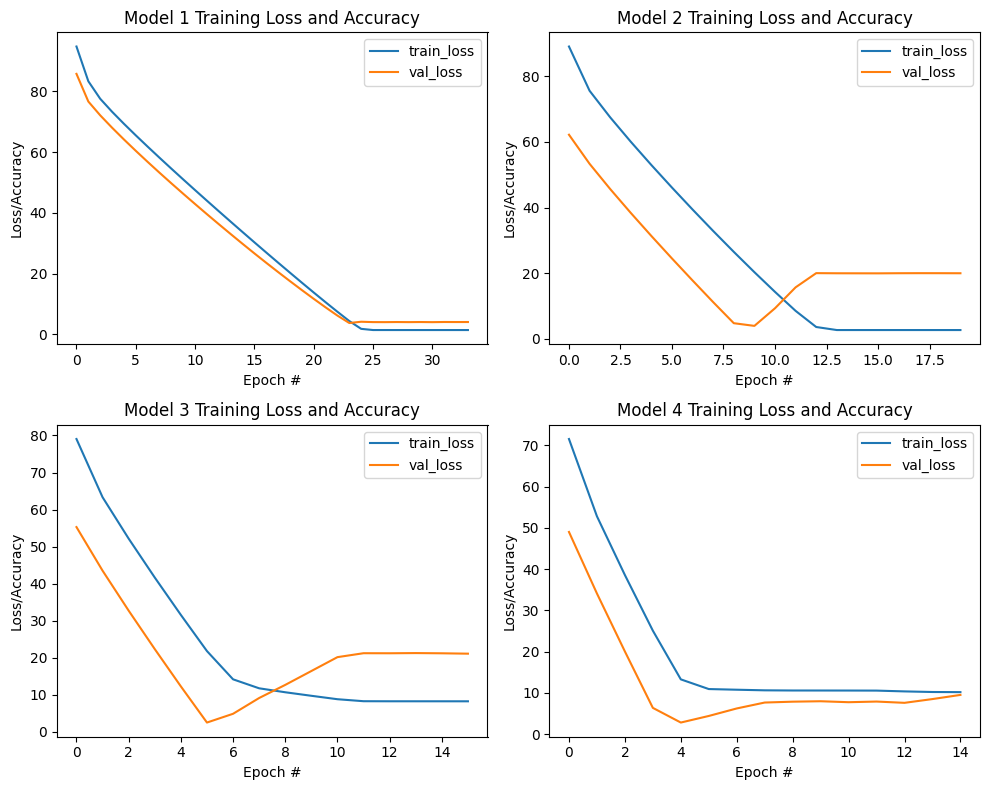

In [ ]:
# Create subplots for 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Iterate through the first four history objects
for i, history in enumerate(histories[:4]):
    num_epochs = len(history.history['loss'])
    # Determine the position in the subplot grid
    row = i // 2
    col = i % 2

    # Plot the training and validation metrics
    ax = axes[row, col]
    ax.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
    ax.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
    ax.set_title(f"Model {i+1} Training Loss and Accuracy")
    ax.set_xlabel("Epoch #")
    ax.set_ylabel("Loss/Accuracy")
    ax.legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test_normalized_df, test_data['MotorTemperature'], verbose=0)

# Print the test loss (e.g., Mean Absolute Error or Mean Squared Error)
print("Test Loss:", test_loss)


Test Loss: 5.335218906402588


81/81 [==============================] - 0s 2ms/step


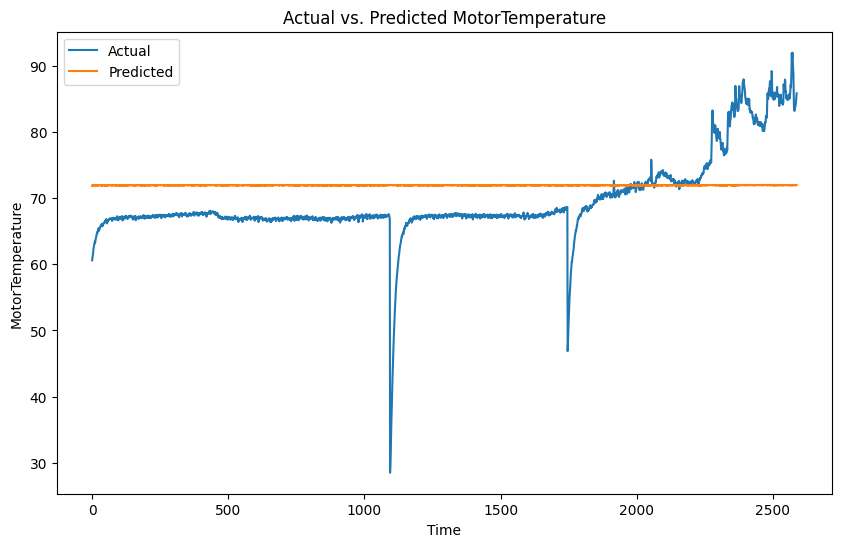

In [ ]:
# Make predictions on the test data
X_test = X_test_normalized_df.values  # Assuming X_test_normalized_df contains the normalized feature data
predictions = model.predict(X_test)

# Extract the actual 'MotorTemperature' values from the test data
actual_values = test_data['MotorTemperature'].values

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('MotorTemperature')
plt.title('Actual vs. Predicted MotorTemperature')
plt.legend()
plt.show()

## Torque

Stationarity
ACF and PACF assume stationarity of the underlying time series. Staionarity can be checked by performing an Augmented Dickey-Fuller (ADF) test:

*    p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
*    p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

[...] We can see that our [ADF] statistic value [...] is less than the value [...] at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.
*    [Machine Learning Mastery: How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/).
*    [Time Series: Interpreting ACF and PACF](https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf/notebook)

In [ ]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
print(data.shape)
filtered_data = data[data['CurveProcess_top'] == 1]
print(filtered_data.shape)
filtered_data = filtered_data[filtered_data['Process_BF4'] == 1]
filtered_data.reset_index(drop=True, inplace=True)
print(filtered_data.shape)


(4658352, 28)
(1552784, 28)
(258258, 28)


In [ ]:
check_stationarity(filtered_data['Torque1Q2'])

ADF Statistic: -14.336781
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


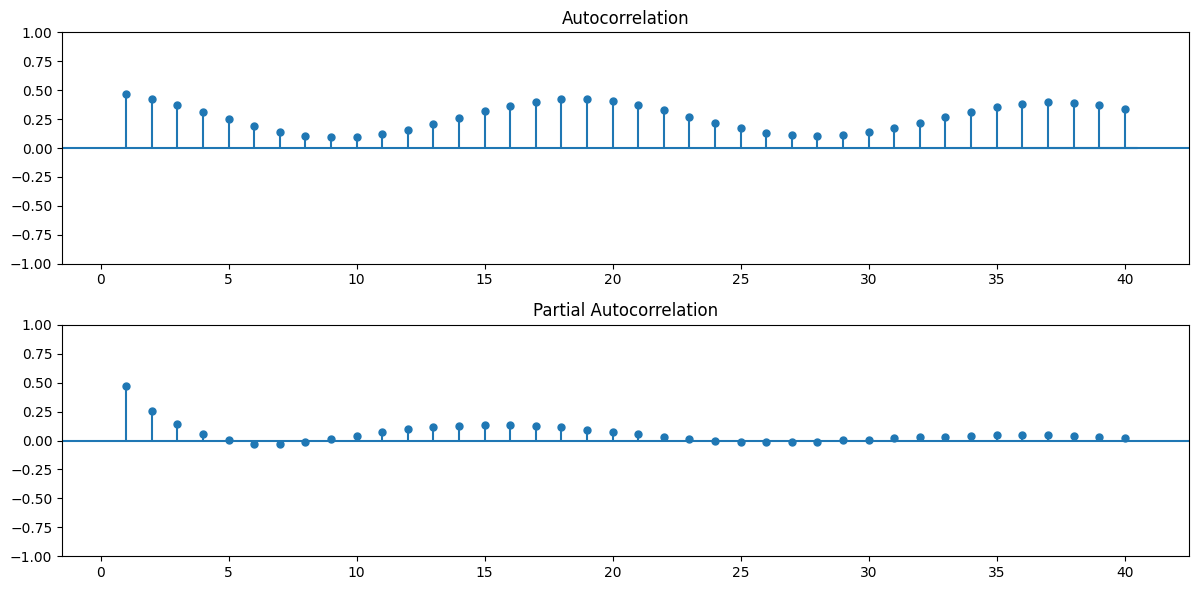

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
plot_acf(filtered_data['Torque1Q2'], lags=40, ax=ax[0], zero=False,  alpha=0.05)  #alpha parameter for confidence interval 0.05 for a 95%
plot_pacf(filtered_data['Torque1Q2'], lags=40, ax=ax[1], method='ols', zero=False, alpha=0.05)

plt.tight_layout()
plt.show()


Where is the confidence interval?<br>
Let's zoom in

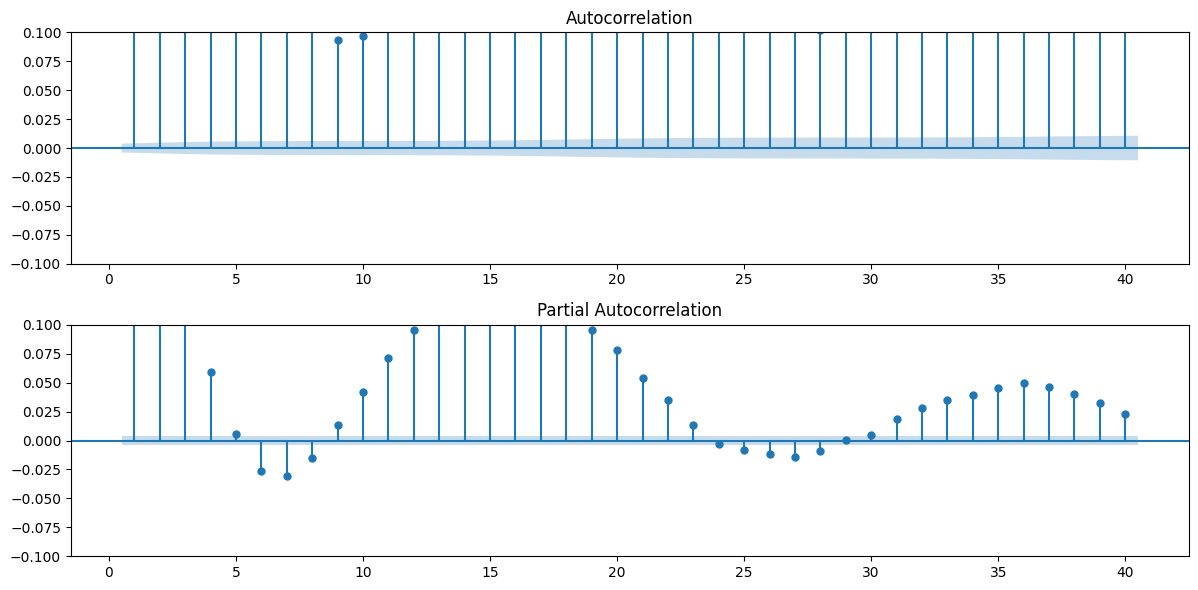

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
plot_acf(filtered_data['Torque1Q2'], lags=40, ax=ax[0], zero=False, alpha=0.05)
plot_pacf(filtered_data['Torque1Q2'], lags=40, ax=ax[1], method='ols', zero=False, alpha=0.05)

# Set the y-axis limits to -0.1 and 0.1
ax[0].set_ylim(-0.1, 0.1)
ax[1].set_ylim(-0.1, 0.1)

plt.tight_layout()
plt.show()


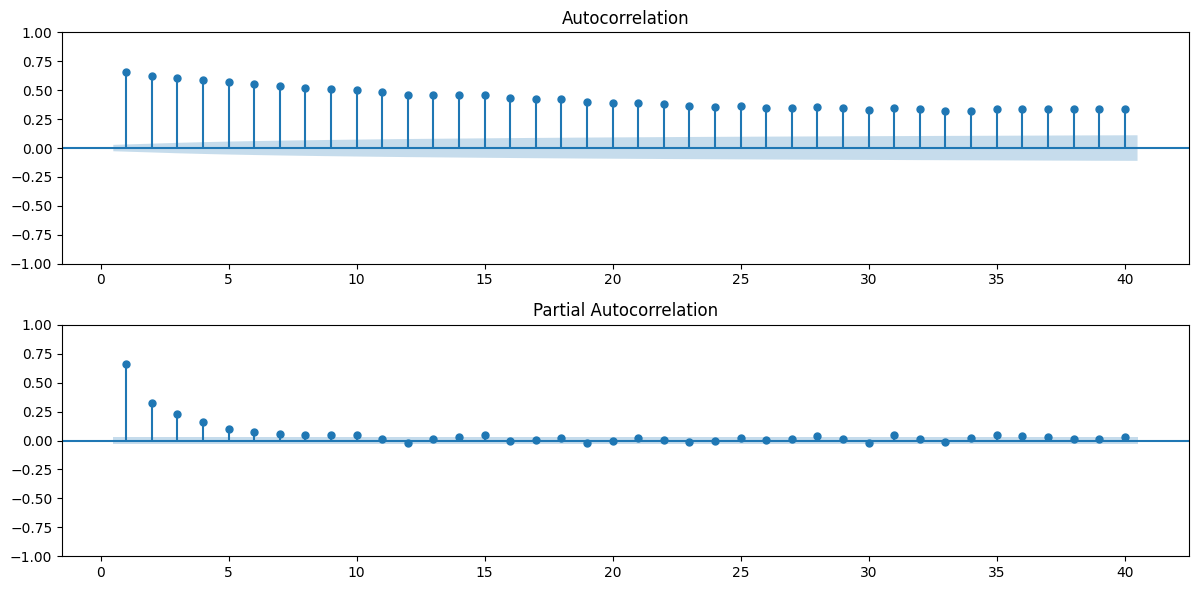

In [ ]:
subset_data = filtered_data['Torque1Q2'].iloc[0:5000]

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
plot_acf(subset_data, lags=40, ax=ax[0], zero=False,  alpha=0.05)  #alpha parameter for confidence interval 0.05 for a 95%
plot_pacf(subset_data, lags=40, ax=ax[1], method='ols', zero=False, alpha=0.05)

plt.tight_layout()
plt.show()


In conclusion, with such a small confidence interval, it represent a lack of significant autocorrelation or just white noise. Althought it's stationary it doesn't mean that is predictable.

Let's look, considering all the processes.

In [ ]:
print(data.shape)
filtered_data = data.iloc[0:500000]
print(filtered_data.shape)


(4658352, 28)
(500000, 28)


In [ ]:
check_stationarity(filtered_data['Torque1Q2'])

ADF Statistic: -73.319508
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


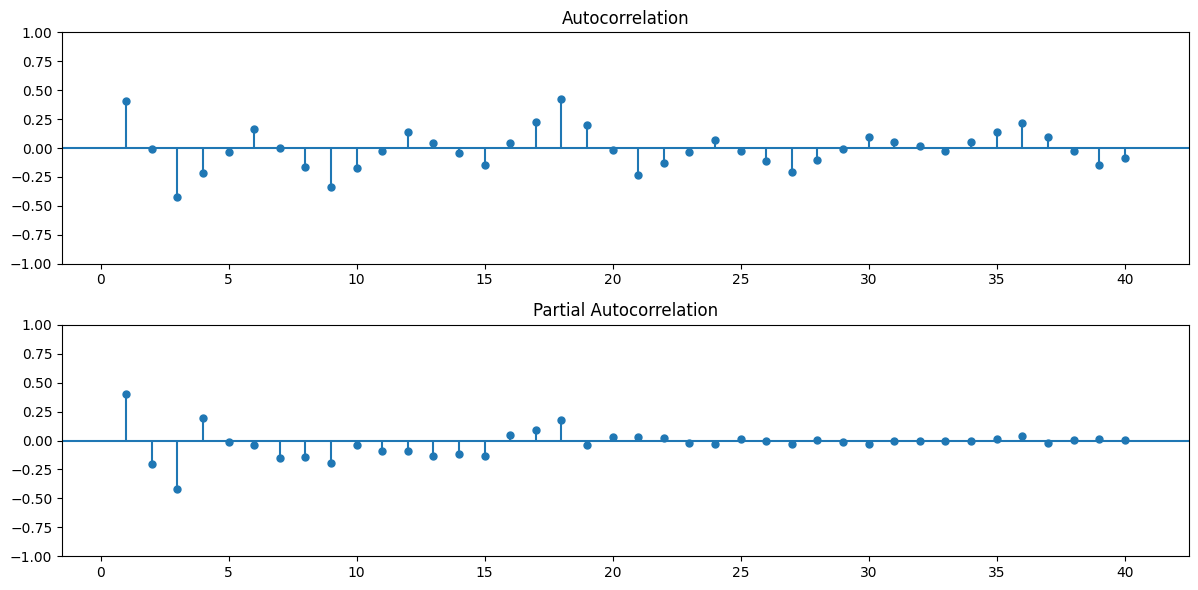

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
plot_acf(filtered_data['Torque1Q2'], lags=40, ax=ax[0], zero=False,  alpha=0.05)  #alpha parameter for confidence interval 0.05 for a 95%
plot_pacf(filtered_data['Torque1Q2'], lags=40, ax=ax[1], method='ols', zero=False, alpha=0.05)

plt.tight_layout()
plt.show()


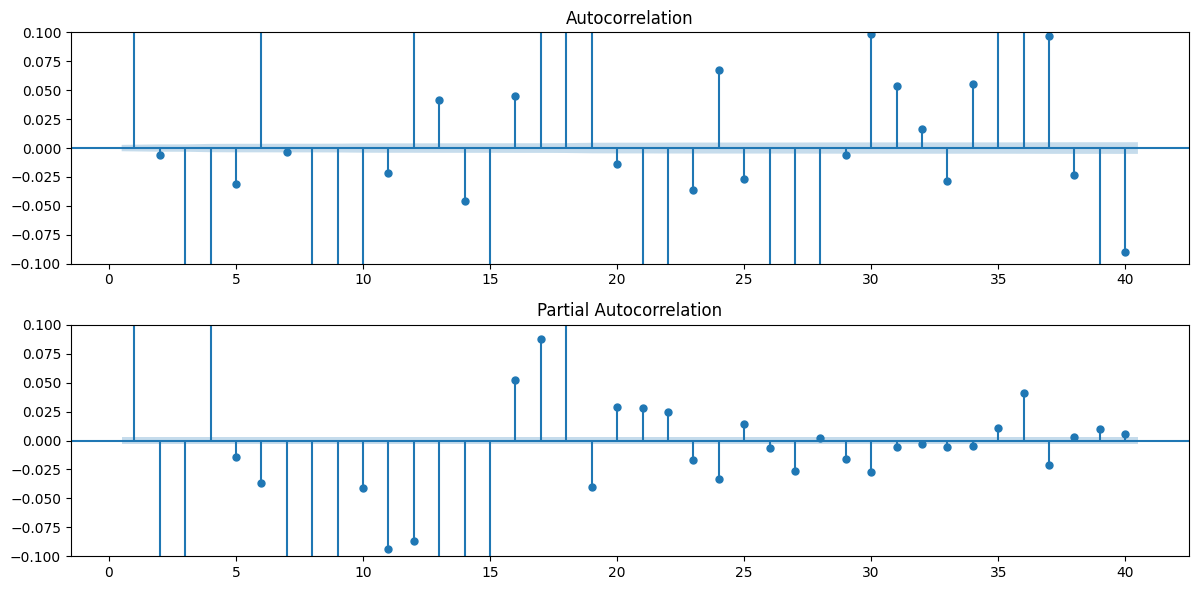

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
plot_acf(filtered_data['Torque1Q2'], lags=40, ax=ax[0], zero=False, alpha=0.05)
plot_pacf(filtered_data['Torque1Q2'], lags=40, ax=ax[1], method='ols', zero=False, alpha=0.05)

# Set the y-axis limits to -0.1 and 0.1
ax[0].set_ylim(-0.1, 0.1)
ax[1].set_ylim(-0.1, 0.1)

plt.tight_layout()
plt.show()

The same result as before, such a small confidence interval, it represent a lack of significant autocorrelation or just white noise. Althought it's stationary it doesn't mean that is predictable.<br>
It make sense because our variables regarding Torque and Speed is sample of the original values. These original data, before sampling, would be interested to do such analysis.

In the same way we could discard:


*   STL analysis: because there's no clear seasonal patterns or cycles.



Let's **continue the knowledge obtaing in the desriptive analysis**

In [ ]:
def LinearRegressionAndPlot(dataset, column_name, upper_threshold, lower_threshold, toPlot=True):

  if column_name not in dataset.columns:
    print('Column name not foundin the dataset')
    return False

  # Fit a linear regression model to the data
  X = np.arange(len(dataset)).reshape(-1, 1)
  y = dataset[column_name].values
  regressor = LinearRegression()
  regressor.fit(X, y)
  y_pred = regressor.predict(X)

  # Calculate upper and lower threshold lines
  upper_thresh = y_pred + upper_threshold
  lower_thresh = y_pred - lower_threshold

  # Classify outliers based on the thresholds
  upper_outliers = dataset[dataset[column_name] > upper_thresh]
  lower_outliers = dataset[dataset[column_name] < lower_thresh]
  all_outliers = pd.concat([upper_outliers, lower_outliers])

  if (True == toPlot):
    # Plot the column_name values
    plt.figure(figsize=(25, 6))
    plt.plot(dataset['Datetime'], dataset[column_name], label=column_name, color='dodgerblue')
    plt.xlabel('Datetime')
    plt.ylabel(column_name)
    plt.title(column_name + ' Time Series Data. Process BF5')

    # Plot the trendline
    plt.plot(dataset['Datetime'], y_pred, color='blue', linestyle='-', linewidth=2, label='Trendline')

    # Plot upper and lower threshold lines
    plt.plot(dataset['Datetime'], upper_thresh, color='orange', linestyle='--', label='Upper Threshold (+0.1)')
    plt.plot(dataset['Datetime'], lower_thresh, color='orange', linestyle='--', label='Lower Threshold (-0.1)')

    # Mark upper and lower threshold outliers
    plt.scatter(all_outliers['Datetime'], all_outliers[column_name], color='red', marker='o', s=50, label='Threshold Outliers')

    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

In [ ]:
def LinearRegressionOutlierFrequencyAndPlot(dataset, column_name, upper_threshold, lower_threshold, frequency=1000, toPlot=True):
    # Create an empty list to store OutlierFrequency values
    OutlierFrequency = []

    if column_name not in dataset.columns:
        print('Column name not found in the dataset')
        return False

    # Fit a linear regression model to the data
    X = np.arange(len(dataset)).reshape(-1, 1)
    y = dataset[column_name].values
    regressor = LinearRegression()
    regressor.fit(X, y)
    y_pred = regressor.predict(X)

    # Calculate upper and lower threshold lines
    upper_thresh = y_pred + upper_threshold
    lower_thresh = y_pred - lower_threshold

    # Iterate through the dataset
    for i in range(len(dataset)):
        # Consider each sample and its index
        current_sample = dataset.iloc[i]
        current_index = current_sample.name

        # Take the last x values (if available)
        x_values = frequency
        last_x_samples = dataset.iloc[max(0, current_index - (x_values-1)): current_index + 1]

        # Count how many values exceed the upper_threshold or fall below the lower_threshold
        outlet_count = ((last_x_samples[column_name] > upper_thresh[i]) |
                        (last_x_samples[column_name] < lower_thresh[i])).sum()

        # Append the count to the OutlierFrequency list
        OutlierFrequency.append(outlet_count)

    # Create a new column 'OutlierFrequency' in the dataset
    dataset.loc[:, 'OutlierFrequency'] = OutlierFrequency

    if toPlot:
        # Plot 'OutlierFrequency' vs 'Datetime'
        plt.figure(figsize=(25, 6))
        plt.plot(dataset['Datetime'], dataset['OutlierFrequency'], label='OutlierFrequency', color='dodgerblue')
        plt.axhline(y=4, color='orange', linestyle='--', label='Threshold (4)')
        plt.xlabel('Datetime')
        plt.ylabel('OutlierFrequency' + column_name)
        plt.title('OutlierFrequency ' + column_name + ' every: ' + str(x_values) + ' vs Datetime. Process BF5')
        plt.grid(True)
        plt.legend()
        plt.show()


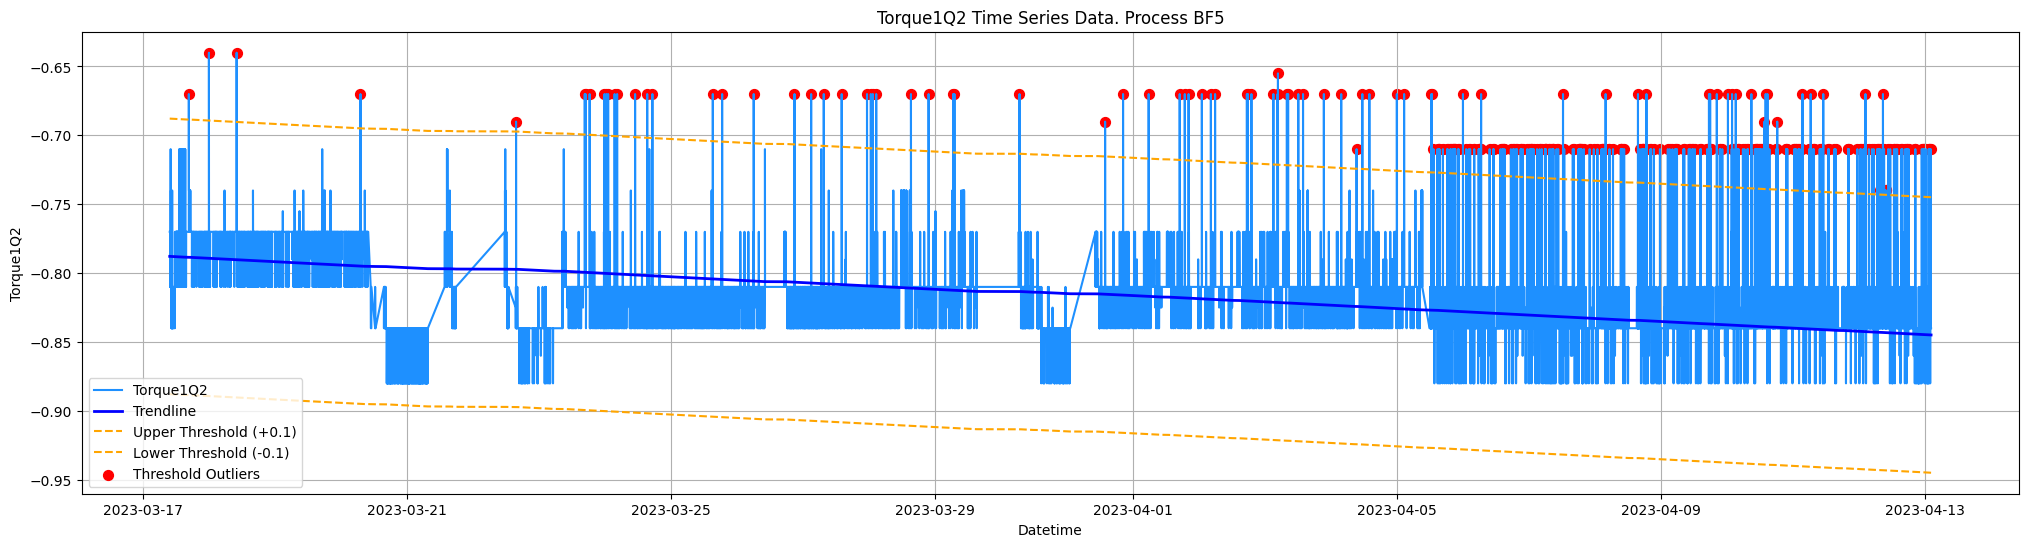

In [ ]:
filtered_data = data[(data['CurveProcess_top'] == 1) & (data['Process_BF5'] == 1)]
filtered_data.reset_index(drop=True, inplace=True)

upper_threshold = 0.1
lower_threshold = 0.1
LinearRegressionAndPlot(filtered_data, 'Torque1Q2', upper_threshold, lower_threshold )

To confirm that we'll calculate and plot the frquency of outlets.

<ipython-input-21-4093848fe39b>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,'OutlierFrequency'] = OutlierFrequency


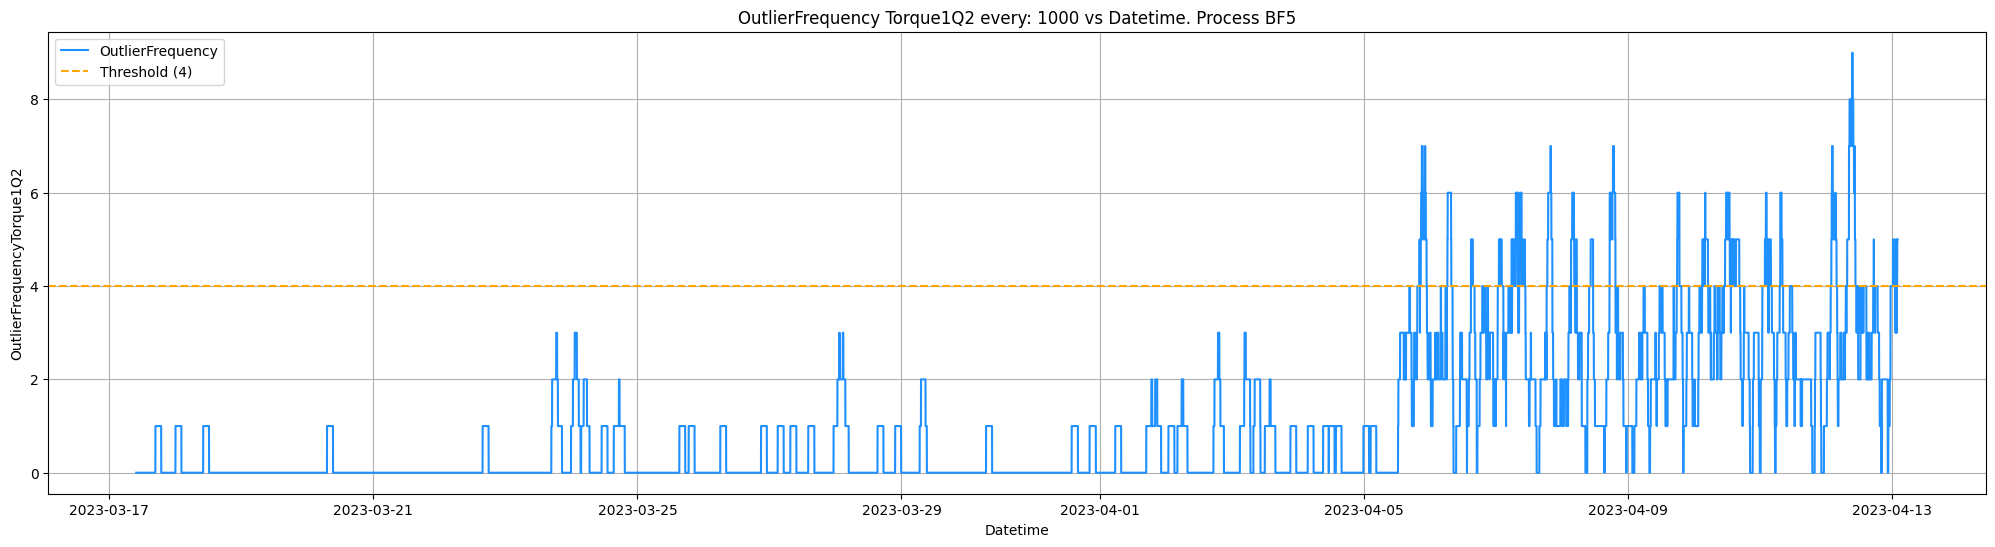

In [ ]:
filtered_data = data[(data['CurveProcess_top'] == 1) & (data['Process_BF5'] == 1)]
filtered_data.reset_index(drop=True, inplace=True)

LinearRegressionOutlierFrequencyAndPlot(filtered_data, 'Torque1Q2', upper_threshold, lower_threshold, frequency=1000, toPlot=True)

Let's keep the last 6 days for testing and try to predict the number of OutlierFrequency

In [ ]:
from datetime import timedelta

del(filtered_data)
filtered_data = data[(data['CurveProcess_top'] == 1) & (data['Process_BF5'] == 1)]
filtered_data.reset_index(drop=True, inplace=True)

# Specify the number of days to exclude
days_to_exclude = 6

# Calculate the cutoff date (the last date to include)
cutoff_date = filtered_data['Datetime'].max() - timedelta(days=days_to_exclude)

# Filter the DataFrame to include only rows before the cutoff date
filtered_data = filtered_data[filtered_data['Datetime'] <= cutoff_date]
test_filtered_data = filtered_data[filtered_data['Datetime'] > cutoff_date]

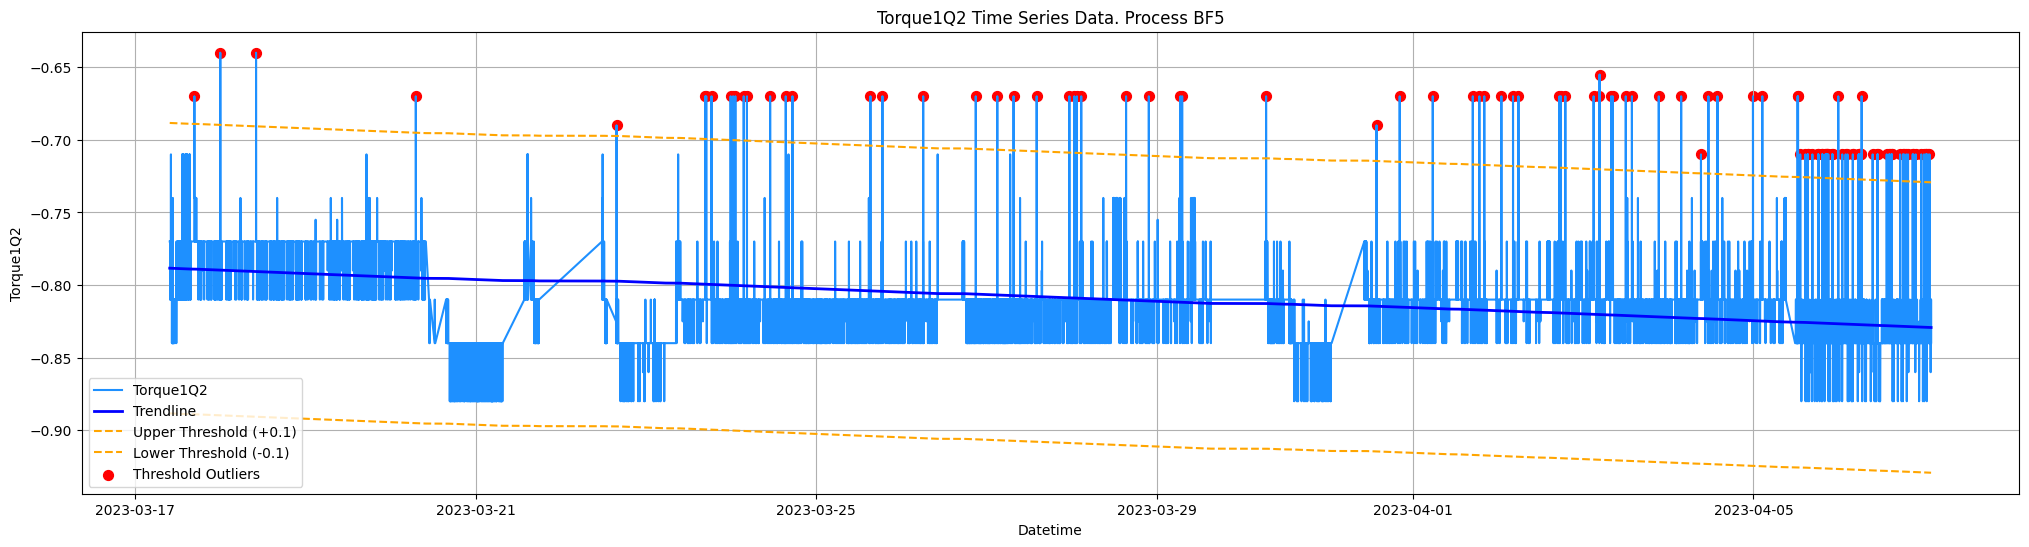

In [ ]:
upper_threshold = 0.1
lower_threshold = 0.1
LinearRegressionAndPlot(filtered_data, 'Torque1Q2', upper_threshold, lower_threshold )

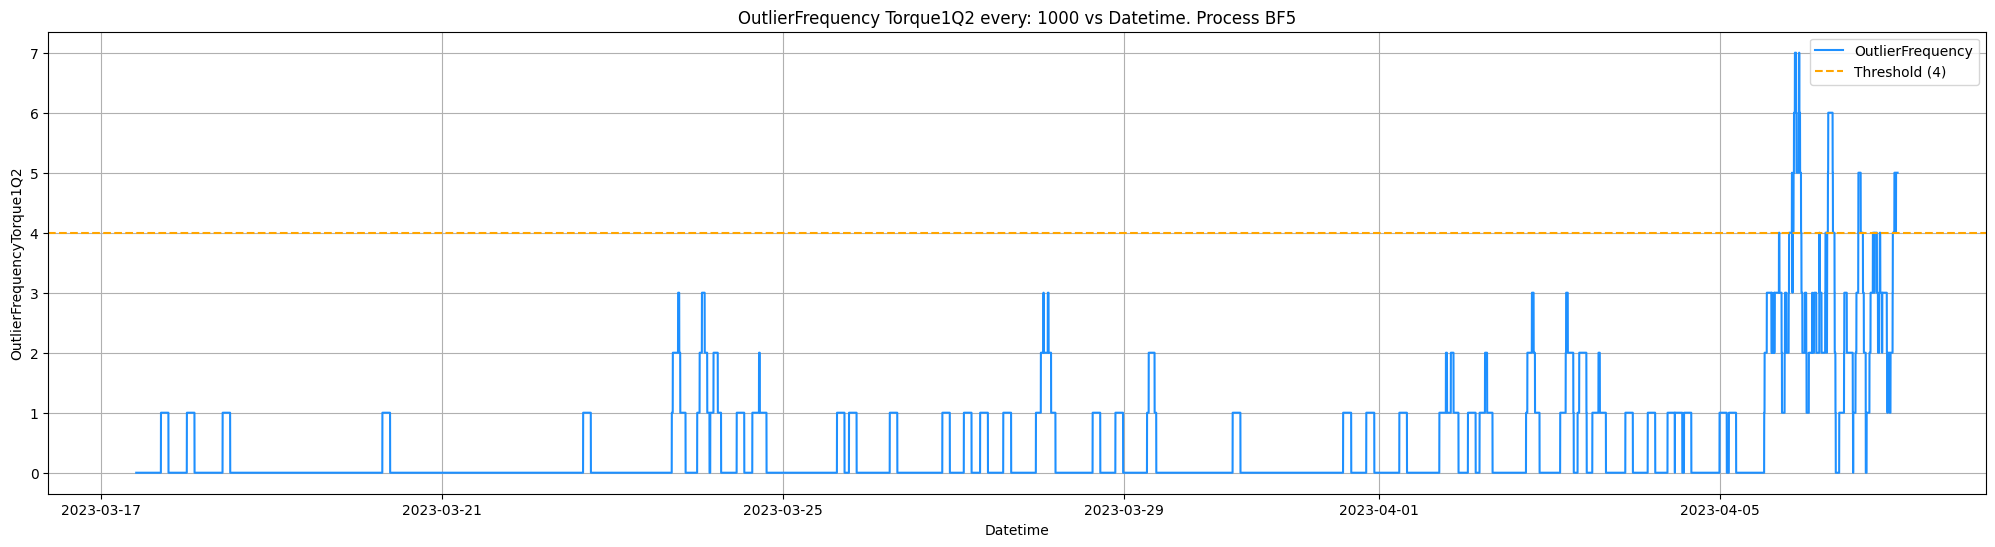

In [ ]:
LinearRegressionOutlierFrequencyAndPlot(filtered_data, 'Torque1Q2', 0.1, 0.1, 1000)

### Random Forest for feature selection


In [ ]:
print(filtered_data.shape)
filtered_data.drop(columns=['Datetime', 'TimeLength',  'PositionInit', 'PositionLength',\
                            'Process_BF1', 'Process_BF2', 'Process_BF3', 'Process_BF4', 'Process_BF5', 'Process_BF6', \
                            'CurveProcess_acceleration', 'CurveProcess_decceleration', 'CurveProcess_top'], inplace=True)
print(filtered_data.columns)
print(filtered_data.shape)

(194384, 28)
Index(['MotorTemperature', 'Speed1Mean', 'Speed1Std', 'Speed1Min', 'Speed1Q1',
       'Speed1Q2', 'Speed1Q3', 'Speed1Max', 'Torque1Mean', 'Torque1Std',
       'Torque1Min', 'Torque1Q1', 'Torque1Q2', 'Torque1Q3', 'Torque1Max',
       'OutlierFrequency'],
      dtype='object')
(194384, 16)


In [ ]:
filtered_data = filtered_data.iloc[::10]

print(filtered_data.shape)

(19439, 16)


In [ ]:
param_dist = {"n_estimators": [2, 4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_features": [1.0], # Auto, Number of features to consider at every split
              "max_depth": [None, 2, 4, 8, 16], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["absolute_error"]}


In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor()

# Initialize the RandomizedSearchCV with time series split
rnd_regres = RandomizedSearchCV(estimator=regressor, param_distributions=param_dist, n_iter=10, cv=tscv, random_state=42, verbose=1) #n_jobs=1

# Fit the random search model
rnd_regres.fit(X=filtered_data.drop(['OutlierFrequency'], axis=1), y=filtered_data['OutlierFrequency'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['absolute_error'],
                                        'max_depth': [None, 2, 4, 8, 16],
                                        'max_features': [1.0],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bad326017e0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bad32600580>,
                                        'n_estimators': [2, 4, 8, 16, 32, 64,
                                                         128]},
                   random_state=42, verbose=1)

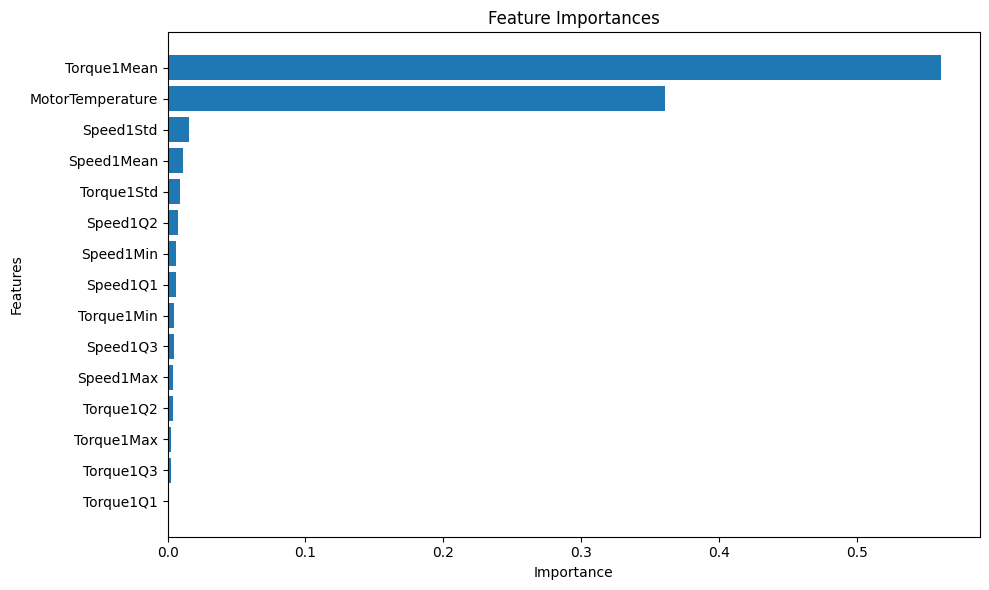

In [ ]:
best_model = rnd_regres.best_estimator_

# Get feature importances
importances = best_model.feature_importances_

# Create a list of feature names
feature_names = filtered_data.drop(['OutlierFrequency'], axis=1).columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices][::-1], align='center')
plt.yticks(range(len(importances)), feature_names[indices][::-1])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()



In [ ]:
report(rnd_regres.cv_results_, 5)

Model with rank: 1
Mean validation score: -0.354 (std: 0.307)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 4}

Model with rank: 2
Mean validation score: -0.404 (std: 0.246)
Parameters: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 14, 'min_samples_split': 10, 'n_estimators': 4}

Model with rank: 3
Mean validation score: -0.409 (std: 0.349)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 8, 'max_features': 1.0, 'min_samples_leaf': 29, 'min_samples_split': 16, 'n_estimators': 8}

Model with rank: 4
Mean validation score: -0.417 (std: 0.375)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 11, 'min_samples_split': 25, 'n_estimators': 32}

Model with rank: 5
Mean validation score: -0.430 (std: 0.316)
Parameter



*   We keep only Torque1Mean and MotorTemperature for OutlierFrequency predictions
*   We execute Grid Search based on the best models and its parameters from the Random Search



### Random Forest for predictions

In [ ]:
print(filtered_data.shape)
filtered_data = filtered_data[['Torque1Mean', 'MotorTemperature', 'OutlierFrequency']]

print(filtered_data.columns)

(19439, 16)
Index(['Torque1Mean', 'MotorTemperature', 'OutlierFrequency'], dtype='object')


In [ ]:
print(filtered_data.shape)

(19439, 3)


In [ ]:
param_dist = {
    'bootstrap': [True, False],
    'criterion': ['absolute_error'],
    'max_depth': [None, 8, 16],
    'max_features': [1.0],
    'min_samples_leaf': [9, 14],
    'min_samples_split': [10, 40],
    'n_estimators': [4, 8]
}

In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor()

grid_regres = GridSearchCV(estimator=regressor, param_grid=param_dist, cv=tscv, verbose=1)

# Fit the grid search model
grid_regres.fit(X=filtered_data.drop(['OutlierFrequency'], axis=1), y=filtered_data['OutlierFrequency'])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['absolute_error'],
                         'max_depth': [None, 8, 16], 'max_features': [1.0],
                         'min_samples_leaf': [9, 14],
                         'min_samples_split': [10, 40],
                         'n_estimators': [4, 8]},
             verbose=1)

In [ ]:
report(grid_regres.cv_results_, 5)

Model with rank: 1
Mean validation score: -0.375 (std: 0.198)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 14, 'min_samples_split': 10, 'n_estimators': 4}

Model with rank: 2
Mean validation score: -0.417 (std: 0.211)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 40, 'n_estimators': 8}

Model with rank: 3
Mean validation score: -0.419 (std: 0.300)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 8, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 8}

Model with rank: 4
Mean validation score: -0.426 (std: 0.169)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 14, 'min_samples_split': 10, 'n_estimators': 4}

Model with rank: 5
Mean validation score: -0.429 (std: 0.224)
Parameters:

In [ ]:
#backup_filtered_data = filtered_data

Recalculate and transform the data to get the right transformed values for the test dataset

In [ ]:
f_data = data[(data['CurveProcess_top'] == 1) & (data['Process_BF5'] == 1)]
f_data.reset_index(drop=True, inplace=True)

# Specify the number of days to exclude
days_to_exclude = 6

# Calculate the cutoff date (the last date to include)
cutoff_date = f_data['Datetime'].max() - timedelta(days=days_to_exclude)


In [ ]:
upper_threshold = 0.1
lower_threshold = 0.1
#LinearRegressionAndPlot(f_data, 'Torque1Q2', upper_threshold, lower_threshold, False )
print(f_data.shape)
LinearRegressionOutlierFrequencyAndPlot(f_data, 'Torque1Q2', 0.1, 0.1, 1000, False)
print(f_data.shape)

(258866, 28)
(258866, 29)


<ipython-input-43-96c714fc020e>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'OutlierFrequency'] = OutlierFrequency


In [ ]:
#f_data.shape

(258866, 28)

In [ ]:
#LinearRegressionOutlierFrequencyAndPlot(f_data, 'Torque1Q2', 0.1, 0.1, 1000, False)

In [ ]:
#f_data.shape

(258866, 29)

In [ ]:
#backup_f_data=f_data

In [ ]:
# Filter the DataFrame to include only rows before the cutoff date
f_data_test = f_data[f_data['Datetime'] > cutoff_date]
f_data = f_data[f_data['Datetime'] <= cutoff_date]
print(f_data.shape)
print(f_data_test.shape)

(194384, 29)
(64482, 29)


In [ ]:
print(f_data.shape)
print(f_data_test.shape)

(194384, 29)
(64482, 29)


In [ ]:
#f_data_test = f_data_test.iloc[::10]

#print(f_data_test.shape)

(6449, 29)


In [ ]:
f_data_test = f_data_test[['Torque1Mean', 'MotorTemperature', 'OutlierFrequency']]

Calculate the transformation for test_filtered_data

In [ ]:
# Get the best model from the optimization
best_model = grid_regres.best_estimator_

# Make predictions on the test_data
predictions = best_model.predict(f_data_test.drop(['OutlierFrequency'], axis=1))

actual_values = f_data_test['OutlierFrequency']

# Evaluate using MAE un MSE
mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(actual_values, predictions)
print("Mean Squared Error:", mse)

Mean Absolute Error: 1.7202920970193232
Mean Squared Error: 4.97290401778791


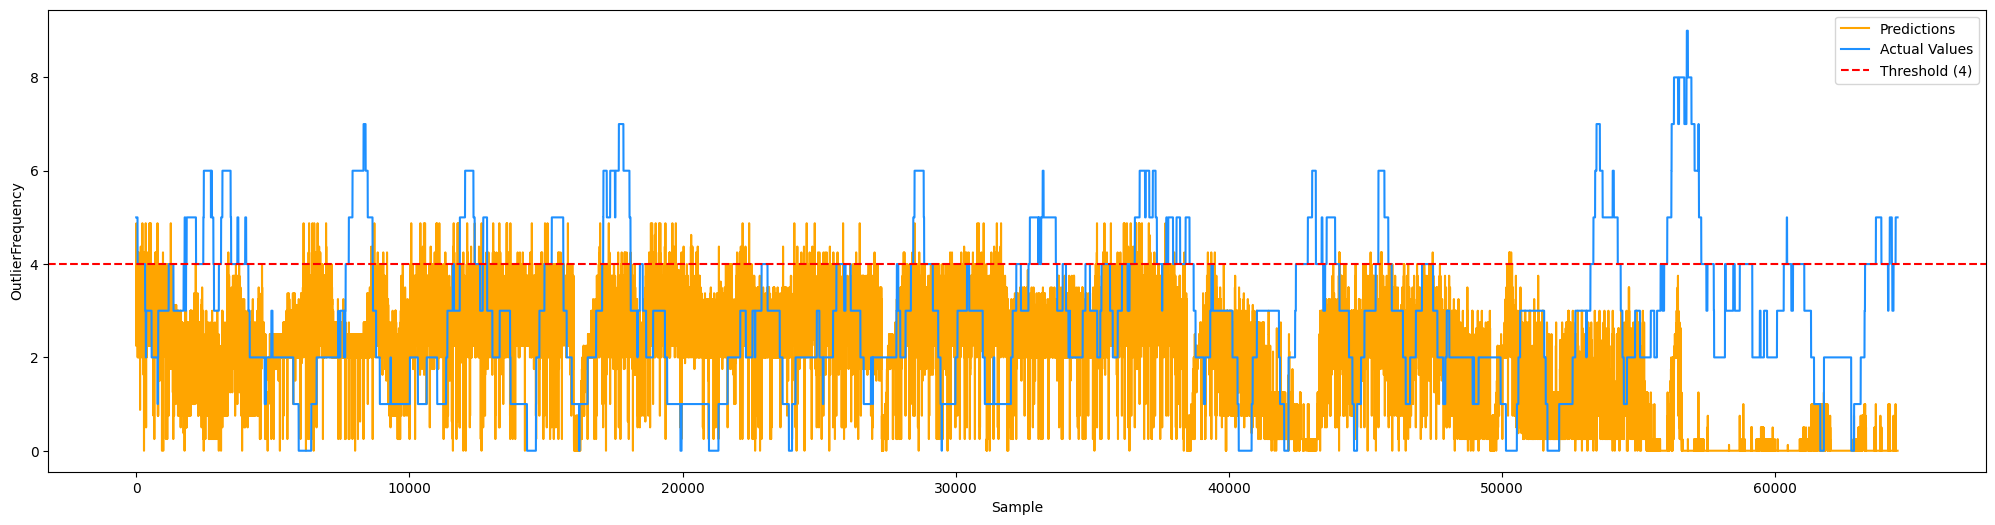

In [ ]:
# Create an array for the x-axis
x_axis = range(len(actual_values))

plt.figure(figsize=(25, 6))
# Plot the actual values in blue and the predictions in red
plt.plot(x_axis, predictions, label='Predictions', color='orange')
plt.plot(x_axis, actual_values, label='Actual Values', color='dodgerblue')

plt.axhline(y=4, color='red', linestyle='--', label='Threshold (4)')

# Add labels and legend
plt.xlabel('Sample')
plt.ylabel('OutlierFrequency')
plt.legend()

# Show the plot
plt.show()

# plt.plot(dataset['Datetime'], dataset['OutlierFrequency'], label='OutlierFrequency', color='dodgerblue')
#         plt.axhline(y=4, color='orange', linestyle='--', label='Threshold (4)')
#         plt.xlabel('Datetime')

**Finding**
* We are able to **predict** the new variable **OutlierFrequency** not only with a good MAE and MSE, the predicted values will go above the threshold and therefore will be an **indicator for maintenace**. Since we have calculated the test data using the data of the last **6 days** from the dataset, it gives a very good time to perform the **correspondant maintenace** at the system.

# Old things - Test

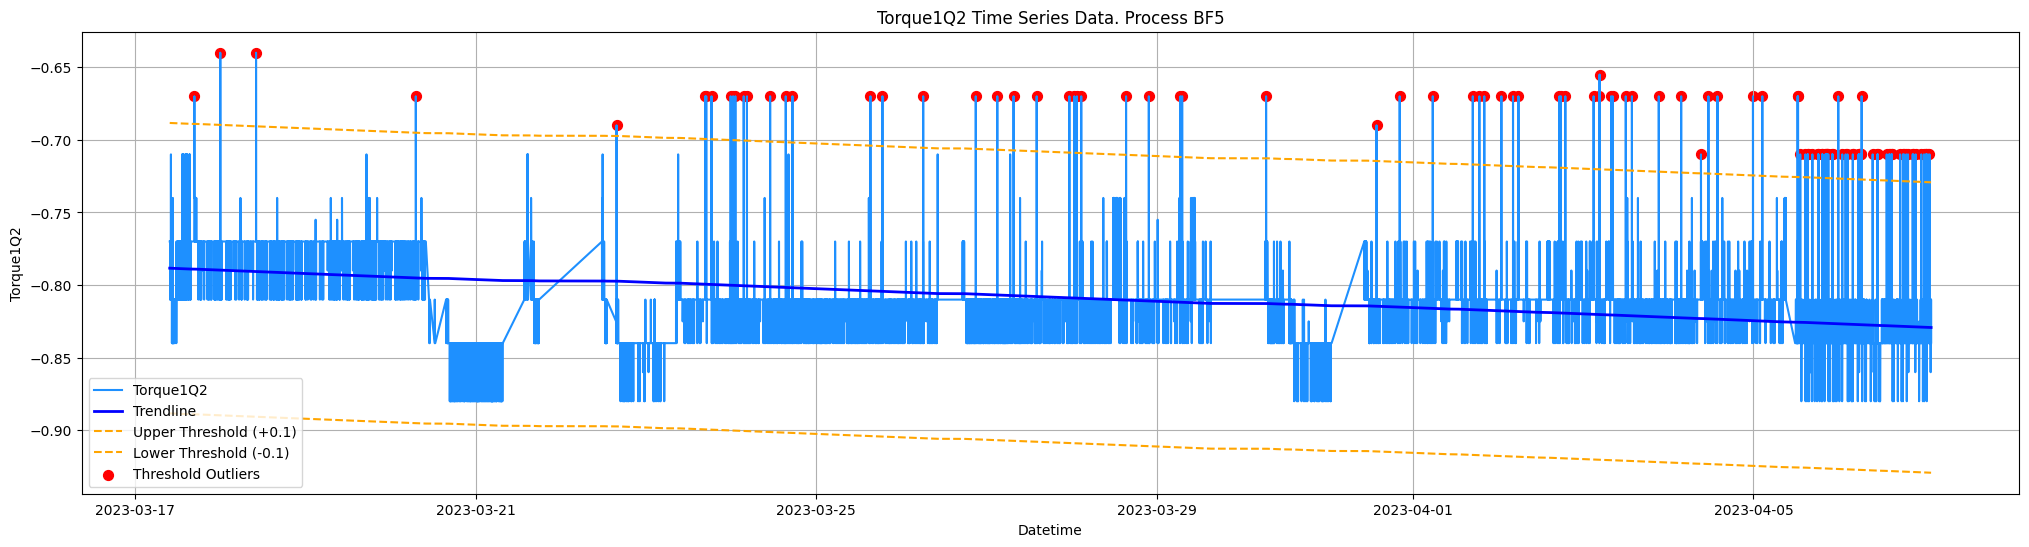

In [ ]:
#filtered_data = data[(data['CurveProcess_top'] == 1) & (data['Process_BF5'] == 1)]
#filtered_data.reset_index(drop=True, inplace=True)

# Fit a linear regression model to the data
X = np.arange(len(filtered_data)).reshape(-1, 1)
y = filtered_data['Torque1Q2'].values
regressor = LinearRegression()
regressor.fit(X, y)
y_pred = regressor.predict(X)

# Calculate upper and lower threshold lines
upper_threshold = y_pred + 0.1
lower_threshold = y_pred - 0.1

# Classify outliers based on the thresholds
upper_outliers = filtered_data[filtered_data['Torque1Q2'] > upper_threshold]
lower_outliers = filtered_data[filtered_data['Torque1Q2'] < lower_threshold]
all_outliers = pd.concat([upper_outliers, lower_outliers])

# Plot the 'Torque1Q2' values
plt.figure(figsize=(25, 6))
plt.plot(filtered_data['Datetime'], filtered_data['Torque1Q2'], label='Torque1Q2', color='dodgerblue')
plt.xlabel('Datetime')
plt.ylabel('Torque1Q2')
plt.title('Torque1Q2 Time Series Data. Process BF5')

# Plot the trendline
plt.plot(filtered_data['Datetime'], y_pred, color='blue', linestyle='-', linewidth=2, label='Trendline')

# Plot upper and lower threshold lines
plt.plot(filtered_data['Datetime'], upper_threshold, color='orange', linestyle='--', label='Upper Threshold (+0.1)')
plt.plot(filtered_data['Datetime'], lower_threshold, color='orange', linestyle='--', label='Lower Threshold (-0.1)')

# Mark upper and lower threshold outliers
plt.scatter(all_outliers['Datetime'], all_outliers['Torque1Q2'], color='red', marker='o', s=50, label='Threshold Outliers')

plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
#filtered_data = data[(data['CurveProcess_top'] == 1) & (data['Process_BF5'] == 1)]
#filtered_data.reset_index(drop=True, inplace=True)
# Create an empty list to store OutlierFrequency values
OutlierFrequency = []

# Iterate through the dataset
for i in range(len(filtered_data)):
    # Consider each sample and its index
    current_sample = filtered_data.iloc[i]
    current_index = current_sample.name

    # Take the last x values (if available)
    x_values=1000
    last_x_samples = filtered_data.iloc[max(0, current_index - (x_values-1)): current_index + 1]

    # Count how many values exceed the upper_threshold or fall below the lower_threshold
    outlet_count = ((last_x_samples['Torque1Q2'] > upper_threshold[current_index]) |
                    (last_x_samples['Torque1Q2'] < lower_threshold[current_index])).sum()

    # Append the count to the OutlierFrequency list
    OutlierFrequency.append(outlet_count)

# Create a new column 'OutlierFrequency' in the dataset
filtered_data.loc[:,'OutlierFrequency'] = OutlierFrequency

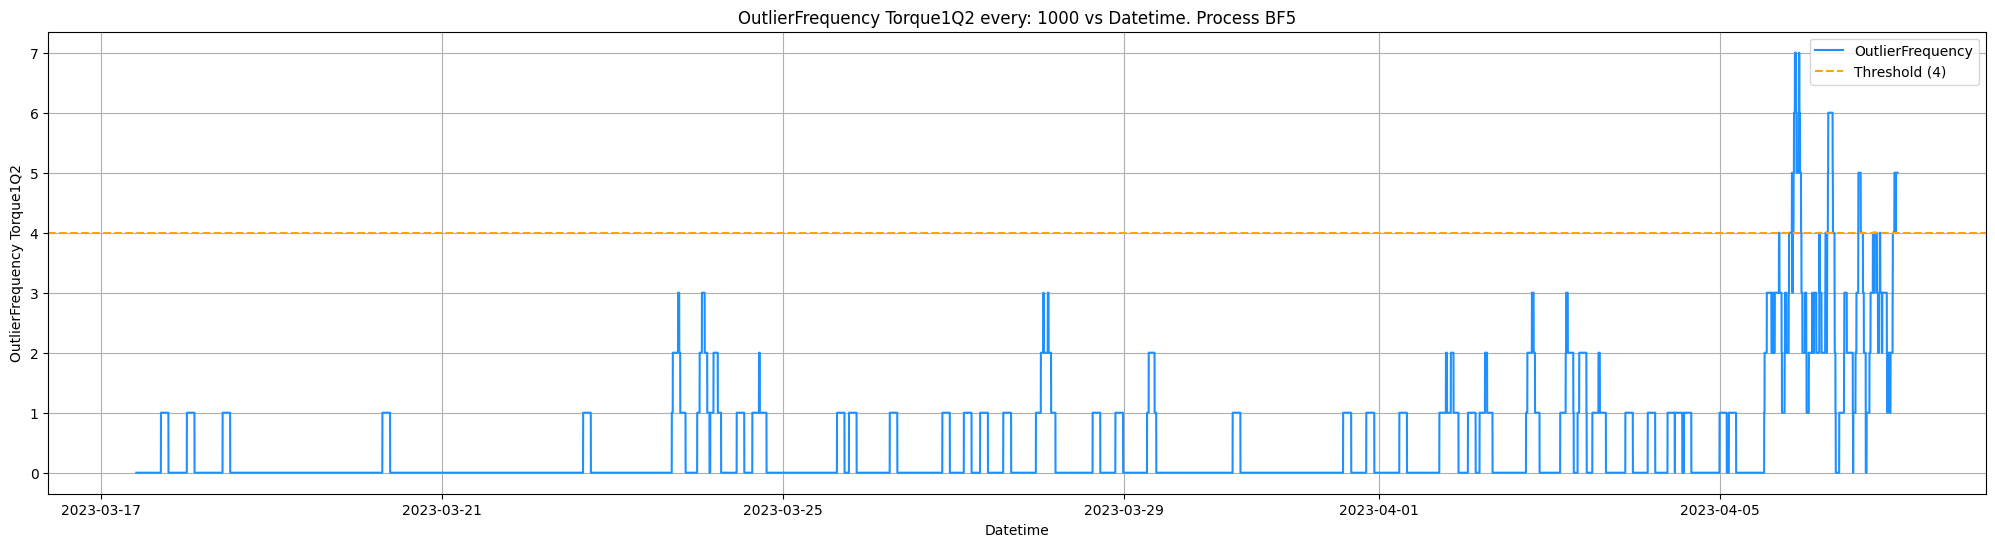

In [ ]:
# Plot 'OutlierFrequency' vs 'Datetime'
plt.figure(figsize=(25, 6))
plt.plot(filtered_data['Datetime'], filtered_data['OutlierFrequency'], label='OutlierFrequency', color='dodgerblue')
plt.axhline(y=4, color='orange', linestyle='--', label='Threshold (4)')
plt.xlabel('Datetime')
plt.ylabel('OutlierFrequency Torque1Q2')
plt.title('OutlierFrequency Torque1Q2 every: '+ str(x_values) + ' vs Datetime. Process BF5')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
filtered_data['OutlierFrequency'].head

<bound method NDFrame.head of 0         0
1         0
2         0
3         0
4         0
         ..
194379    5
194380    5
194381    5
194382    5
194383    5
Name: OutlierFrequency, Length: 194384, dtype: int64>

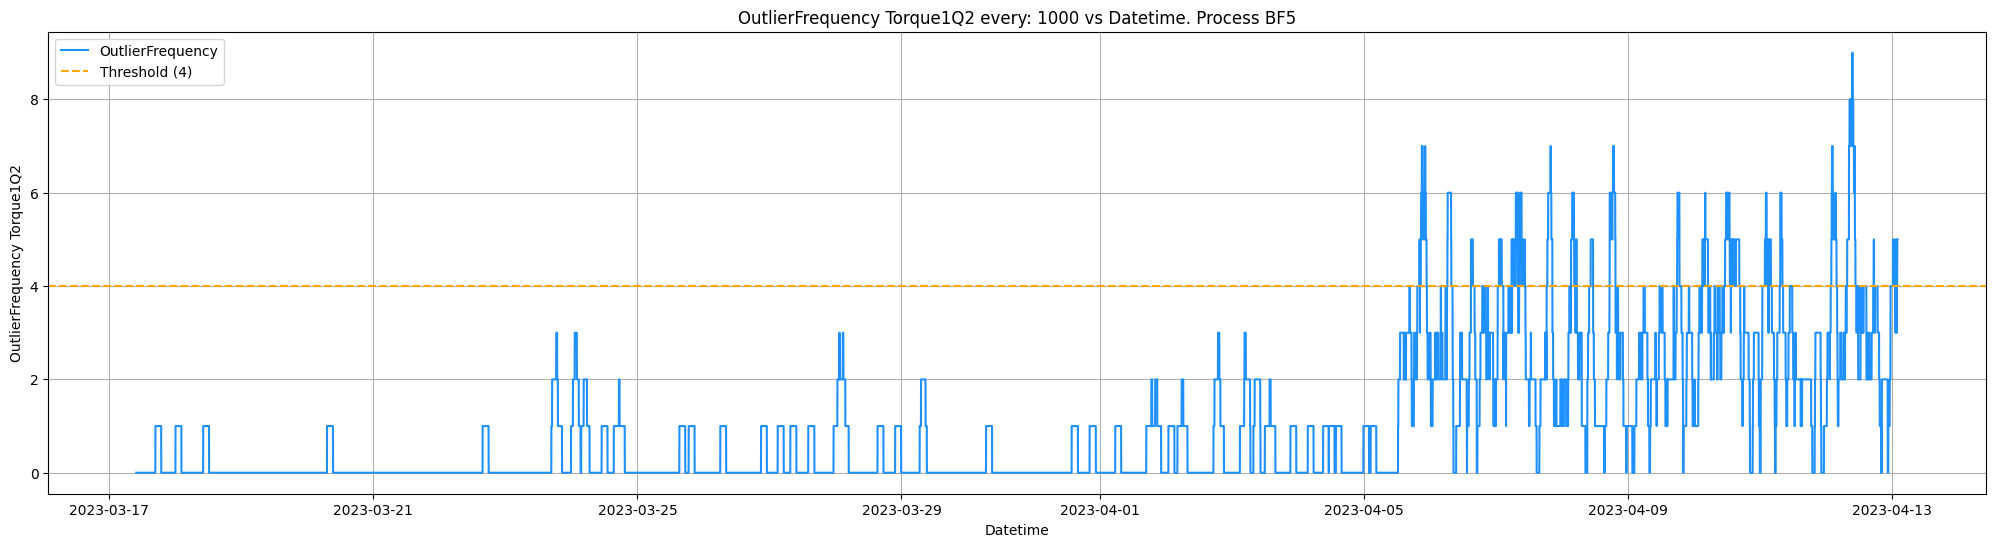

In [ ]:
# Plot 'OutlierFrequency' vs 'Datetime'
plt.figure(figsize=(25, 6))
plt.plot(filtered_data['Datetime'], filtered_data['OutlierFrequency'], label='OutlierFrequency', color='dodgerblue')
plt.axhline(y=4, color='orange', linestyle='--', label='Threshold (4)')
plt.xlabel('Datetime')
plt.ylabel('OutlierFrequency Torque1Q2')
plt.title('OutlierFrequency Torque1Q2 every: '+ str(x_values) + ' vs Datetime. Process BF5')
plt.grid(True)
plt.legend()
plt.show()


## Old things

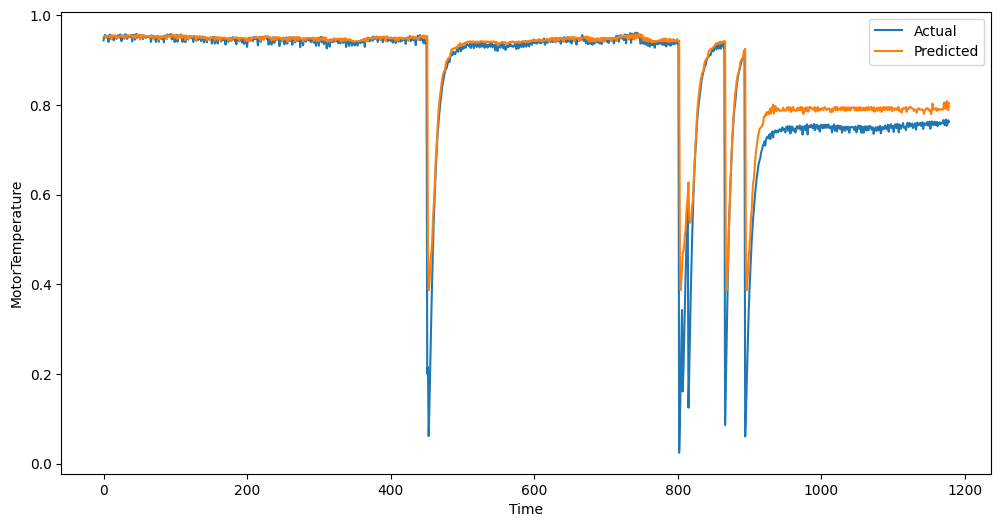

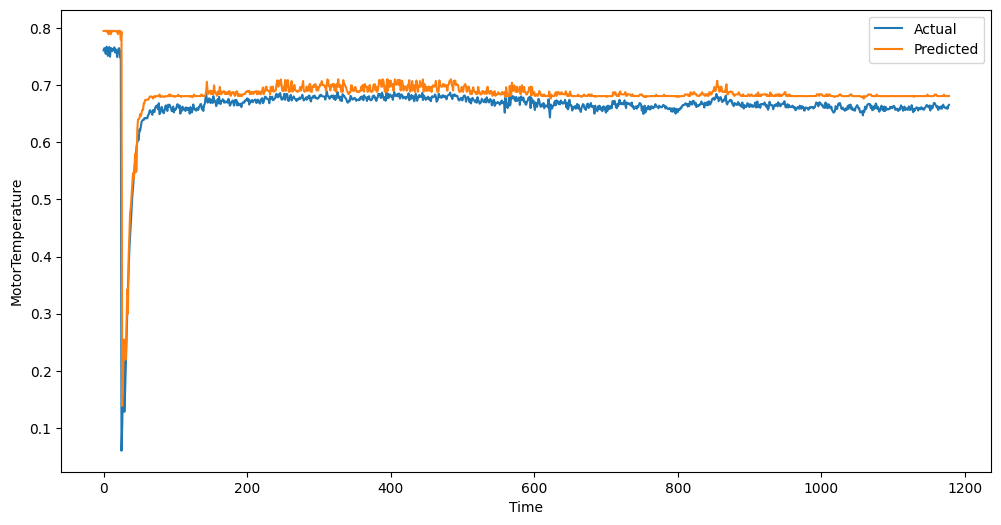

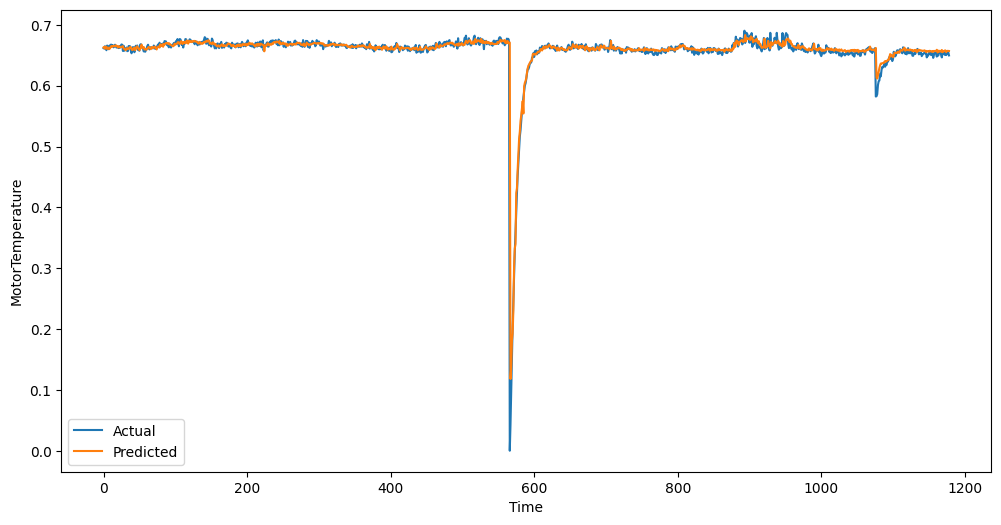

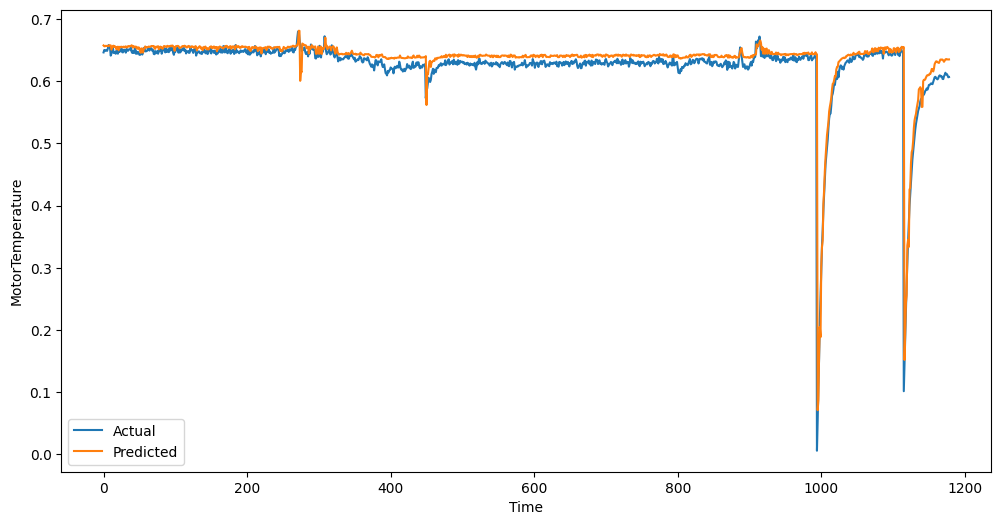

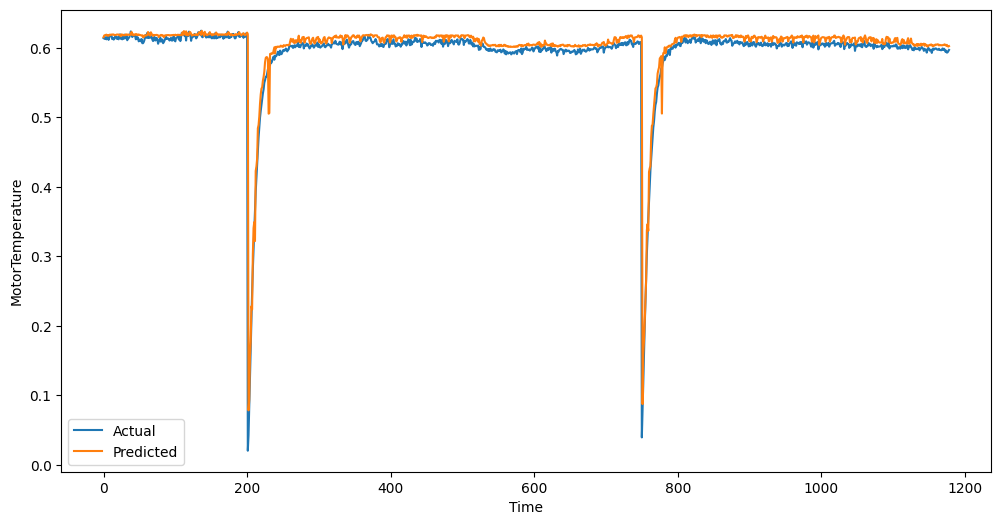

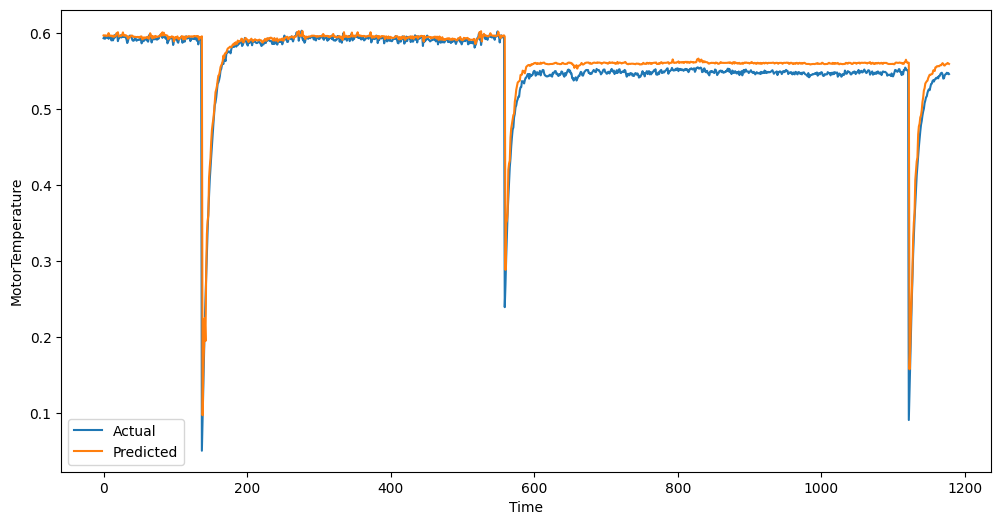

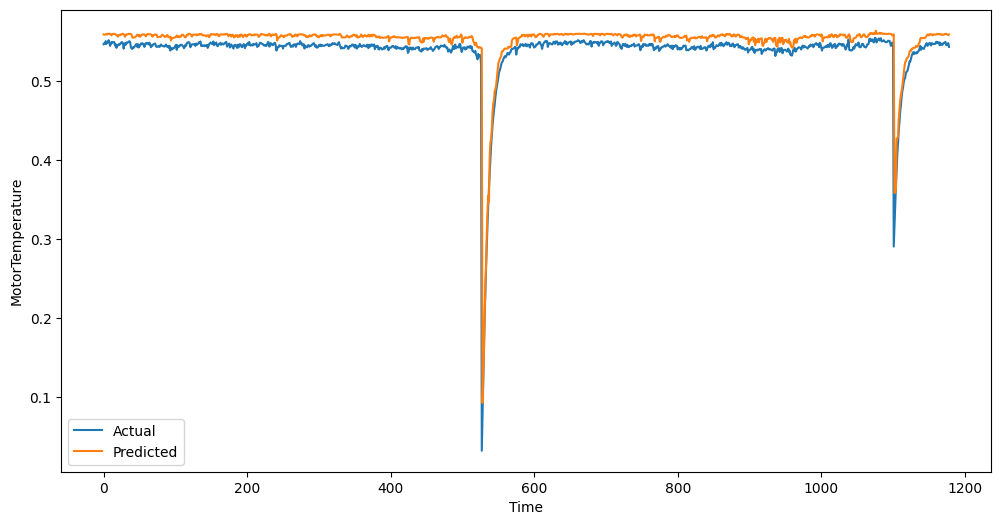

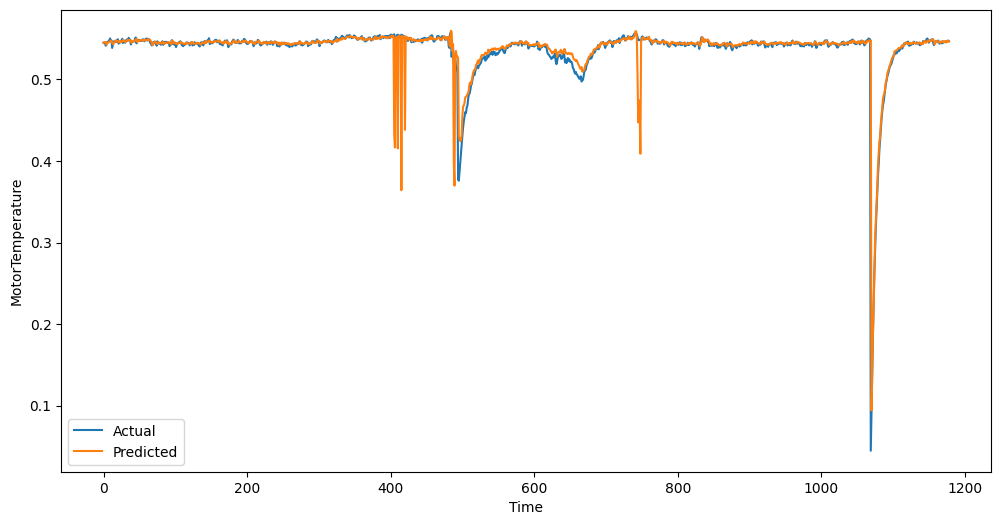

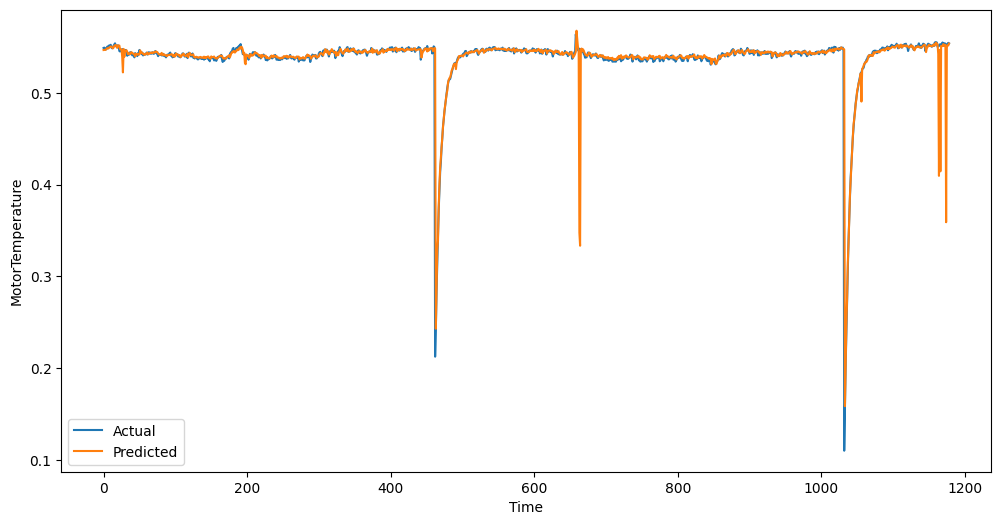

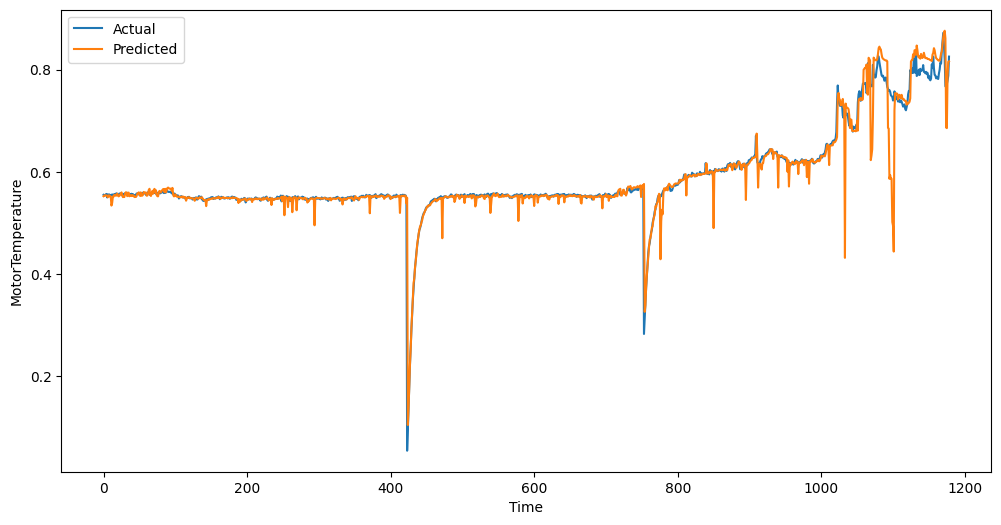

Average MSE across folds: 0.000988911337066409
All MSE Scores: [0.004363789912162773, 0.0008791400698900703, 0.00042055085749834545, 0.0007581528717304685, 0.0006842551122418504, 0.0006551231307973742, 0.00043590381874760364, 0.0004098930383680681, 0.00040162686077941485, 0.0008806776984481207]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'data_filtered_every_20th' is your DataFrame with 'MotorTemperature' and other features

# Step 1: Prepare your data
# Extract the MotorTemperature column and convert it to a NumPy array
motor_temperature = data_filtered_every_20th['MotorTemperature'].values

# Normalize the data
scaler = MinMaxScaler()
motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X, y = [], []
for i in range(len(motor_temperature) - sequence_length):
    X.append(motor_temperature[i:i + sequence_length])
    y.append(motor_temperature[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Flatten the sequences into 2D arrays
X = X.reshape(X.shape[0], -1)  # Flatten sequences into a 2D array

# Split the data using TimeSeriesSplit with 10% for testing
tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits

# Initialize lists to store metrics for each fold (e.g., MSE)
mse_scores = []

# Iterate through the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training data further into training and validation (90% for training, 10% for validation)
    val_size = int(0.1 * len(X_train))
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]

    # Create and train your Random Forest model for this fold
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    model.fit(X_train, y_train.ravel()) #Ravel is to ensure is 1D instead of 2D

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate MSE for this fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('MotorTemperature')
    plt.legend()
    plt.show()

# Calculate and report the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f'Average MSE across folds: {average_mse}')

# Print all values in mse_scores
print("All MSE Scores:", mse_scores)


##Predicting the temperature with LSTM

In [ ]:
data_filtered = data[(data['Process_BF3'] == 1) & (data['CurveProcess_top'] == 1)]
data_filtered = data_filtered.drop('Datetime', axis=1)
print(data_filtered.shape)

data_filtered_every_20th = data_filtered.iloc[::20].reset_index(drop=True)
print(data_filtered_every_20th.shape)

(259601, 28)
(12981, 28)


Epoch 1/20
325/325 - 4s - loss: 3998.0764 - val_loss: 2922.3796 - 4s/epoch - 14ms/step
Epoch 2/20
325/325 - 2s - loss: 2218.5396 - val_loss: 1616.2557 - 2s/epoch - 7ms/step
Epoch 3/20
325/325 - 2s - loss: 1206.7434 - val_loss: 883.3167 - 2s/epoch - 8ms/step
Epoch 4/20
325/325 - 2s - loss: 637.6615 - val_loss: 455.8566 - 2s/epoch - 7ms/step
Epoch 5/20
325/325 - 2s - loss: 333.3916 - val_loss: 250.9989 - 2s/epoch - 7ms/step
Epoch 6/20
325/325 - 2s - loss: 192.9382 - val_loss: 159.8698 - 2s/epoch - 7ms/step
Epoch 7/20
325/325 - 2s - loss: 128.2881 - val_loss: 111.3396 - 2s/epoch - 6ms/step
Epoch 8/20
325/325 - 2s - loss: 91.0928 - val_loss: 81.9389 - 2s/epoch - 7ms/step
Epoch 9/20
325/325 - 2s - loss: 67.1964 - val_loss: 61.9498 - 2s/epoch - 7ms/step
Epoch 10/20
325/325 - 2s - loss: 49.1133 - val_loss: 44.9224 - 2s/epoch - 7ms/step
Epoch 11/20
325/325 - 2s - loss: 34.9045 - val_loss: 32.4064 - 2s/epoch - 7ms/step
Epoch 12/20
325/325 - 2s - loss: 24.0460 - val_loss: 22.9928 - 2s/epoch - 7m

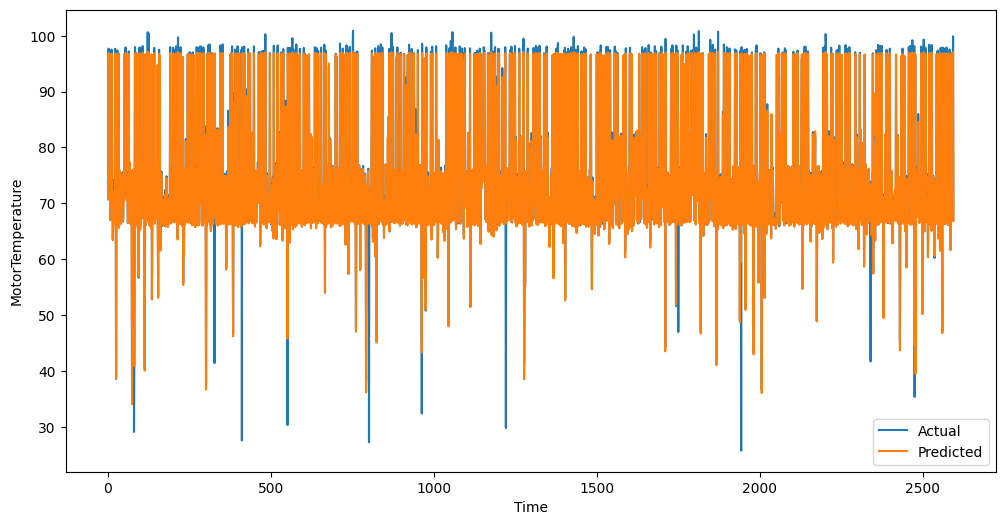

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Assuming 'data' is your DataFrame with 'MotorTemperature' and other features

# Step 1: Prepare your data
# Extract the MotorTemperature column and convert it to a NumPy array
motor_temperature = data_filtered_every_20th['MotorTemperature'].values

# Normalize the data
#scaler = MinMaxScaler()
#motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X, y = [], []
for i in range(len(motor_temperature) - sequence_length):
    X.append(motor_temperature[i:i + sequence_length])
    y.append(motor_temperature[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Create a Keras model with an LSTM layer
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Step 3: Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Step 4: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('MotorTemperature')
plt.legend()
plt.show()


Epoch 1/20
68/68 - 3s - loss: 0.0573 - val_loss: 0.0028 - 3s/epoch - 45ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0049 - val_loss: 0.0031 - 569ms/epoch - 8ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0048 - val_loss: 0.0032 - 697ms/epoch - 10ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0048 - val_loss: 0.0028 - 590ms/epoch - 9ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0047 - val_loss: 0.0029 - 562ms/epoch - 8ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0045 - val_loss: 0.0027 - 581ms/epoch - 9ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0044 - val_loss: 0.0035 - 584ms/epoch - 9ms/step
Epoch 8/20
68/68 - 1s - loss: 0.0043 - val_loss: 0.0031 - 594ms/epoch - 9ms/step
Epoch 9/20
68/68 - 1s - loss: 0.0042 - val_loss: 0.0019 - 724ms/epoch - 11ms/step
Epoch 10/20
68/68 - 1s - loss: 0.0041 - val_loss: 0.0036 - 615ms/epoch - 9ms/step
Epoch 11/20
68/68 - 1s - loss: 0.0038 - val_loss: 0.0021 - 720ms/epoch - 11ms/step
Epoch 12/20
68/68 - 1s - loss: 0.0036 - val_loss: 0.0032 - 610ms/epoch - 9ms/step
Epoch 13/20
68/68 - 1s -

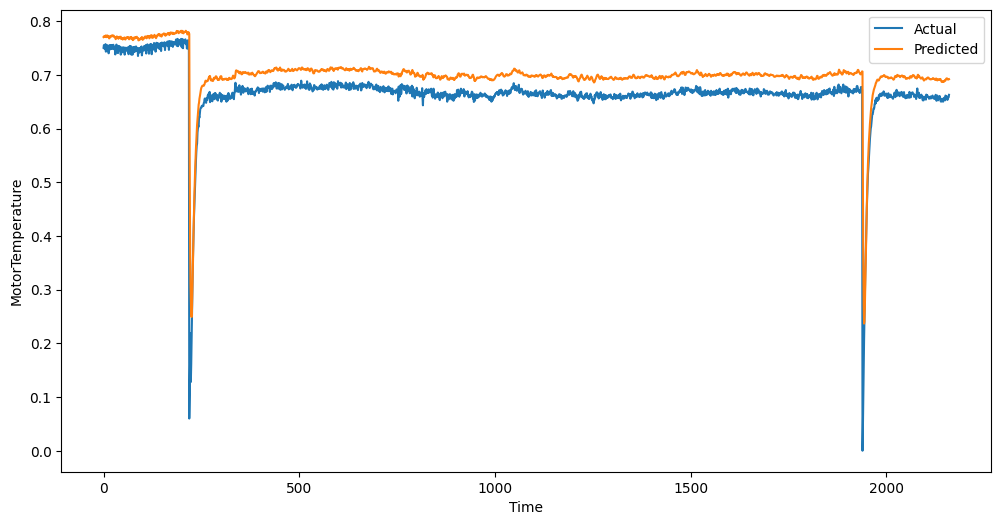

Epoch 1/20
136/136 - 1s - loss: 0.0018 - val_loss: 9.1462e-04 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 1s - loss: 0.0017 - val_loss: 7.8162e-04 - 968ms/epoch - 7ms/step
Epoch 3/20
136/136 - 1s - loss: 0.0016 - val_loss: 7.2267e-04 - 953ms/epoch - 7ms/step
Epoch 4/20
136/136 - 1s - loss: 0.0017 - val_loss: 0.0011 - 1s/epoch - 7ms/step
Epoch 5/20
136/136 - 1s - loss: 0.0017 - val_loss: 7.8438e-04 - 1s/epoch - 8ms/step
Epoch 6/20
136/136 - 1s - loss: 0.0015 - val_loss: 7.3314e-04 - 1s/epoch - 8ms/step
Epoch 7/20
136/136 - 1s - loss: 0.0015 - val_loss: 9.3704e-04 - 1s/epoch - 8ms/step
Epoch 8/20
136/136 - 1s - loss: 0.0015 - val_loss: 7.0678e-04 - 982ms/epoch - 7ms/step
Epoch 9/20
136/136 - 1s - loss: 0.0014 - val_loss: 8.0761e-04 - 1s/epoch - 8ms/step
Epoch 10/20
136/136 - 1s - loss: 0.0014 - val_loss: 7.7778e-04 - 1s/epoch - 9ms/step
Epoch 11/20
136/136 - 1s - loss: 0.0013 - val_loss: 7.2976e-04 - 1s/epoch - 8ms/step
Epoch 12/20
136/136 - 1s - loss: 0.0014 - val_loss: 6.2270e-04 - 1s/e

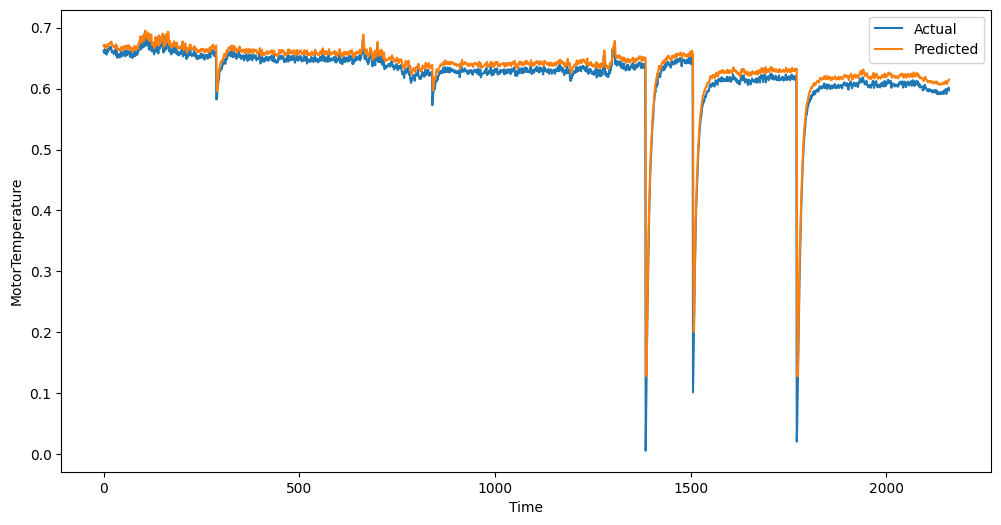

Epoch 1/20
203/203 - 2s - loss: 0.0010 - val_loss: 8.1366e-04 - 2s/epoch - 8ms/step
Epoch 2/20
203/203 - 1s - loss: 0.0010 - val_loss: 5.0188e-04 - 1s/epoch - 7ms/step
Epoch 3/20
203/203 - 1s - loss: 0.0010 - val_loss: 4.7186e-04 - 1s/epoch - 7ms/step
Epoch 4/20
203/203 - 1s - loss: 9.9285e-04 - val_loss: 5.6482e-04 - 1s/epoch - 7ms/step
Epoch 5/20
203/203 - 1s - loss: 9.9045e-04 - val_loss: 5.5987e-04 - 1s/epoch - 7ms/step
Epoch 6/20
203/203 - 1s - loss: 0.0010 - val_loss: 5.5872e-04 - 1s/epoch - 7ms/step
Epoch 7/20
203/203 - 1s - loss: 9.9352e-04 - val_loss: 5.3043e-04 - 1s/epoch - 6ms/step
Epoch 8/20
203/203 - 1s - loss: 0.0010 - val_loss: 5.0736e-04 - 1s/epoch - 7ms/step
Epoch 9/20
203/203 - 1s - loss: 9.7344e-04 - val_loss: 5.1505e-04 - 1s/epoch - 7ms/step
Epoch 10/20
203/203 - 1s - loss: 0.0010 - val_loss: 5.0654e-04 - 1s/epoch - 7ms/step
Epoch 11/20
203/203 - 2s - loss: 9.7470e-04 - val_loss: 5.3823e-04 - 2s/epoch - 8ms/step
Epoch 12/20
203/203 - 1s - loss: 9.7164e-04 - val_loss

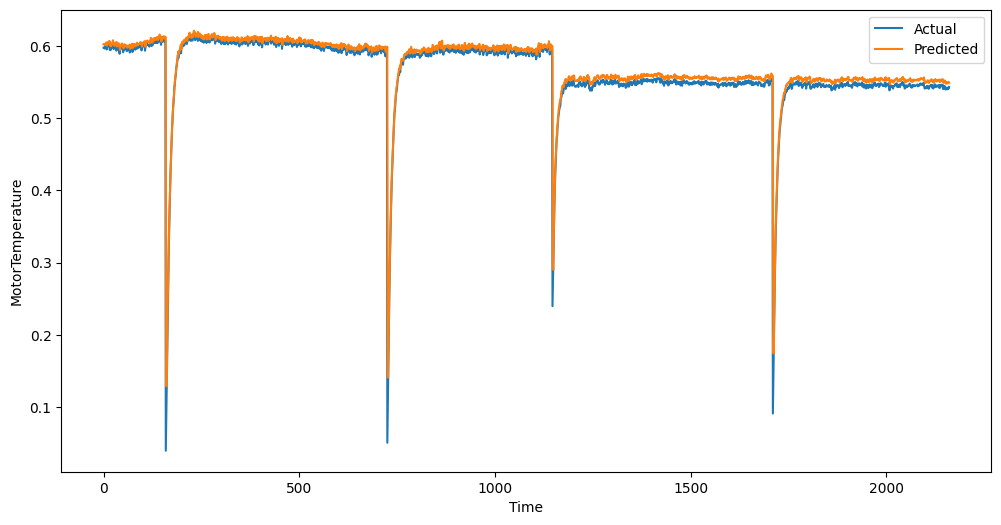

Epoch 1/20
271/271 - 2s - loss: 8.5008e-04 - val_loss: 3.1777e-04 - 2s/epoch - 7ms/step
Epoch 2/20
271/271 - 2s - loss: 8.4458e-04 - val_loss: 3.0235e-04 - 2s/epoch - 7ms/step
Epoch 3/20
271/271 - 2s - loss: 8.6362e-04 - val_loss: 4.1528e-04 - 2s/epoch - 7ms/step
Epoch 4/20
271/271 - 2s - loss: 8.4681e-04 - val_loss: 5.8680e-04 - 2s/epoch - 7ms/step
Epoch 5/20
271/271 - 2s - loss: 8.4985e-04 - val_loss: 2.9046e-04 - 2s/epoch - 7ms/step
Epoch 6/20
271/271 - 2s - loss: 8.4371e-04 - val_loss: 2.7869e-04 - 2s/epoch - 7ms/step
Epoch 7/20
271/271 - 2s - loss: 8.6211e-04 - val_loss: 3.1011e-04 - 2s/epoch - 7ms/step
Epoch 8/20
271/271 - 2s - loss: 8.7368e-04 - val_loss: 3.3971e-04 - 2s/epoch - 7ms/step
Epoch 9/20
271/271 - 2s - loss: 8.5713e-04 - val_loss: 2.8827e-04 - 2s/epoch - 7ms/step
Epoch 10/20
271/271 - 2s - loss: 8.4751e-04 - val_loss: 3.6439e-04 - 2s/epoch - 7ms/step
Epoch 11/20
271/271 - 2s - loss: 8.5500e-04 - val_loss: 3.0932e-04 - 2s/epoch - 7ms/step
Epoch 12/20
271/271 - 2s - los

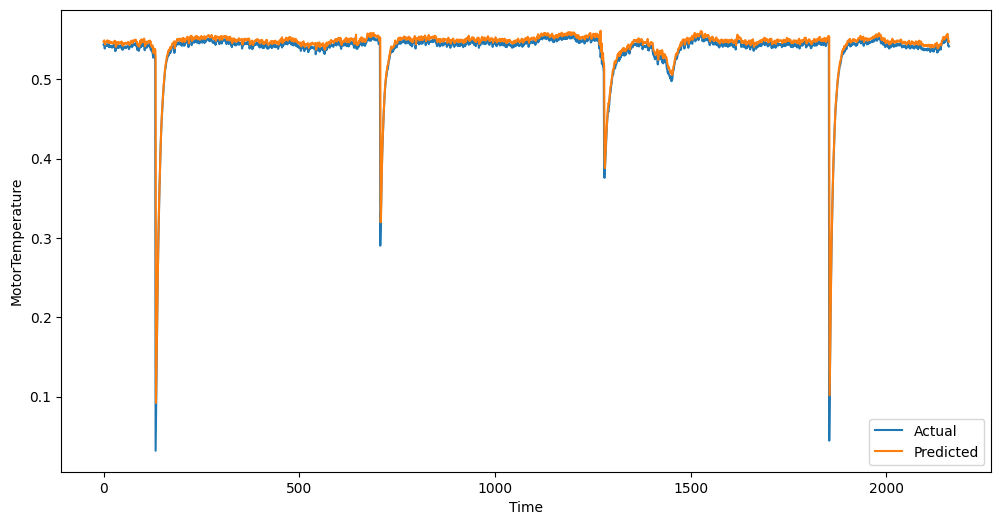

Epoch 1/20
338/338 - 2s - loss: 7.3821e-04 - val_loss: 3.4173e-04 - 2s/epoch - 7ms/step
Epoch 2/20
338/338 - 2s - loss: 7.3791e-04 - val_loss: 3.2942e-04 - 2s/epoch - 7ms/step
Epoch 3/20
338/338 - 2s - loss: 7.2289e-04 - val_loss: 4.1411e-04 - 2s/epoch - 6ms/step
Epoch 4/20
338/338 - 2s - loss: 7.3758e-04 - val_loss: 3.5926e-04 - 2s/epoch - 7ms/step
Epoch 5/20
338/338 - 2s - loss: 7.2534e-04 - val_loss: 3.2106e-04 - 2s/epoch - 7ms/step
Epoch 6/20
338/338 - 2s - loss: 7.2331e-04 - val_loss: 3.2678e-04 - 2s/epoch - 7ms/step
Epoch 7/20
338/338 - 2s - loss: 7.3734e-04 - val_loss: 4.7156e-04 - 2s/epoch - 7ms/step
Epoch 8/20
338/338 - 2s - loss: 7.3025e-04 - val_loss: 3.2052e-04 - 2s/epoch - 6ms/step
Epoch 9/20
338/338 - 2s - loss: 7.2213e-04 - val_loss: 4.4297e-04 - 2s/epoch - 7ms/step
Epoch 10/20
338/338 - 2s - loss: 7.3899e-04 - val_loss: 3.2532e-04 - 2s/epoch - 7ms/step
Epoch 11/20
338/338 - 2s - loss: 7.3003e-04 - val_loss: 3.3831e-04 - 2s/epoch - 7ms/step
Epoch 12/20
338/338 - 2s - los

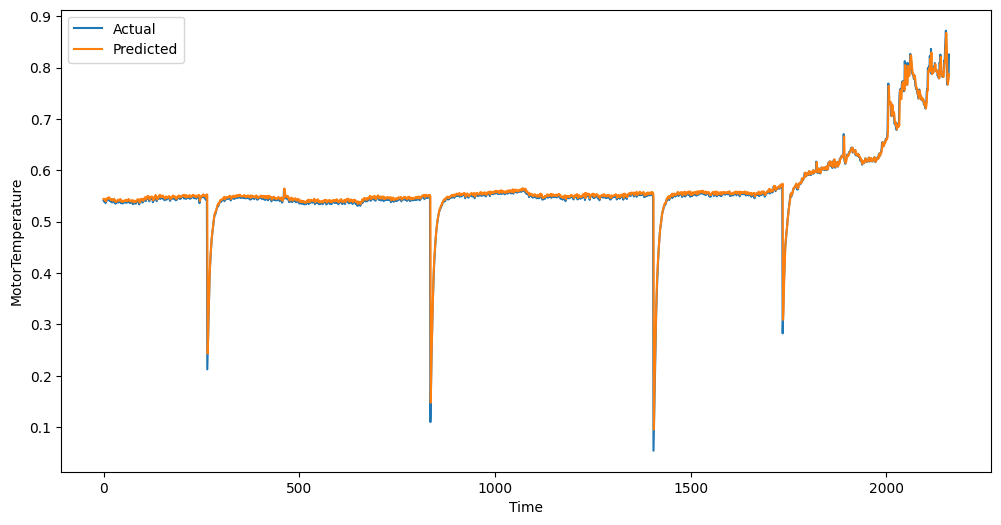

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'data_filtered_every_20th' is your DataFrame with 'MotorTemperature' and other features

# Step 1: Prepare your data
# Extract the MotorTemperature column and convert it to a NumPy array
motor_temperature = data_filtered_every_20th['MotorTemperature'].values

# Normalize the data
scaler = MinMaxScaler()
motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X, y = [], []
for i in range(len(motor_temperature) - sequence_length):
    X.append(motor_temperature[i:i + sequence_length])
    y.append(motor_temperature[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits

# Step 2: Create a Keras model with an LSTM layer
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Step 3: Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Step 4: Train the model using TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

    # Step 5: Make predictions for this fold
    y_pred = model.predict(X_test)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('MotorTemperature')
    plt.legend()
    plt.show()


Epoch 1/20
34/34 - 3s - loss: 0.2816 - val_loss: 1.9025e-04 - 3s/epoch - 88ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0047 - val_loss: 1.3382e-04 - 254ms/epoch - 7ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0018 - val_loss: 3.6017e-05 - 266ms/epoch - 8ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0018 - val_loss: 2.8415e-05 - 253ms/epoch - 7ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0018 - val_loss: 8.1717e-05 - 248ms/epoch - 7ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0017 - val_loss: 2.2495e-05 - 255ms/epoch - 8ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0017 - val_loss: 5.7582e-05 - 265ms/epoch - 8ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0017 - val_loss: 3.3305e-05 - 277ms/epoch - 8ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0017 - val_loss: 7.0259e-05 - 265ms/epoch - 8ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0017 - val_loss: 5.1333e-05 - 263ms/epoch - 8ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0017 - val_loss: 9.2670e-05 - 246ms/epoch - 7ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0017 - val_loss: 9.7883e-05 - 25

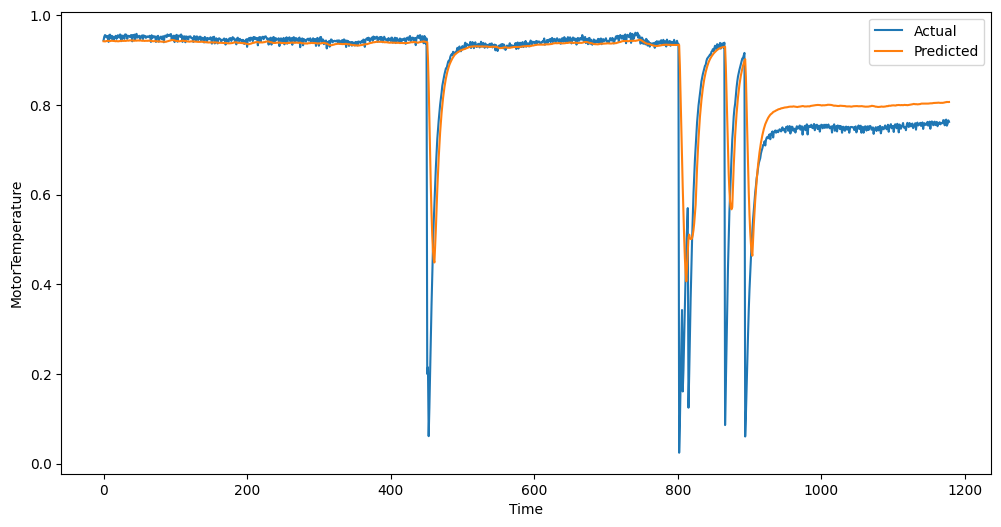

Epoch 1/20
67/67 - 3s - loss: 0.1674 - val_loss: 0.0057 - 3s/epoch - 46ms/step
Epoch 2/20
67/67 - 0s - loss: 0.0058 - val_loss: 0.0021 - 500ms/epoch - 7ms/step
Epoch 3/20
67/67 - 0s - loss: 0.0056 - val_loss: 0.0012 - 460ms/epoch - 7ms/step
Epoch 4/20
67/67 - 0s - loss: 0.0056 - val_loss: 0.0031 - 457ms/epoch - 7ms/step
Epoch 5/20
67/67 - 0s - loss: 0.0055 - val_loss: 0.0016 - 451ms/epoch - 7ms/step
Epoch 6/20
67/67 - 1s - loss: 0.0054 - val_loss: 0.0026 - 549ms/epoch - 8ms/step
Epoch 7/20
67/67 - 1s - loss: 0.0054 - val_loss: 0.0030 - 605ms/epoch - 9ms/step
Epoch 8/20
67/67 - 1s - loss: 0.0052 - val_loss: 0.0012 - 572ms/epoch - 9ms/step
Epoch 9/20
67/67 - 0s - loss: 0.0051 - val_loss: 0.0019 - 447ms/epoch - 7ms/step
Epoch 10/20
67/67 - 0s - loss: 0.0049 - val_loss: 0.0014 - 439ms/epoch - 7ms/step
Epoch 11/20
67/67 - 0s - loss: 0.0048 - val_loss: 6.4909e-04 - 446ms/epoch - 7ms/step
Epoch 12/20
67/67 - 0s - loss: 0.0048 - val_loss: 0.0014 - 446ms/epoch - 7ms/step
Epoch 13/20
67/67 - 0s 

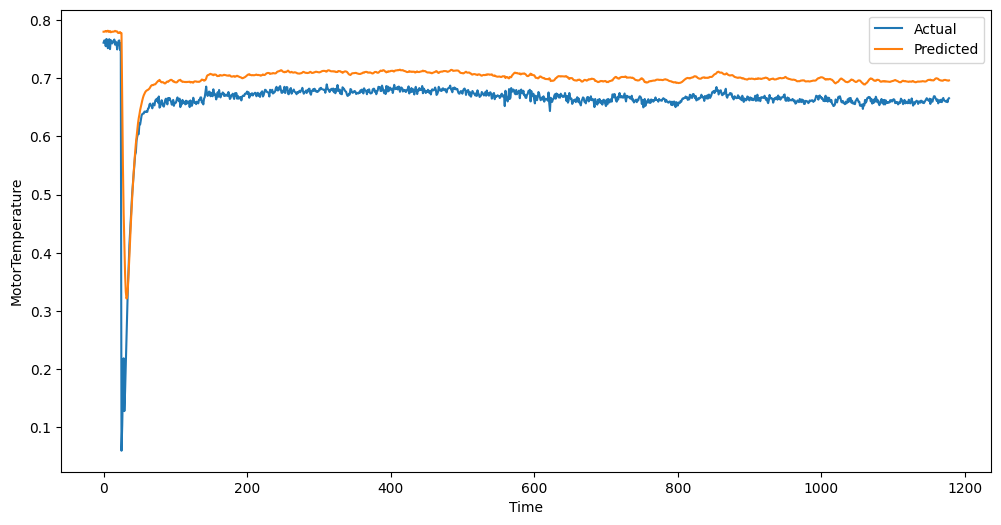

Epoch 1/20
100/100 - 4s - loss: 0.0209 - val_loss: 8.5405e-04 - 4s/epoch - 39ms/step
Epoch 2/20
100/100 - 1s - loss: 0.0035 - val_loss: 5.5025e-04 - 633ms/epoch - 6ms/step
Epoch 3/20
100/100 - 1s - loss: 0.0033 - val_loss: 2.2340e-04 - 652ms/epoch - 7ms/step
Epoch 4/20
100/100 - 1s - loss: 0.0032 - val_loss: 1.8741e-04 - 658ms/epoch - 7ms/step
Epoch 5/20
100/100 - 1s - loss: 0.0030 - val_loss: 5.3795e-04 - 649ms/epoch - 6ms/step
Epoch 6/20
100/100 - 1s - loss: 0.0029 - val_loss: 1.8815e-05 - 666ms/epoch - 7ms/step
Epoch 7/20
100/100 - 1s - loss: 0.0028 - val_loss: 1.0132e-04 - 645ms/epoch - 6ms/step
Epoch 8/20
100/100 - 1s - loss: 0.0027 - val_loss: 8.0531e-05 - 645ms/epoch - 6ms/step
Epoch 9/20
100/100 - 1s - loss: 0.0025 - val_loss: 1.3507e-05 - 648ms/epoch - 6ms/step
Epoch 10/20
100/100 - 1s - loss: 0.0024 - val_loss: 2.9014e-05 - 633ms/epoch - 6ms/step
Epoch 11/20
100/100 - 1s - loss: 0.0023 - val_loss: 4.4872e-05 - 639ms/epoch - 6ms/step
Epoch 12/20
100/100 - 1s - loss: 0.0023 - v

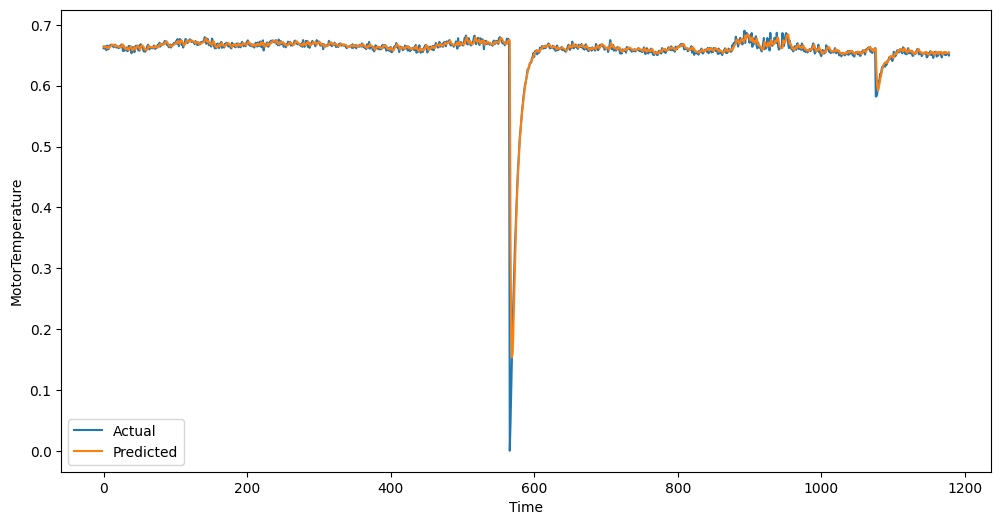

Epoch 1/20
133/133 - 3s - loss: 0.0416 - val_loss: 8.6959e-04 - 3s/epoch - 26ms/step
Epoch 2/20
133/133 - 1s - loss: 0.0032 - val_loss: 5.6963e-05 - 943ms/epoch - 7ms/step
Epoch 3/20
133/133 - 1s - loss: 0.0029 - val_loss: 2.2009e-04 - 924ms/epoch - 7ms/step
Epoch 4/20
133/133 - 1s - loss: 0.0028 - val_loss: 1.0174e-04 - 915ms/epoch - 7ms/step
Epoch 5/20
133/133 - 1s - loss: 0.0027 - val_loss: 5.3494e-05 - 868ms/epoch - 7ms/step
Epoch 6/20
133/133 - 1s - loss: 0.0026 - val_loss: 4.8536e-04 - 900ms/epoch - 7ms/step
Epoch 7/20
133/133 - 1s - loss: 0.0024 - val_loss: 5.0917e-05 - 991ms/epoch - 7ms/step
Epoch 8/20
133/133 - 1s - loss: 0.0024 - val_loss: 4.9701e-05 - 962ms/epoch - 7ms/step
Epoch 9/20
133/133 - 1s - loss: 0.0022 - val_loss: 6.1193e-05 - 941ms/epoch - 7ms/step
Epoch 10/20
133/133 - 1s - loss: 0.0022 - val_loss: 6.0441e-05 - 943ms/epoch - 7ms/step
Epoch 11/20
133/133 - 1s - loss: 0.0021 - val_loss: 1.1239e-04 - 845ms/epoch - 6ms/step
Epoch 12/20
133/133 - 1s - loss: 0.0019 - v

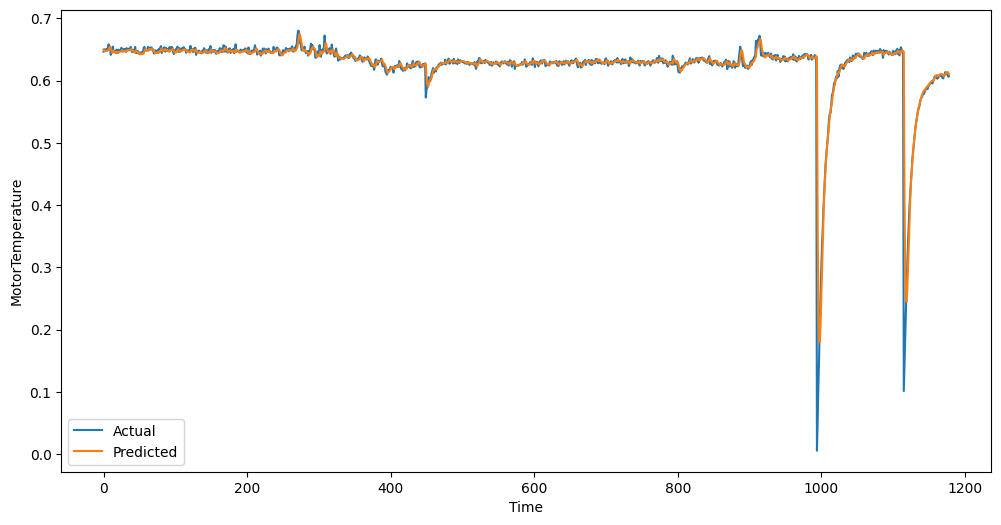

Epoch 1/20
166/166 - 4s - loss: 0.0299 - val_loss: 0.0037 - 4s/epoch - 22ms/step
Epoch 2/20
166/166 - 1s - loss: 0.0029 - val_loss: 0.0035 - 1s/epoch - 6ms/step
Epoch 3/20
166/166 - 1s - loss: 0.0027 - val_loss: 0.0032 - 1s/epoch - 7ms/step
Epoch 4/20
166/166 - 1s - loss: 0.0025 - val_loss: 0.0031 - 1s/epoch - 7ms/step
Epoch 5/20
166/166 - 1s - loss: 0.0024 - val_loss: 0.0029 - 1s/epoch - 7ms/step
Epoch 6/20
166/166 - 1s - loss: 0.0023 - val_loss: 0.0030 - 1s/epoch - 8ms/step
Epoch 7/20
166/166 - 2s - loss: 0.0022 - val_loss: 0.0029 - 2s/epoch - 10ms/step
Epoch 8/20
166/166 - 2s - loss: 0.0021 - val_loss: 0.0025 - 2s/epoch - 9ms/step
Epoch 9/20
166/166 - 1s - loss: 0.0019 - val_loss: 0.0023 - 1s/epoch - 7ms/step
Epoch 10/20
166/166 - 1s - loss: 0.0019 - val_loss: 0.0023 - 1s/epoch - 7ms/step
Epoch 11/20
166/166 - 1s - loss: 0.0017 - val_loss: 0.0027 - 1s/epoch - 6ms/step
Epoch 12/20
166/166 - 1s - loss: 0.0016 - val_loss: 0.0026 - 1s/epoch - 7ms/step
Epoch 13/20
166/166 - 1s - loss: 0.

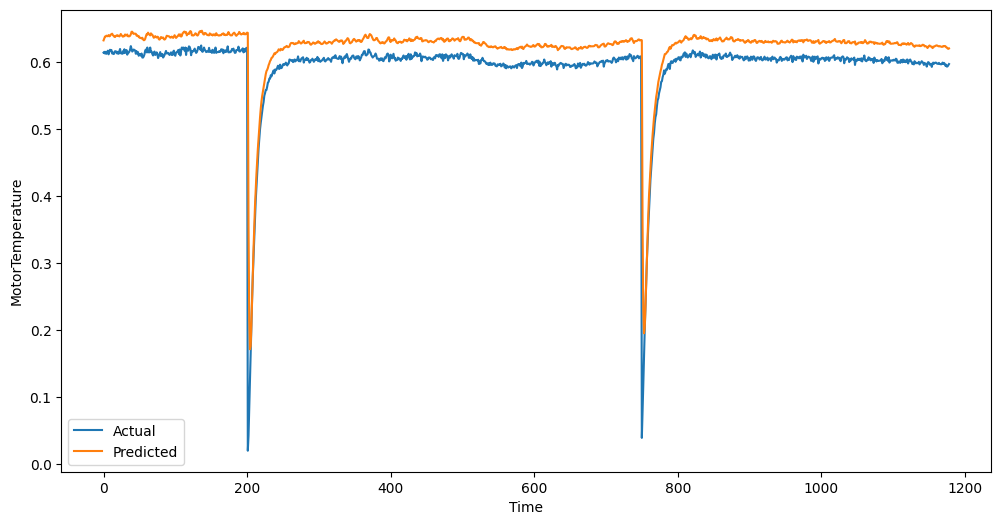

Epoch 1/20
200/200 - 4s - loss: 0.0276 - val_loss: 0.0014 - 4s/epoch - 20ms/step
Epoch 2/20
200/200 - 1s - loss: 0.0029 - val_loss: 0.0018 - 1s/epoch - 7ms/step
Epoch 3/20
200/200 - 1s - loss: 0.0027 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 4/20
200/200 - 1s - loss: 0.0025 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 5/20
200/200 - 2s - loss: 0.0024 - val_loss: 0.0013 - 2s/epoch - 8ms/step
Epoch 6/20
200/200 - 1s - loss: 0.0022 - val_loss: 0.0011 - 1s/epoch - 7ms/step
Epoch 7/20
200/200 - 1s - loss: 0.0020 - val_loss: 0.0010 - 1s/epoch - 7ms/step
Epoch 8/20
200/200 - 1s - loss: 0.0018 - val_loss: 9.6209e-04 - 1s/epoch - 7ms/step
Epoch 9/20
200/200 - 1s - loss: 0.0017 - val_loss: 8.4351e-04 - 1s/epoch - 7ms/step
Epoch 10/20
200/200 - 1s - loss: 0.0016 - val_loss: 0.0014 - 1s/epoch - 7ms/step
Epoch 11/20
200/200 - 1s - loss: 0.0016 - val_loss: 7.9384e-04 - 1s/epoch - 7ms/step
Epoch 12/20
200/200 - 1s - loss: 0.0015 - val_loss: 7.2789e-04 - 1s/epoch - 7ms/step
Epoch 13/20
200/200 

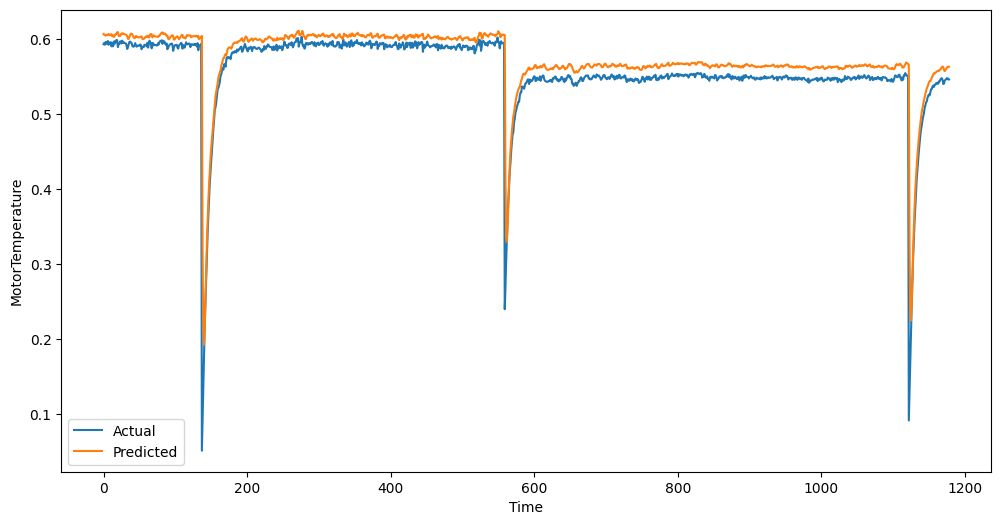

Epoch 1/20
233/233 - 4s - loss: 0.0132 - val_loss: 0.0013 - 4s/epoch - 17ms/step
Epoch 2/20
233/233 - 2s - loss: 0.0025 - val_loss: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/20
233/233 - 1s - loss: 0.0023 - val_loss: 9.3869e-04 - 1s/epoch - 6ms/step
Epoch 4/20
233/233 - 1s - loss: 0.0021 - val_loss: 8.7555e-04 - 1s/epoch - 6ms/step
Epoch 5/20
233/233 - 2s - loss: 0.0019 - val_loss: 8.0209e-04 - 2s/epoch - 7ms/step
Epoch 6/20
233/233 - 2s - loss: 0.0018 - val_loss: 8.2066e-04 - 2s/epoch - 7ms/step
Epoch 7/20
233/233 - 2s - loss: 0.0017 - val_loss: 7.0660e-04 - 2s/epoch - 7ms/step
Epoch 8/20
233/233 - 1s - loss: 0.0016 - val_loss: 8.3399e-04 - 1s/epoch - 6ms/step
Epoch 9/20
233/233 - 1s - loss: 0.0015 - val_loss: 6.4501e-04 - 1s/epoch - 6ms/step
Epoch 10/20
233/233 - 1s - loss: 0.0014 - val_loss: 8.4662e-04 - 1s/epoch - 6ms/step
Epoch 11/20
233/233 - 2s - loss: 0.0013 - val_loss: 6.8676e-04 - 2s/epoch - 7ms/step
Epoch 12/20
233/233 - 2s - loss: 0.0012 - val_loss: 5.8660e-04 - 2s/epoch - 7ms/s

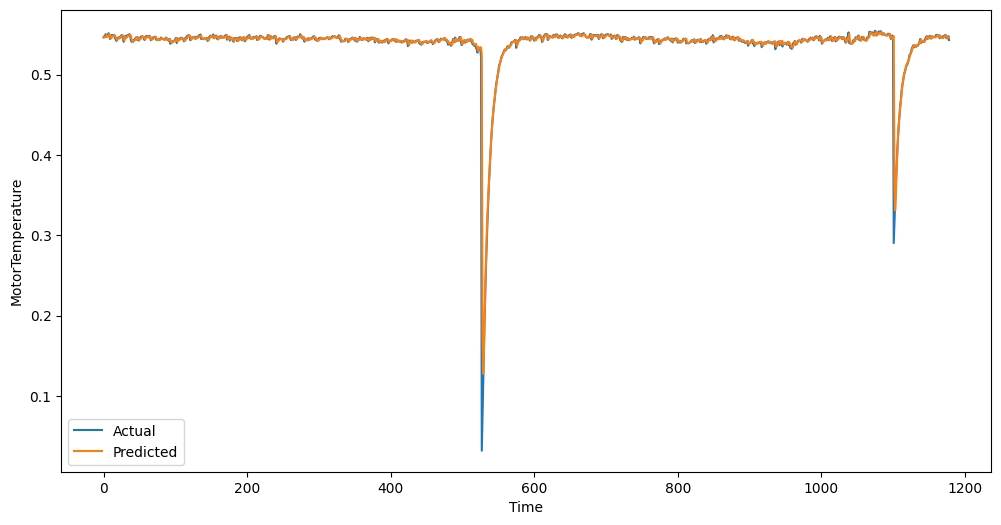

Epoch 1/20
266/266 - 4s - loss: 0.0139 - val_loss: 0.0011 - 4s/epoch - 16ms/step
Epoch 2/20
266/266 - 2s - loss: 0.0023 - val_loss: 8.9719e-04 - 2s/epoch - 7ms/step
Epoch 3/20
266/266 - 2s - loss: 0.0021 - val_loss: 7.9659e-04 - 2s/epoch - 6ms/step
Epoch 4/20
266/266 - 2s - loss: 0.0019 - val_loss: 7.3885e-04 - 2s/epoch - 7ms/step
Epoch 5/20
266/266 - 2s - loss: 0.0017 - val_loss: 6.6537e-04 - 2s/epoch - 7ms/step
Epoch 6/20
266/266 - 2s - loss: 0.0015 - val_loss: 5.8603e-04 - 2s/epoch - 6ms/step
Epoch 7/20
266/266 - 2s - loss: 0.0015 - val_loss: 6.2728e-04 - 2s/epoch - 6ms/step
Epoch 8/20
266/266 - 2s - loss: 0.0014 - val_loss: 6.7511e-04 - 2s/epoch - 6ms/step
Epoch 9/20
266/266 - 2s - loss: 0.0013 - val_loss: 6.2721e-04 - 2s/epoch - 6ms/step
Epoch 10/20
266/266 - 2s - loss: 0.0012 - val_loss: 6.0790e-04 - 2s/epoch - 6ms/step
Epoch 11/20
266/266 - 2s - loss: 0.0012 - val_loss: 4.3297e-04 - 2s/epoch - 7ms/step
Epoch 12/20
266/266 - 2s - loss: 0.0011 - val_loss: 4.4348e-04 - 2s/epoch - 6

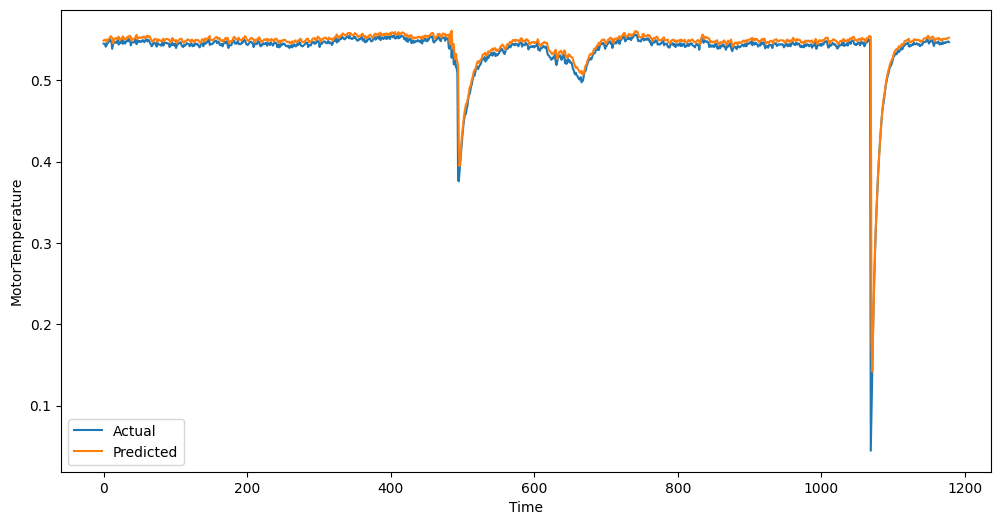

Epoch 1/20
299/299 - 4s - loss: 0.0126 - val_loss: 7.5849e-04 - 4s/epoch - 14ms/step
Epoch 2/20
299/299 - 2s - loss: 0.0022 - val_loss: 7.5327e-04 - 2s/epoch - 6ms/step
Epoch 3/20
299/299 - 2s - loss: 0.0020 - val_loss: 6.7929e-04 - 2s/epoch - 6ms/step
Epoch 4/20
299/299 - 2s - loss: 0.0018 - val_loss: 6.7481e-04 - 2s/epoch - 6ms/step
Epoch 5/20
299/299 - 2s - loss: 0.0016 - val_loss: 5.4678e-04 - 2s/epoch - 7ms/step
Epoch 6/20
299/299 - 2s - loss: 0.0014 - val_loss: 5.0990e-04 - 2s/epoch - 6ms/step
Epoch 7/20
299/299 - 2s - loss: 0.0013 - val_loss: 4.3470e-04 - 2s/epoch - 6ms/step
Epoch 8/20
299/299 - 2s - loss: 0.0012 - val_loss: 3.7919e-04 - 2s/epoch - 6ms/step
Epoch 9/20
299/299 - 2s - loss: 0.0011 - val_loss: 4.1916e-04 - 2s/epoch - 6ms/step
Epoch 10/20
299/299 - 2s - loss: 0.0010 - val_loss: 4.6889e-04 - 2s/epoch - 6ms/step
Epoch 11/20
299/299 - 2s - loss: 9.7787e-04 - val_loss: 3.5002e-04 - 2s/epoch - 6ms/step
Epoch 12/20
299/299 - 2s - loss: 9.5539e-04 - val_loss: 3.4439e-04 - 

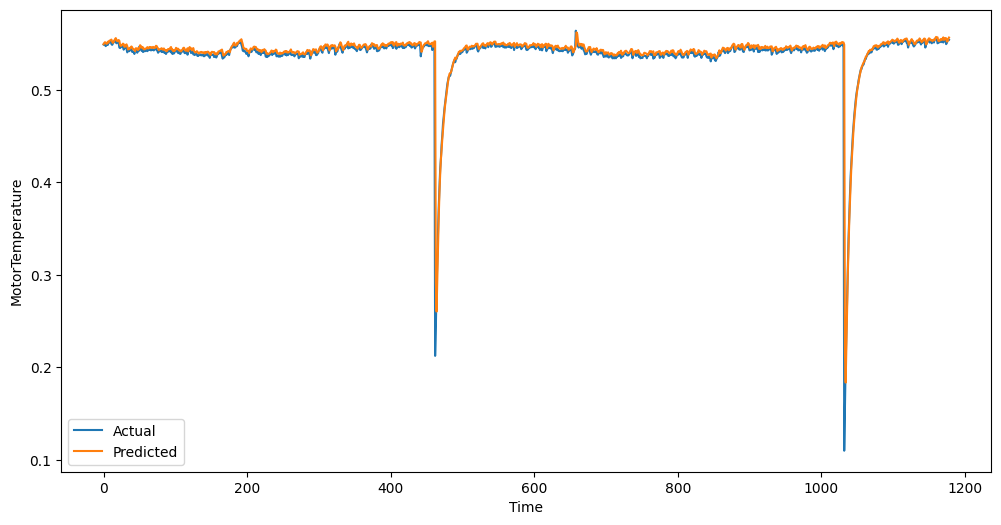

Epoch 1/20
332/332 - 5s - loss: 0.0112 - val_loss: 7.8362e-04 - 5s/epoch - 14ms/step
Epoch 2/20
332/332 - 2s - loss: 0.0020 - val_loss: 6.2376e-04 - 2s/epoch - 6ms/step
Epoch 3/20
332/332 - 2s - loss: 0.0018 - val_loss: 8.4930e-04 - 2s/epoch - 6ms/step
Epoch 4/20
332/332 - 2s - loss: 0.0016 - val_loss: 5.5602e-04 - 2s/epoch - 6ms/step
Epoch 5/20
332/332 - 2s - loss: 0.0015 - val_loss: 5.7822e-04 - 2s/epoch - 6ms/step
Epoch 6/20
332/332 - 2s - loss: 0.0013 - val_loss: 4.2533e-04 - 2s/epoch - 6ms/step
Epoch 7/20
332/332 - 2s - loss: 0.0012 - val_loss: 4.8725e-04 - 2s/epoch - 6ms/step
Epoch 8/20
332/332 - 2s - loss: 0.0011 - val_loss: 3.7923e-04 - 2s/epoch - 6ms/step
Epoch 9/20
332/332 - 2s - loss: 0.0010 - val_loss: 3.3578e-04 - 2s/epoch - 7ms/step
Epoch 10/20
332/332 - 2s - loss: 9.7517e-04 - val_loss: 6.2725e-04 - 2s/epoch - 6ms/step
Epoch 11/20
332/332 - 2s - loss: 9.0299e-04 - val_loss: 3.1056e-04 - 2s/epoch - 6ms/step
Epoch 12/20
332/332 - 2s - loss: 8.5035e-04 - val_loss: 3.4423e-0

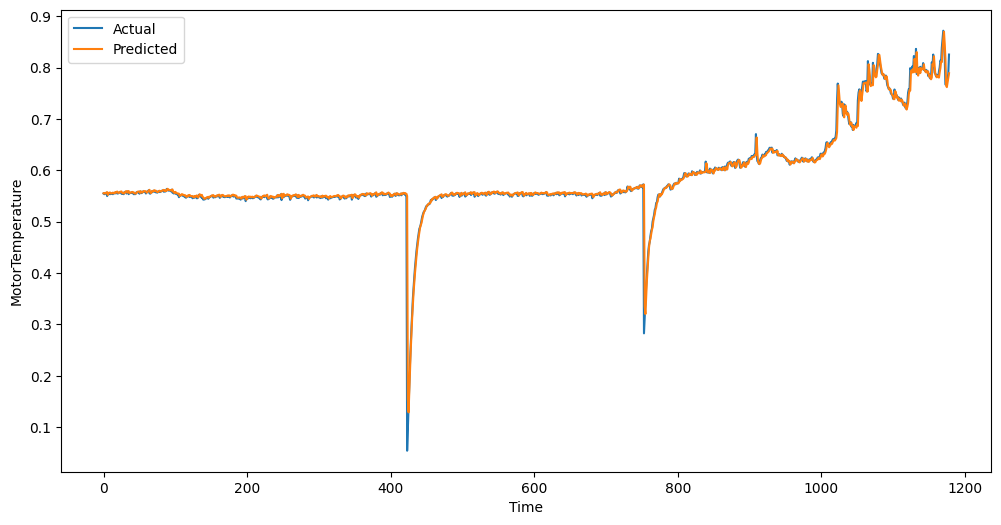

Average MSE across folds: 0.001563350659108369
All MSE Scores: [0.008778519004987202, 0.0020983742362850667, 0.0005092848145793197, 0.000788721539000566, 0.0014352157566509657, 0.0008614519344871373, 0.0002791307663981095, 0.00027501235031368706, 0.0002781113197150041, 0.0003296848686666334]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'data_filtered_every_20th' is your DataFrame with 'MotorTemperature' and other features

# Step 1: Prepare your data
# Extract the MotorTemperature column and convert it to a NumPy array
motor_temperature = data_filtered_every_20th['MotorTemperature'].values

# Normalize the data
scaler = MinMaxScaler()
motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X, y = [], []
for i in range(len(motor_temperature) - sequence_length):
    X.append(motor_temperature[i:i + sequence_length])
    y.append(motor_temperature[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data using TimeSeriesSplit with 10% for testing
tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits

# Initialize lists to store metrics for each fold (e.g., MSE)
mse_scores = []

# Iterate through the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training data further into training and validation (90% for training, 10% for validation)
    val_size = int(0.1 * len(X_train))
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]

    # Create and train your LSTM model for this fold
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

    # Evaluate the model on the test data and calculate MSE
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    mse_scores.append(mse)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('MotorTemperature')
    plt.legend()
    plt.show()

# Calculate and report the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f'Average MSE across folds: {average_mse}')

# Print all values in mse_scores
print("All MSE Scores:", mse_scores)


##Predicting the temperature with Random Forest

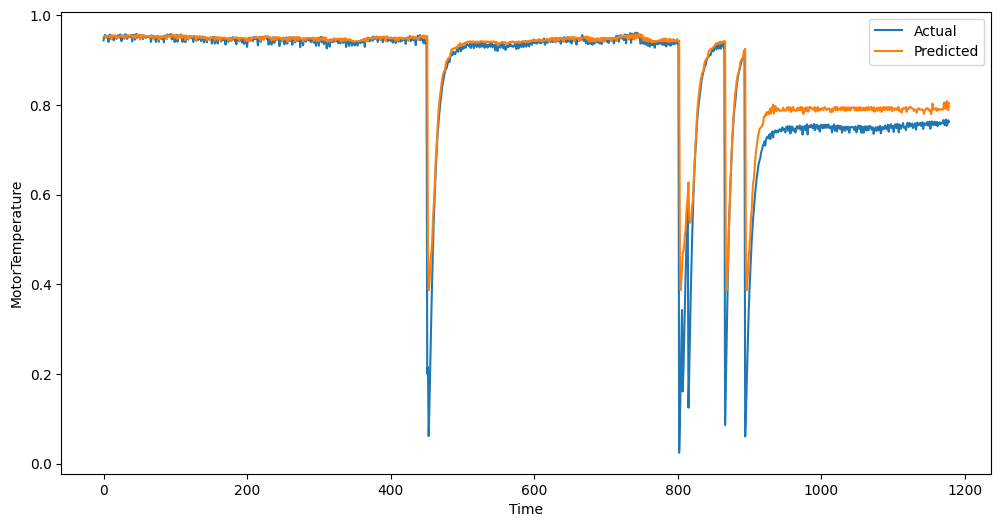

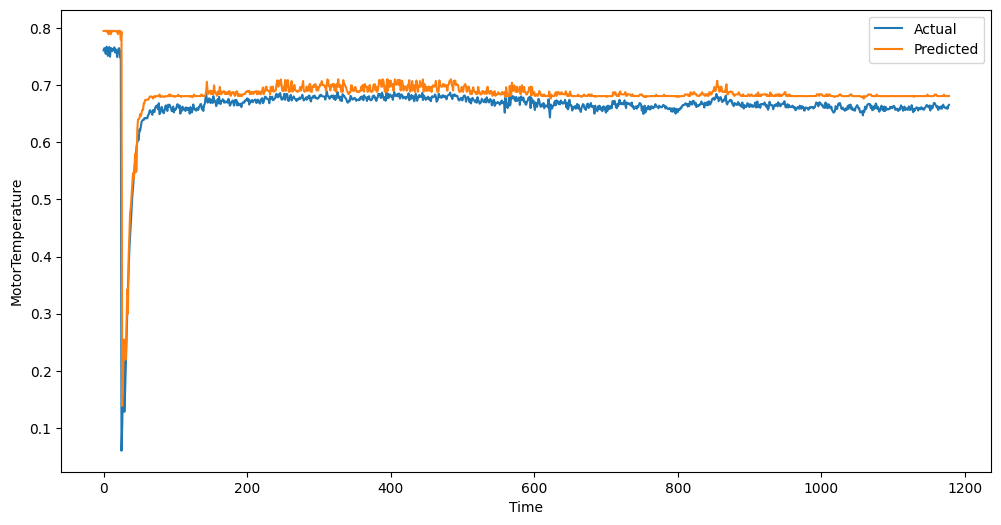

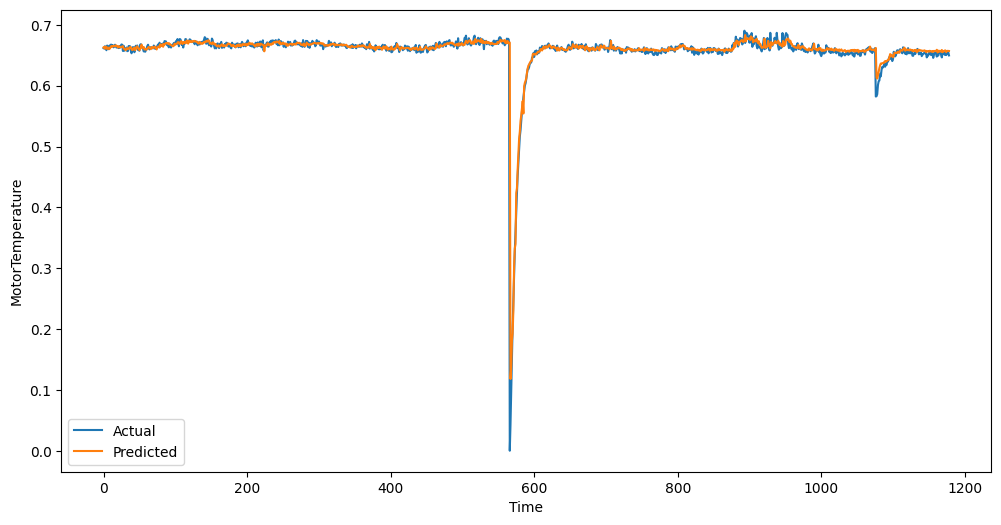

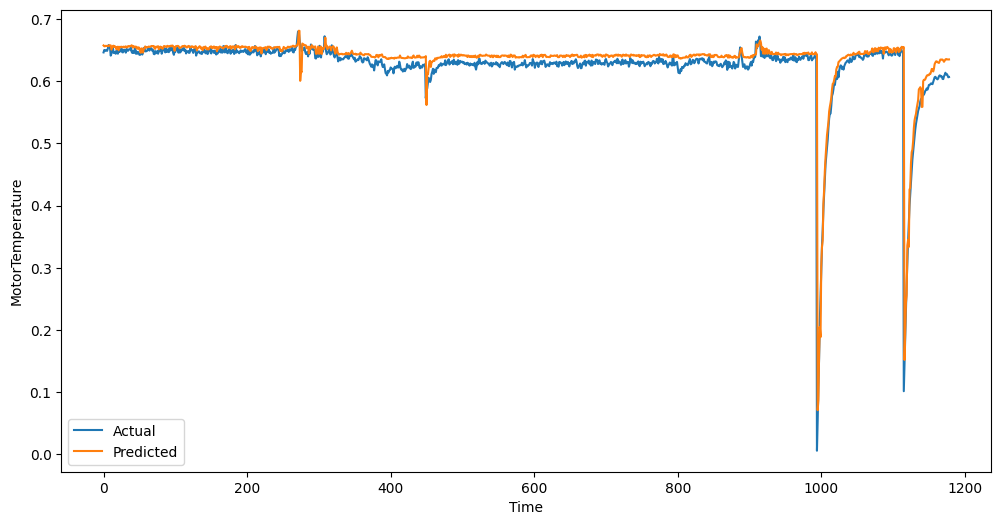

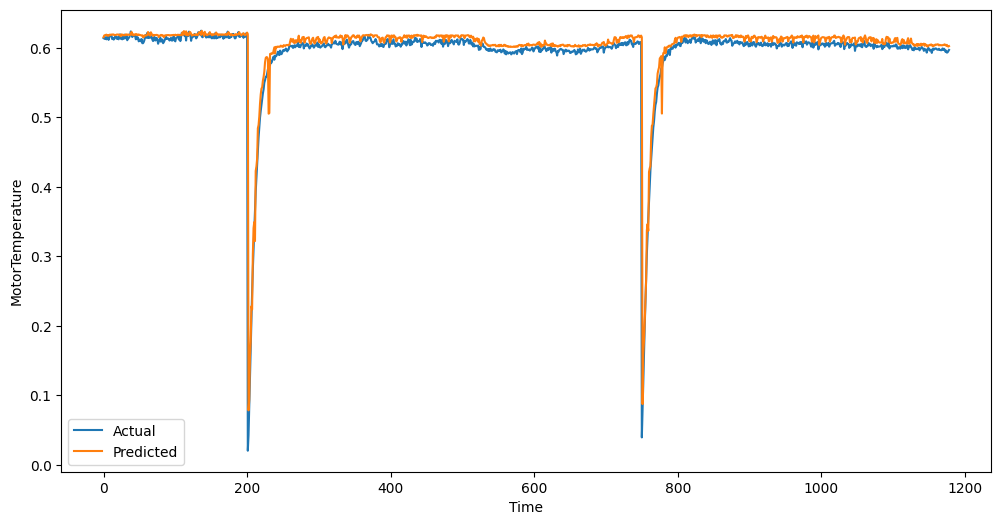

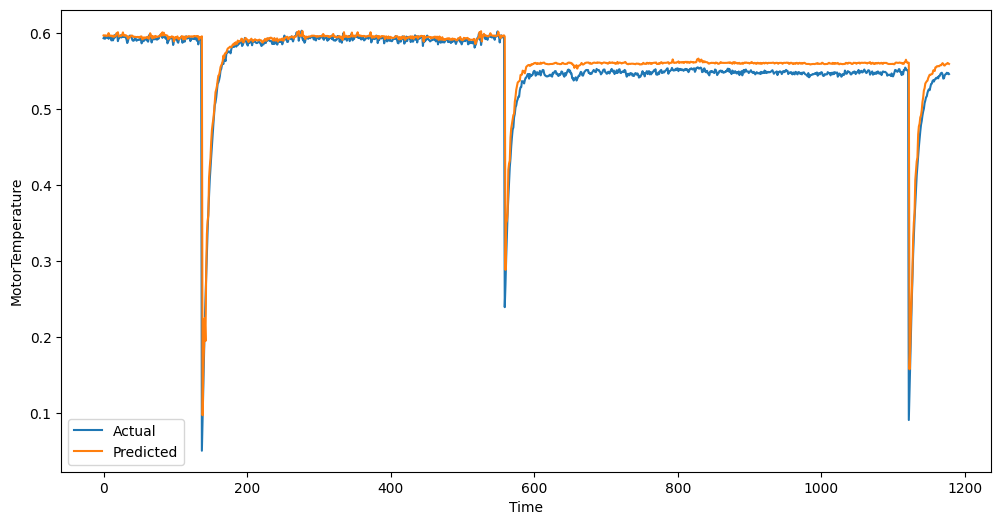

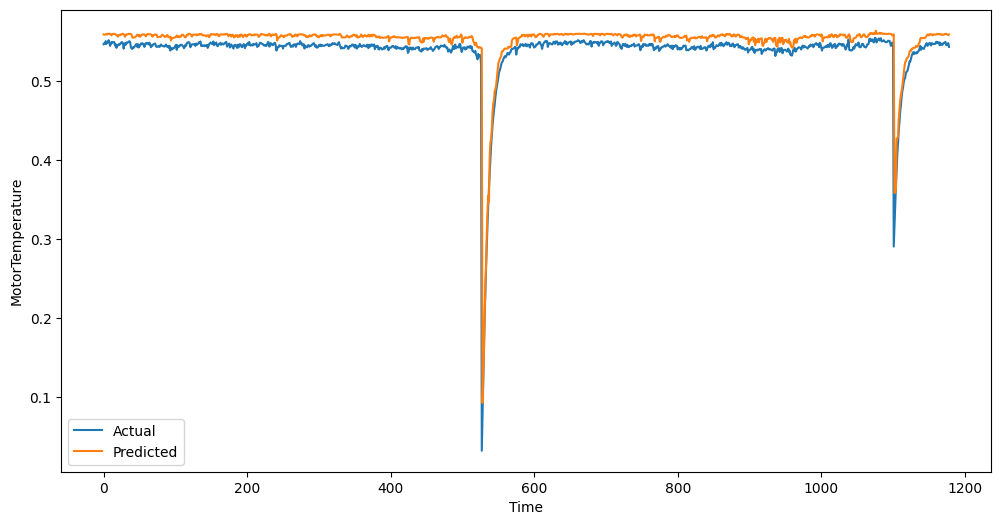

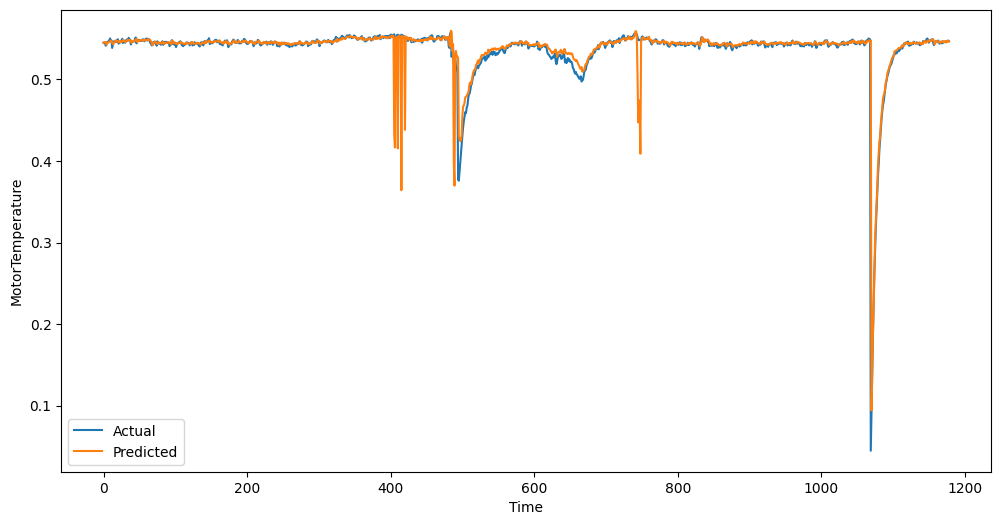

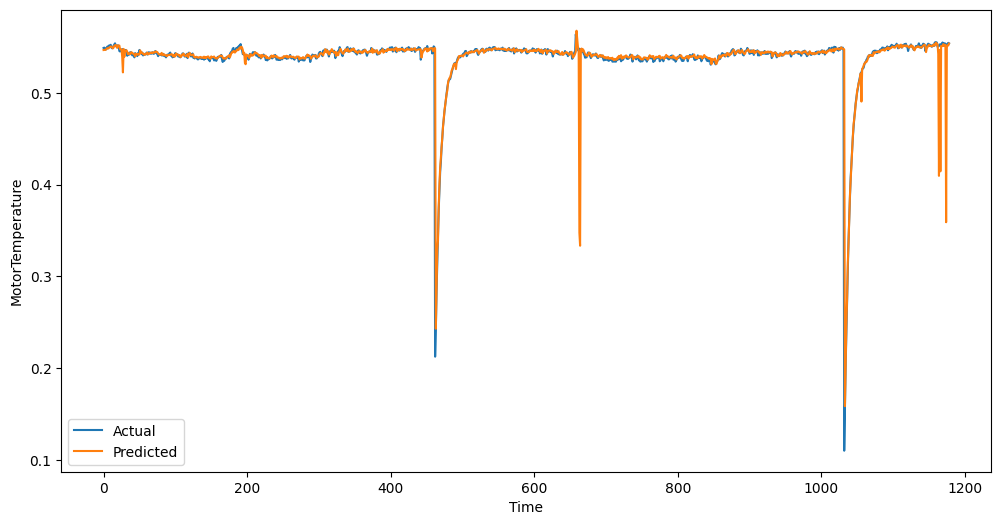

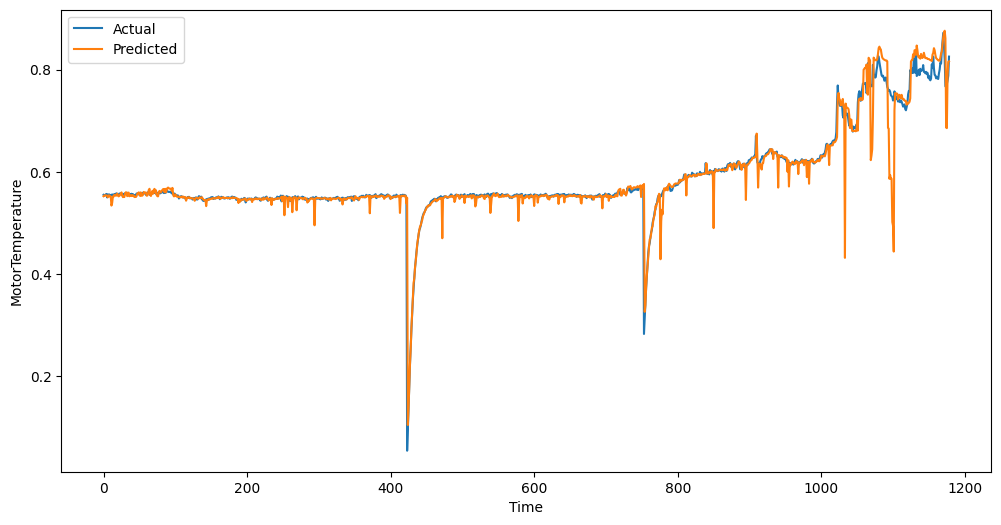

Average MSE across folds: 0.000988911337066409
All MSE Scores: [0.004363789912162773, 0.0008791400698900703, 0.00042055085749834545, 0.0007581528717304685, 0.0006842551122418504, 0.0006551231307973742, 0.00043590381874760364, 0.0004098930383680681, 0.00040162686077941485, 0.0008806776984481207]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'data_filtered_every_20th' is your DataFrame with 'MotorTemperature' and other features

# Step 1: Prepare your data
# Extract the MotorTemperature column and convert it to a NumPy array
motor_temperature = data_filtered_every_20th['MotorTemperature'].values

# Normalize the data
scaler = MinMaxScaler()
motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X, y = [], []
for i in range(len(motor_temperature) - sequence_length):
    X.append(motor_temperature[i:i + sequence_length])
    y.append(motor_temperature[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Flatten the sequences into 2D arrays
X = X.reshape(X.shape[0], -1)  # Flatten sequences into a 2D array

# Split the data using TimeSeriesSplit with 10% for testing
tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits

# Initialize lists to store metrics for each fold (e.g., MSE)
mse_scores = []

# Iterate through the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training data further into training and validation (90% for training, 10% for validation)
    val_size = int(0.1 * len(X_train))
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]

    # Create and train your Random Forest model for this fold
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    model.fit(X_train, y_train.ravel()) #Ravel is to ensure is 1D instead of 2D

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate MSE for this fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('MotorTemperature')
    plt.legend()
    plt.show()

# Calculate and report the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f'Average MSE across folds: {average_mse}')

# Print all values in mse_scores
print("All MSE Scores:", mse_scores)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Assuming 'data' is your DataFrame with 'MotorTemperature' and other features

# Step 1: Prepare your data
# Extract the relevant columns and convert them to NumPy arrays
motor_temperature = data_filtered_every_20th['MotorTemperature'].values
torque1_mean = data_filtered_every_20th['Torque1Mean'].values
rul = data_filtered_every_20th['RUL'].values

# Normalize the data (you can adjust this if needed)
scaler = MinMaxScaler()
motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))
torque1_mean = scaler.fit_transform(torque1_mean.reshape(-1, 1))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X, y = [], []
for i in range(len(motor_temperature) - sequence_length):
    X.append(np.column_stack((motor_temperature[i:i + sequence_length], torque1_mean[i:i + sequence_length])))
    y.append(rul[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data using TimeSeriesSplit with 10% for testing
tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits

# Initialize lists to store metrics for each fold (e.g., MSE)
mse_scores = []

# Iterate through the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training data further into training and validation (90% for training, 10% for validation)
    val_size = int(0.1 * len(X_train))
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]

    # Create and train your LSTM model for this fold
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

    # Evaluate the model on the test data and calculate MSE
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    mse_scores.append(mse)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('MotorTemperature')
    plt.legend()
    plt.show()

# Calculate and report the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f'Average MSE across folds: {average_mse}')

# Print all values in mse_scores
print("All MSE Scores:", mse_scores)

Epoch 1/20


ValueError: ignored

## Predict RUL based on Temperature and Torque

Epoch 1/20
34/34 - 3s - loss: 0.3050 - val_loss: 5.4022e-04 - 3s/epoch - 102ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0055 - val_loss: 2.1342e-04 - 266ms/epoch - 8ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0020 - val_loss: 5.6821e-05 - 258ms/epoch - 8ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0018 - val_loss: 4.1118e-05 - 266ms/epoch - 8ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0017 - val_loss: 1.0206e-05 - 272ms/epoch - 8ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0016 - val_loss: 5.0394e-05 - 252ms/epoch - 7ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0015 - val_loss: 3.8741e-05 - 252ms/epoch - 7ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0014 - val_loss: 3.8791e-05 - 246ms/epoch - 7ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0014 - val_loss: 2.0310e-05 - 262ms/epoch - 8ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0013 - val_loss: 3.5203e-05 - 257ms/epoch - 8ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0012 - val_loss: 1.0409e-04 - 254ms/epoch - 7ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0012 - val_loss: 7.6391e-06 - 2

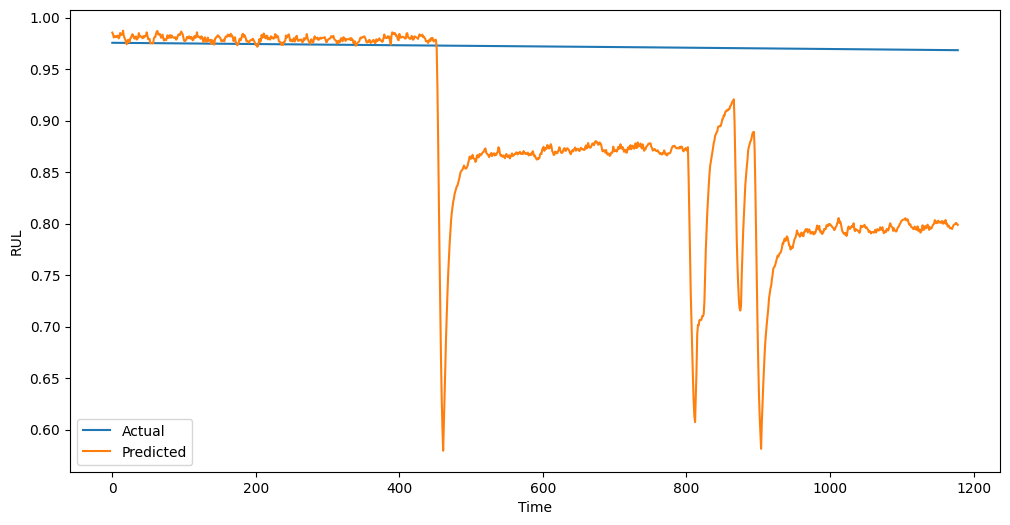

Epoch 1/20
67/67 - 3s - loss: 0.1121 - val_loss: 0.0380 - 3s/epoch - 45ms/step
Epoch 2/20
67/67 - 0s - loss: 0.0066 - val_loss: 0.0237 - 472ms/epoch - 7ms/step
Epoch 3/20
67/67 - 1s - loss: 0.0049 - val_loss: 0.0142 - 524ms/epoch - 8ms/step
Epoch 4/20
67/67 - 0s - loss: 0.0037 - val_loss: 0.0091 - 484ms/epoch - 7ms/step
Epoch 5/20
67/67 - 0s - loss: 0.0027 - val_loss: 0.0060 - 479ms/epoch - 7ms/step
Epoch 6/20
67/67 - 0s - loss: 0.0017 - val_loss: 0.0023 - 484ms/epoch - 7ms/step
Epoch 7/20
67/67 - 0s - loss: 9.9181e-04 - val_loss: 0.0015 - 492ms/epoch - 7ms/step
Epoch 8/20
67/67 - 0s - loss: 4.2563e-04 - val_loss: 2.5981e-04 - 492ms/epoch - 7ms/step
Epoch 9/20
67/67 - 1s - loss: 1.3691e-04 - val_loss: 2.9783e-06 - 512ms/epoch - 8ms/step
Epoch 10/20
67/67 - 1s - loss: 6.7878e-05 - val_loss: 4.8669e-06 - 504ms/epoch - 8ms/step
Epoch 11/20
67/67 - 1s - loss: 5.8297e-05 - val_loss: 8.6515e-05 - 620ms/epoch - 9ms/step
Epoch 12/20
67/67 - 0s - loss: 5.3509e-05 - val_loss: 1.4964e-05 - 469ms/

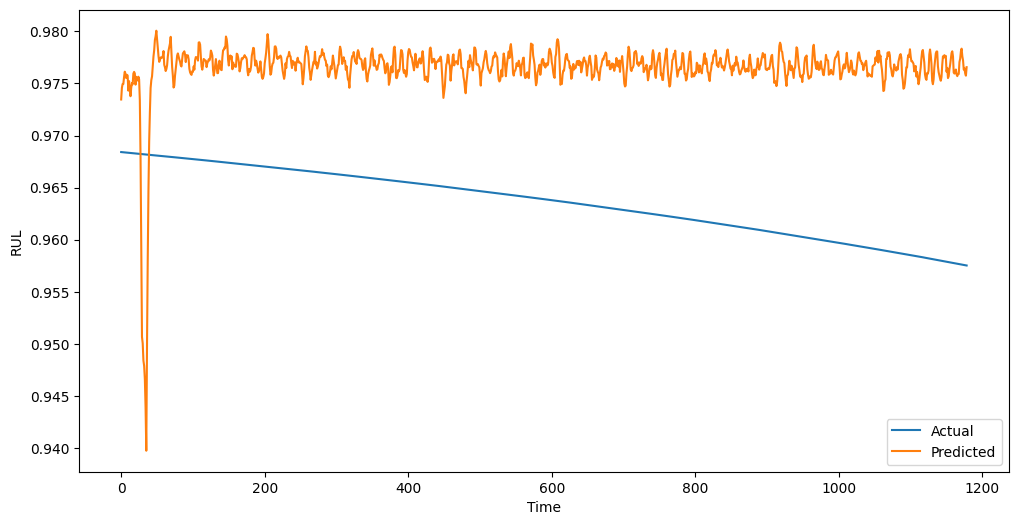

Epoch 1/20
100/100 - 3s - loss: 0.0825 - val_loss: 0.0178 - 3s/epoch - 33ms/step
Epoch 2/20
100/100 - 1s - loss: 0.0075 - val_loss: 0.0064 - 676ms/epoch - 7ms/step
Epoch 3/20
100/100 - 1s - loss: 0.0029 - val_loss: 0.0012 - 698ms/epoch - 7ms/step
Epoch 4/20
100/100 - 1s - loss: 6.3629e-04 - val_loss: 3.3310e-05 - 702ms/epoch - 7ms/step
Epoch 5/20
100/100 - 1s - loss: 1.5616e-04 - val_loss: 8.4171e-05 - 725ms/epoch - 7ms/step
Epoch 6/20
100/100 - 1s - loss: 9.3743e-05 - val_loss: 9.3922e-05 - 727ms/epoch - 7ms/step
Epoch 7/20
100/100 - 1s - loss: 8.4260e-05 - val_loss: 1.0705e-04 - 752ms/epoch - 8ms/step
Epoch 8/20
100/100 - 1s - loss: 7.3824e-05 - val_loss: 8.3756e-05 - 734ms/epoch - 7ms/step
Epoch 9/20
100/100 - 1s - loss: 6.7089e-05 - val_loss: 9.5562e-05 - 729ms/epoch - 7ms/step
Epoch 10/20
100/100 - 1s - loss: 6.2343e-05 - val_loss: 7.7069e-05 - 719ms/epoch - 7ms/step
Epoch 11/20
100/100 - 1s - loss: 5.4492e-05 - val_loss: 5.6989e-05 - 687ms/epoch - 7ms/step
Epoch 12/20
100/100 - 1

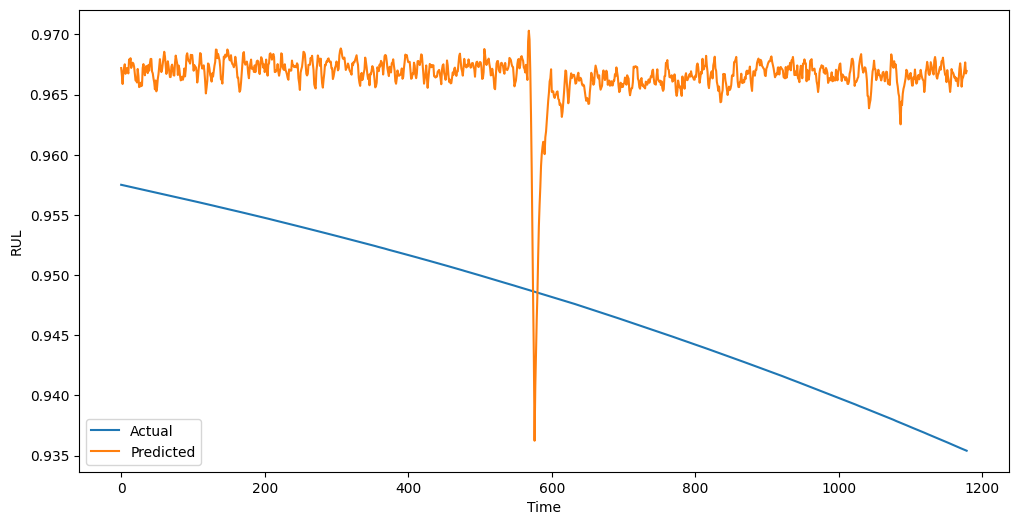

Epoch 1/20
133/133 - 4s - loss: 0.0543 - val_loss: 0.0014 - 4s/epoch - 33ms/step
Epoch 2/20
133/133 - 1s - loss: 0.0010 - val_loss: 4.3936e-04 - 890ms/epoch - 7ms/step
Epoch 3/20
133/133 - 1s - loss: 1.0819e-04 - val_loss: 8.4374e-04 - 861ms/epoch - 6ms/step
Epoch 4/20
133/133 - 1s - loss: 9.6118e-05 - val_loss: 4.4565e-04 - 852ms/epoch - 6ms/step
Epoch 5/20
133/133 - 1s - loss: 8.8435e-05 - val_loss: 4.7266e-04 - 849ms/epoch - 6ms/step
Epoch 6/20
133/133 - 1s - loss: 8.0797e-05 - val_loss: 6.0227e-04 - 888ms/epoch - 7ms/step
Epoch 7/20
133/133 - 1s - loss: 7.2039e-05 - val_loss: 4.0569e-04 - 887ms/epoch - 7ms/step
Epoch 8/20
133/133 - 1s - loss: 6.4468e-05 - val_loss: 4.7686e-04 - 888ms/epoch - 7ms/step
Epoch 9/20
133/133 - 1s - loss: 6.1468e-05 - val_loss: 4.0858e-04 - 834ms/epoch - 6ms/step
Epoch 10/20
133/133 - 1s - loss: 5.4550e-05 - val_loss: 4.6917e-04 - 925ms/epoch - 7ms/step
Epoch 11/20
133/133 - 1s - loss: 5.4027e-05 - val_loss: 7.0403e-04 - 947ms/epoch - 7ms/step
Epoch 12/20

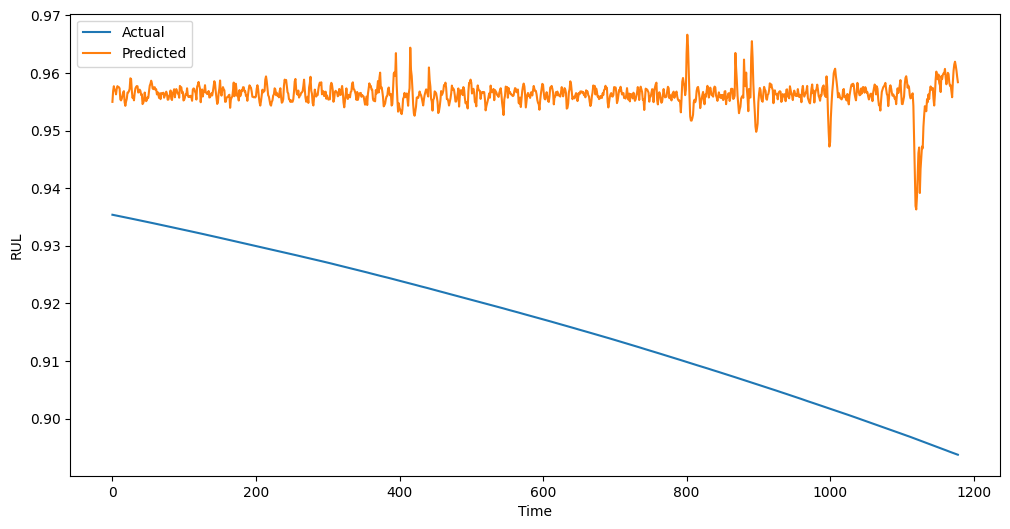

Epoch 1/20
166/166 - 4s - loss: 0.0640 - val_loss: 0.0026 - 4s/epoch - 22ms/step
Epoch 2/20
166/166 - 1s - loss: 0.0024 - val_loss: 7.2579e-04 - 1s/epoch - 7ms/step
Epoch 3/20
166/166 - 1s - loss: 3.3935e-04 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 4/20
166/166 - 1s - loss: 1.9737e-04 - val_loss: 0.0016 - 1s/epoch - 6ms/step
Epoch 5/20
166/166 - 1s - loss: 1.8872e-04 - val_loss: 0.0022 - 1s/epoch - 7ms/step
Epoch 6/20
166/166 - 1s - loss: 1.8410e-04 - val_loss: 0.0020 - 1s/epoch - 6ms/step
Epoch 7/20
166/166 - 1s - loss: 1.8378e-04 - val_loss: 0.0026 - 1s/epoch - 7ms/step
Epoch 8/20
166/166 - 1s - loss: 1.7759e-04 - val_loss: 0.0018 - 1s/epoch - 6ms/step
Epoch 9/20
166/166 - 1s - loss: 1.8078e-04 - val_loss: 0.0019 - 1s/epoch - 6ms/step
Epoch 10/20
166/166 - 1s - loss: 1.7502e-04 - val_loss: 0.0018 - 1s/epoch - 6ms/step
Epoch 11/20
166/166 - 1s - loss: 1.6895e-04 - val_loss: 0.0025 - 1s/epoch - 6ms/step
Epoch 12/20
166/166 - 1s - loss: 1.6773e-04 - val_loss: 0.0018 - 1s/epoch - 7

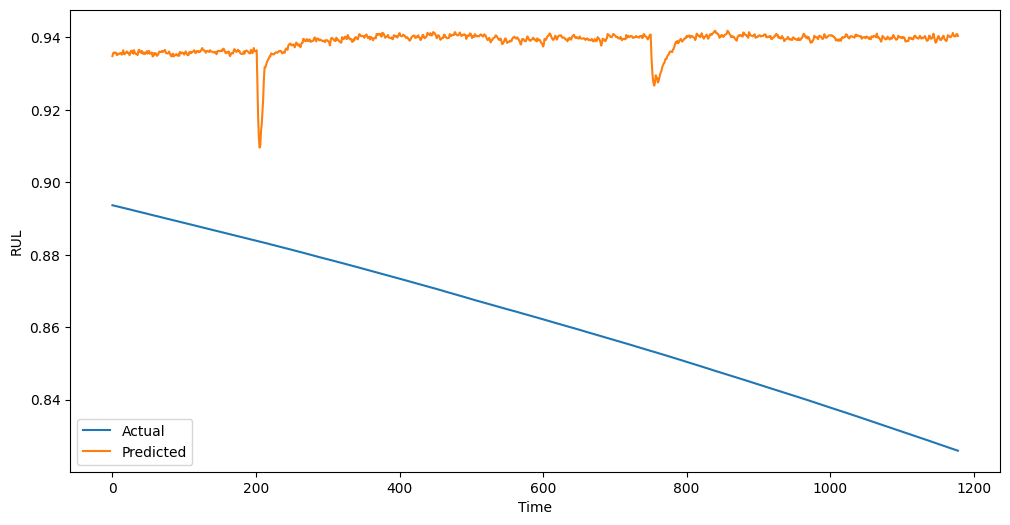

Epoch 1/20
200/200 - 4s - loss: 0.0267 - val_loss: 0.0018 - 4s/epoch - 19ms/step
Epoch 2/20
200/200 - 1s - loss: 0.0015 - val_loss: 0.0043 - 1s/epoch - 7ms/step
Epoch 3/20
200/200 - 1s - loss: 5.2939e-04 - val_loss: 0.0068 - 1s/epoch - 6ms/step
Epoch 4/20
200/200 - 1s - loss: 4.7789e-04 - val_loss: 0.0075 - 1s/epoch - 6ms/step
Epoch 5/20
200/200 - 1s - loss: 4.7242e-04 - val_loss: 0.0074 - 1s/epoch - 6ms/step
Epoch 6/20
200/200 - 1s - loss: 4.7559e-04 - val_loss: 0.0083 - 1s/epoch - 7ms/step
Epoch 7/20
200/200 - 1s - loss: 4.9328e-04 - val_loss: 0.0070 - 1s/epoch - 7ms/step
Epoch 8/20
200/200 - 1s - loss: 4.7280e-04 - val_loss: 0.0090 - 1s/epoch - 6ms/step
Epoch 9/20
200/200 - 1s - loss: 4.7600e-04 - val_loss: 0.0066 - 1s/epoch - 7ms/step
Epoch 10/20
200/200 - 1s - loss: 5.0035e-04 - val_loss: 0.0059 - 1s/epoch - 7ms/step
Epoch 11/20
200/200 - 1s - loss: 4.7308e-04 - val_loss: 0.0077 - 1s/epoch - 7ms/step
Epoch 12/20
200/200 - 1s - loss: 4.6478e-04 - val_loss: 0.0082 - 1s/epoch - 7ms/s

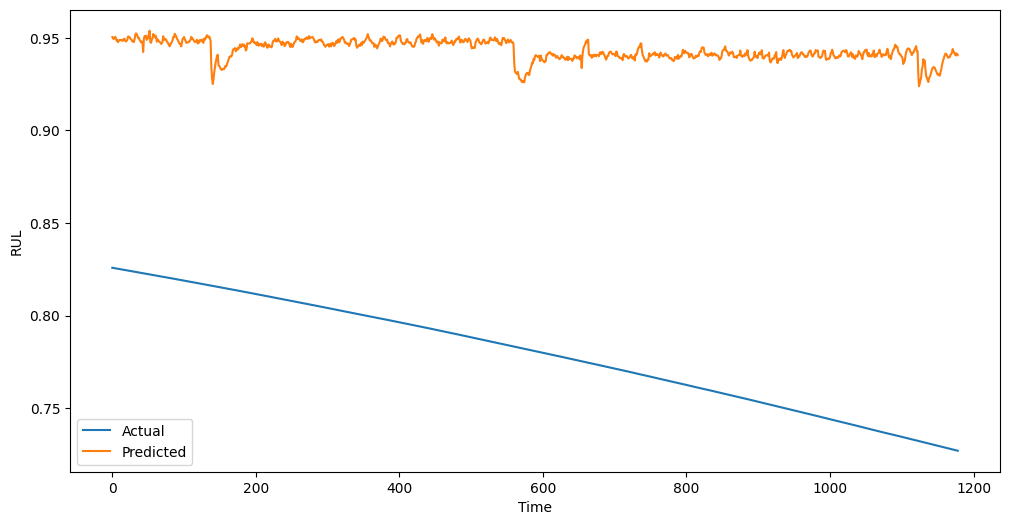

Epoch 1/20
233/233 - 4s - loss: 0.0607 - val_loss: 0.0102 - 4s/epoch - 17ms/step
Epoch 2/20
233/233 - 1s - loss: 0.0019 - val_loss: 0.0169 - 1s/epoch - 6ms/step
Epoch 3/20
233/233 - 2s - loss: 0.0015 - val_loss: 0.0173 - 2s/epoch - 7ms/step
Epoch 4/20
233/233 - 2s - loss: 0.0015 - val_loss: 0.0169 - 2s/epoch - 7ms/step
Epoch 5/20
233/233 - 2s - loss: 0.0014 - val_loss: 0.0139 - 2s/epoch - 7ms/step
Epoch 6/20
233/233 - 2s - loss: 0.0015 - val_loss: 0.0183 - 2s/epoch - 7ms/step
Epoch 7/20
233/233 - 1s - loss: 0.0015 - val_loss: 0.0155 - 1s/epoch - 6ms/step
Epoch 8/20
233/233 - 1s - loss: 0.0014 - val_loss: 0.0202 - 1s/epoch - 6ms/step
Epoch 9/20
233/233 - 1s - loss: 0.0015 - val_loss: 0.0172 - 1s/epoch - 6ms/step
Epoch 10/20
233/233 - 1s - loss: 0.0014 - val_loss: 0.0155 - 1s/epoch - 6ms/step
Epoch 11/20
233/233 - 1s - loss: 0.0014 - val_loss: 0.0174 - 1s/epoch - 6ms/step
Epoch 12/20
233/233 - 1s - loss: 0.0015 - val_loss: 0.0152 - 1s/epoch - 6ms/step
Epoch 13/20
233/233 - 1s - loss: 0.0

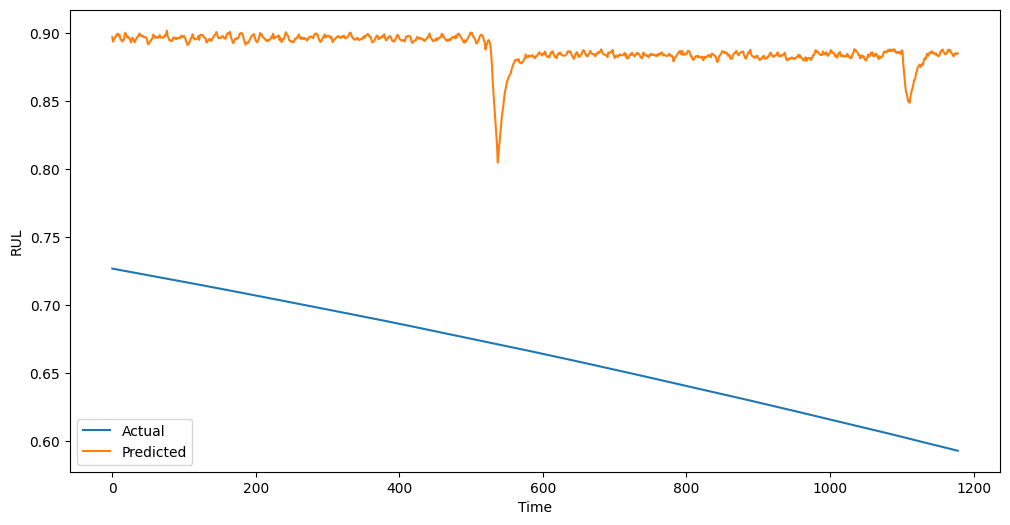

Epoch 1/20
266/266 - 5s - loss: 0.0272 - val_loss: 0.0310 - 5s/epoch - 20ms/step
Epoch 2/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0452 - 2s/epoch - 7ms/step
Epoch 3/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0415 - 2s/epoch - 6ms/step
Epoch 4/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0415 - 2s/epoch - 6ms/step
Epoch 5/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0427 - 2s/epoch - 6ms/step
Epoch 6/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0415 - 2s/epoch - 6ms/step
Epoch 7/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0444 - 2s/epoch - 7ms/step
Epoch 8/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0341 - 2s/epoch - 7ms/step
Epoch 9/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0371 - 2s/epoch - 7ms/step
Epoch 10/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0470 - 2s/epoch - 7ms/step
Epoch 11/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0399 - 2s/epoch - 7ms/step
Epoch 12/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0428 - 2s/epoch - 6ms/step
Epoch 13/20
266/266 - 2s - loss: 0.0

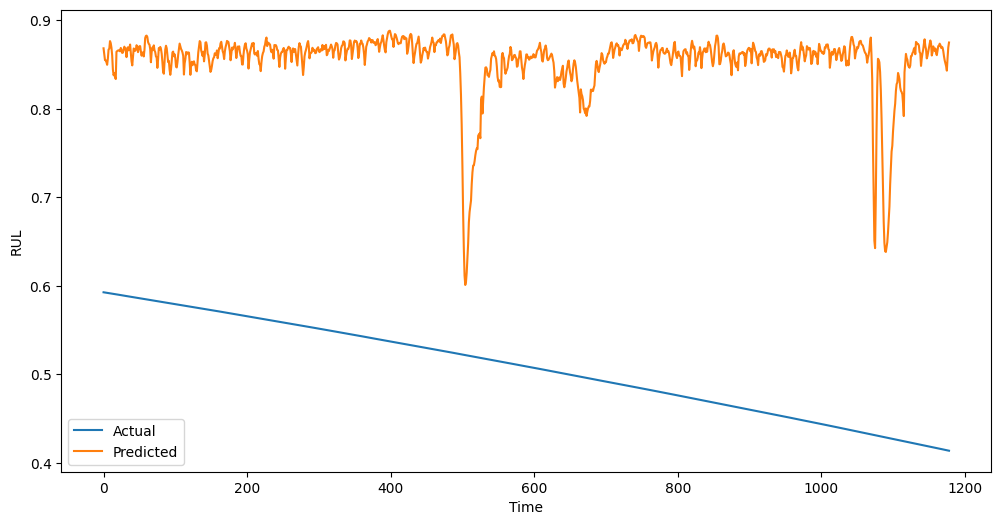

Epoch 1/20
299/299 - 5s - loss: 0.0408 - val_loss: 0.0829 - 5s/epoch - 15ms/step
Epoch 2/20
299/299 - 2s - loss: 0.0065 - val_loss: 0.0851 - 2s/epoch - 6ms/step
Epoch 3/20
299/299 - 2s - loss: 0.0064 - val_loss: 0.0778 - 2s/epoch - 6ms/step
Epoch 4/20
299/299 - 2s - loss: 0.0061 - val_loss: 0.0668 - 2s/epoch - 6ms/step
Epoch 5/20
299/299 - 2s - loss: 0.0052 - val_loss: 0.0393 - 2s/epoch - 7ms/step
Epoch 6/20
299/299 - 2s - loss: 0.0041 - val_loss: 0.0405 - 2s/epoch - 6ms/step
Epoch 7/20
299/299 - 2s - loss: 0.0034 - val_loss: 0.0376 - 2s/epoch - 7ms/step
Epoch 8/20
299/299 - 2s - loss: 0.0032 - val_loss: 0.0484 - 2s/epoch - 6ms/step
Epoch 9/20
299/299 - 2s - loss: 0.0030 - val_loss: 0.0396 - 2s/epoch - 6ms/step
Epoch 10/20
299/299 - 2s - loss: 0.0029 - val_loss: 0.0429 - 2s/epoch - 6ms/step
Epoch 11/20
299/299 - 2s - loss: 0.0022 - val_loss: 0.0300 - 2s/epoch - 7ms/step
Epoch 12/20
299/299 - 2s - loss: 0.0018 - val_loss: 0.0204 - 2s/epoch - 7ms/step
Epoch 13/20
299/299 - 2s - loss: 0.0

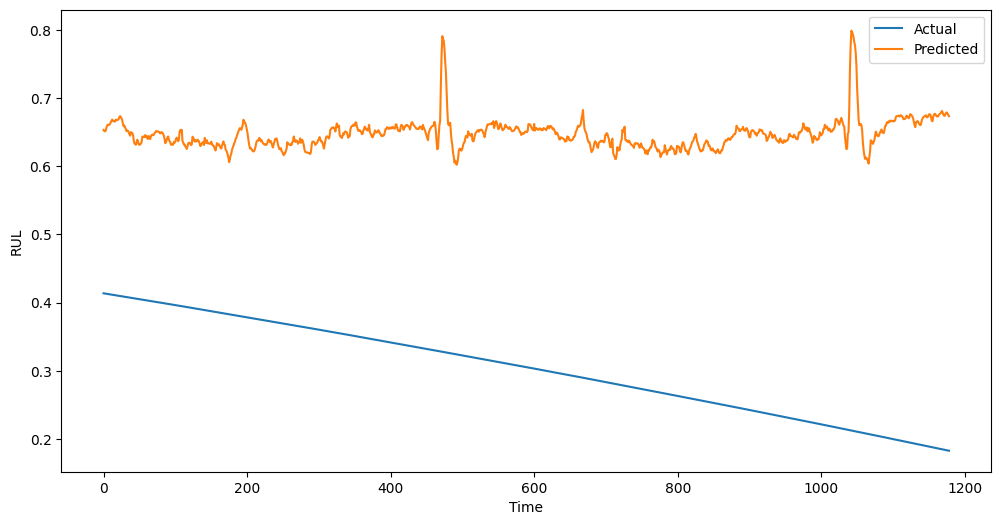

Epoch 1/20
332/332 - 5s - loss: 0.0250 - val_loss: 0.1625 - 5s/epoch - 14ms/step
Epoch 2/20
332/332 - 2s - loss: 0.0111 - val_loss: 0.1550 - 2s/epoch - 6ms/step
Epoch 3/20
332/332 - 2s - loss: 0.0070 - val_loss: 0.0873 - 2s/epoch - 6ms/step
Epoch 4/20
332/332 - 2s - loss: 0.0065 - val_loss: 0.1039 - 2s/epoch - 7ms/step
Epoch 5/20
332/332 - 2s - loss: 0.0065 - val_loss: 0.0956 - 2s/epoch - 6ms/step
Epoch 6/20
332/332 - 2s - loss: 0.0062 - val_loss: 0.1059 - 2s/epoch - 6ms/step
Epoch 7/20
332/332 - 2s - loss: 0.0041 - val_loss: 0.0866 - 2s/epoch - 6ms/step
Epoch 8/20
332/332 - 2s - loss: 0.0025 - val_loss: 0.0721 - 2s/epoch - 6ms/step
Epoch 9/20
332/332 - 2s - loss: 0.0023 - val_loss: 0.0550 - 2s/epoch - 6ms/step
Epoch 10/20
332/332 - 2s - loss: 0.0022 - val_loss: 0.0707 - 2s/epoch - 7ms/step
Epoch 11/20
332/332 - 2s - loss: 0.0023 - val_loss: 0.0855 - 2s/epoch - 6ms/step
Epoch 12/20
332/332 - 2s - loss: 0.0022 - val_loss: 0.0666 - 2s/epoch - 6ms/step
Epoch 13/20
332/332 - 2s - loss: 0.0

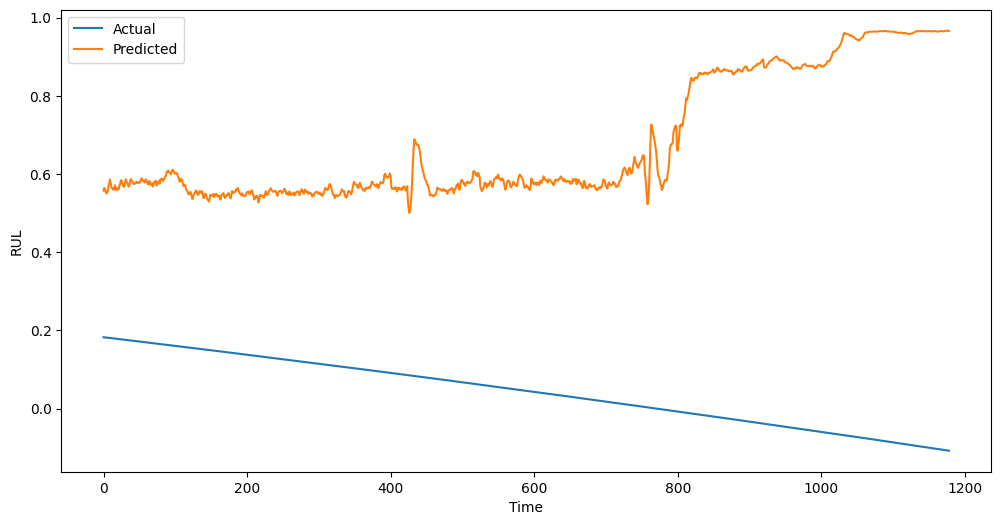

Average MSE across folds: 0.07905455695835462
All MSE Scores: [0.015451261574511333, 0.00018475466908620124, 0.0004003589668082861, 0.001724047069722521, 0.0063000200369310025, 0.02778562603877588, 0.05206405890016002, 0.1246827990140297, 0.12335439345076829, 0.438598249862753]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'data_filtered_every_20th' is your DataFrame with 'MotorTemperature' and 'Torque1Mean'

# Step 1: Prepare your data
# Extract the relevant columns and convert them to NumPy arrays
motor_temperature = data_filtered_every_20th['MotorTemperature'].values
torque1_mean = data_filtered_every_20th['Torque1Mean'].values
rul = data_filtered_every_20th['RUL'].values  # Target variable 'RUL'

# Normalize the data
scaler = MinMaxScaler()
motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))
torque1_mean = scaler.fit_transform(torque1_mean.reshape(-1, 1))

# Combine the features into one array
X = np.column_stack((motor_temperature, torque1_mean))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X_seq, y = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i + sequence_length])
    y.append(rul[i + sequence_length])

X_seq = np.array(X_seq)
y = np.array(y)

# Split the data using TimeSeriesSplit with 10% for testing
tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits

# Initialize lists to store metrics for each fold (e.g., MSE)
mse_scores = []

# Iterate through the splits
for train_index, test_index in tscv.split(X_seq):
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training data further into training and validation (90% for training, 10% for validation)
    val_size = int(0.1 * len(X_train))
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]

    # Create and train your LSTM model for this fold
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, 2)))  # Input shape is (sequence_length, 2) for two features
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

    # Evaluate the model on the test data and calculate MSE
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    mse_scores.append(mse)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()

# Calculate and report the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f'Average MSE across folds: {average_mse}')

# Print all values in mse_scores
print("All MSE Scores:", mse_scores)


Epoch 1/20
34/34 - 3s - loss: 0.3050 - val_loss: 5.4022e-04 - 3s/epoch - 102ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0055 - val_loss: 2.1342e-04 - 266ms/epoch - 8ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0020 - val_loss: 5.6821e-05 - 258ms/epoch - 8ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0018 - val_loss: 4.1118e-05 - 266ms/epoch - 8ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0017 - val_loss: 1.0206e-05 - 272ms/epoch - 8ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0016 - val_loss: 5.0394e-05 - 252ms/epoch - 7ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0015 - val_loss: 3.8741e-05 - 252ms/epoch - 7ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0014 - val_loss: 3.8791e-05 - 246ms/epoch - 7ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0014 - val_loss: 2.0310e-05 - 262ms/epoch - 8ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0013 - val_loss: 3.5203e-05 - 257ms/epoch - 8ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0012 - val_loss: 1.0409e-04 - 254ms/epoch - 7ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0012 - val_loss: 7.6391e-06 - 2

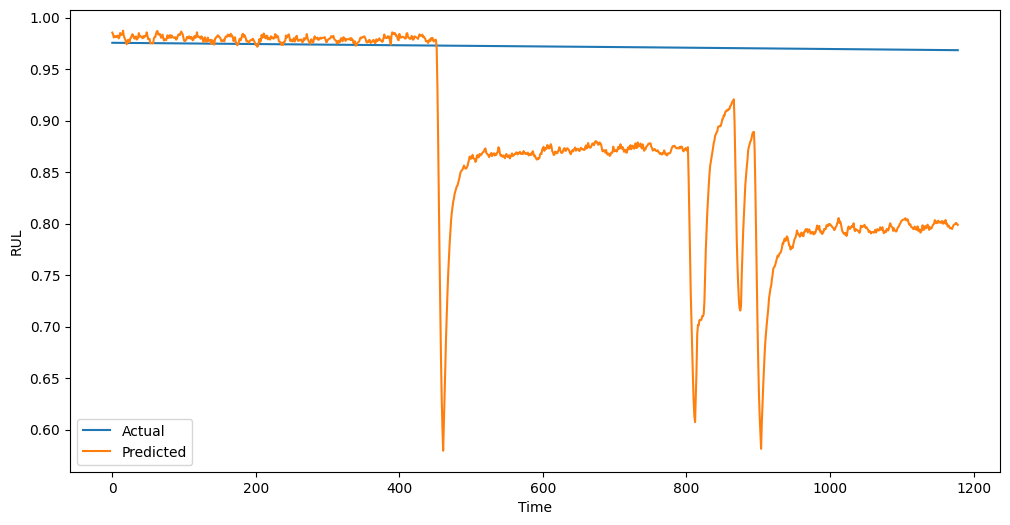

Epoch 1/20
67/67 - 3s - loss: 0.1121 - val_loss: 0.0380 - 3s/epoch - 45ms/step
Epoch 2/20
67/67 - 0s - loss: 0.0066 - val_loss: 0.0237 - 472ms/epoch - 7ms/step
Epoch 3/20
67/67 - 1s - loss: 0.0049 - val_loss: 0.0142 - 524ms/epoch - 8ms/step
Epoch 4/20
67/67 - 0s - loss: 0.0037 - val_loss: 0.0091 - 484ms/epoch - 7ms/step
Epoch 5/20
67/67 - 0s - loss: 0.0027 - val_loss: 0.0060 - 479ms/epoch - 7ms/step
Epoch 6/20
67/67 - 0s - loss: 0.0017 - val_loss: 0.0023 - 484ms/epoch - 7ms/step
Epoch 7/20
67/67 - 0s - loss: 9.9181e-04 - val_loss: 0.0015 - 492ms/epoch - 7ms/step
Epoch 8/20
67/67 - 0s - loss: 4.2563e-04 - val_loss: 2.5981e-04 - 492ms/epoch - 7ms/step
Epoch 9/20
67/67 - 1s - loss: 1.3691e-04 - val_loss: 2.9783e-06 - 512ms/epoch - 8ms/step
Epoch 10/20
67/67 - 1s - loss: 6.7878e-05 - val_loss: 4.8669e-06 - 504ms/epoch - 8ms/step
Epoch 11/20
67/67 - 1s - loss: 5.8297e-05 - val_loss: 8.6515e-05 - 620ms/epoch - 9ms/step
Epoch 12/20
67/67 - 0s - loss: 5.3509e-05 - val_loss: 1.4964e-05 - 469ms/

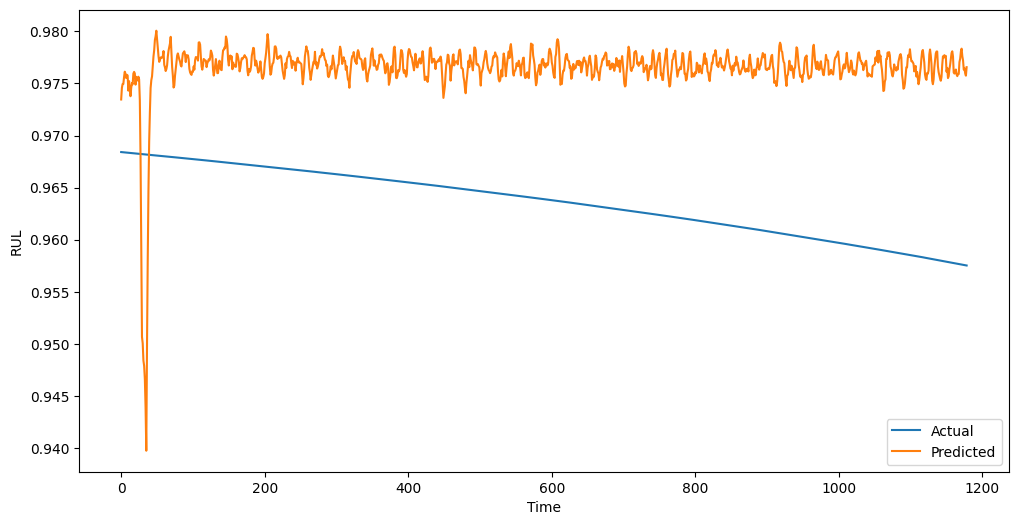

Epoch 1/20
100/100 - 3s - loss: 0.0825 - val_loss: 0.0178 - 3s/epoch - 33ms/step
Epoch 2/20
100/100 - 1s - loss: 0.0075 - val_loss: 0.0064 - 676ms/epoch - 7ms/step
Epoch 3/20
100/100 - 1s - loss: 0.0029 - val_loss: 0.0012 - 698ms/epoch - 7ms/step
Epoch 4/20
100/100 - 1s - loss: 6.3629e-04 - val_loss: 3.3310e-05 - 702ms/epoch - 7ms/step
Epoch 5/20
100/100 - 1s - loss: 1.5616e-04 - val_loss: 8.4171e-05 - 725ms/epoch - 7ms/step
Epoch 6/20
100/100 - 1s - loss: 9.3743e-05 - val_loss: 9.3922e-05 - 727ms/epoch - 7ms/step
Epoch 7/20
100/100 - 1s - loss: 8.4260e-05 - val_loss: 1.0705e-04 - 752ms/epoch - 8ms/step
Epoch 8/20
100/100 - 1s - loss: 7.3824e-05 - val_loss: 8.3756e-05 - 734ms/epoch - 7ms/step
Epoch 9/20
100/100 - 1s - loss: 6.7089e-05 - val_loss: 9.5562e-05 - 729ms/epoch - 7ms/step
Epoch 10/20
100/100 - 1s - loss: 6.2343e-05 - val_loss: 7.7069e-05 - 719ms/epoch - 7ms/step
Epoch 11/20
100/100 - 1s - loss: 5.4492e-05 - val_loss: 5.6989e-05 - 687ms/epoch - 7ms/step
Epoch 12/20
100/100 - 1

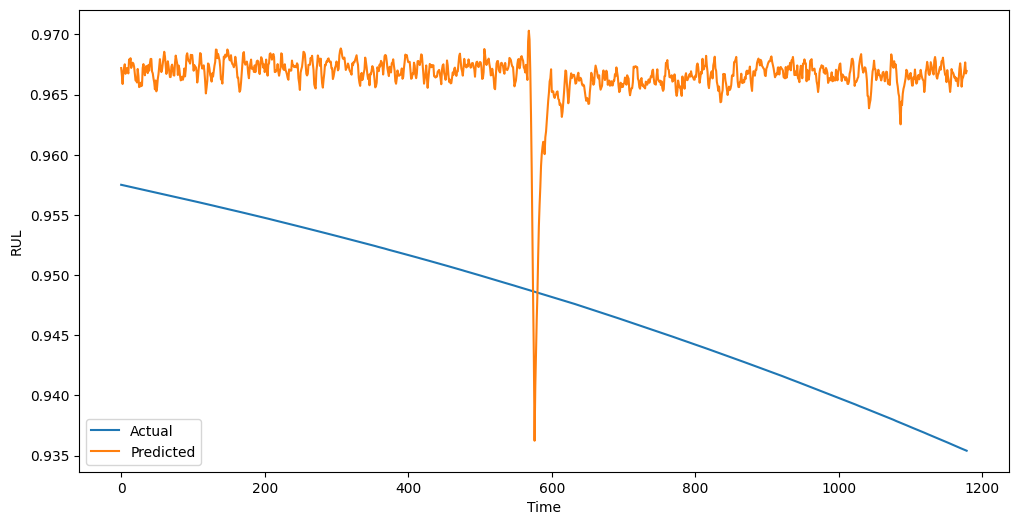

Epoch 1/20
133/133 - 4s - loss: 0.0543 - val_loss: 0.0014 - 4s/epoch - 33ms/step
Epoch 2/20
133/133 - 1s - loss: 0.0010 - val_loss: 4.3936e-04 - 890ms/epoch - 7ms/step
Epoch 3/20
133/133 - 1s - loss: 1.0819e-04 - val_loss: 8.4374e-04 - 861ms/epoch - 6ms/step
Epoch 4/20
133/133 - 1s - loss: 9.6118e-05 - val_loss: 4.4565e-04 - 852ms/epoch - 6ms/step
Epoch 5/20
133/133 - 1s - loss: 8.8435e-05 - val_loss: 4.7266e-04 - 849ms/epoch - 6ms/step
Epoch 6/20
133/133 - 1s - loss: 8.0797e-05 - val_loss: 6.0227e-04 - 888ms/epoch - 7ms/step
Epoch 7/20
133/133 - 1s - loss: 7.2039e-05 - val_loss: 4.0569e-04 - 887ms/epoch - 7ms/step
Epoch 8/20
133/133 - 1s - loss: 6.4468e-05 - val_loss: 4.7686e-04 - 888ms/epoch - 7ms/step
Epoch 9/20
133/133 - 1s - loss: 6.1468e-05 - val_loss: 4.0858e-04 - 834ms/epoch - 6ms/step
Epoch 10/20
133/133 - 1s - loss: 5.4550e-05 - val_loss: 4.6917e-04 - 925ms/epoch - 7ms/step
Epoch 11/20
133/133 - 1s - loss: 5.4027e-05 - val_loss: 7.0403e-04 - 947ms/epoch - 7ms/step
Epoch 12/20

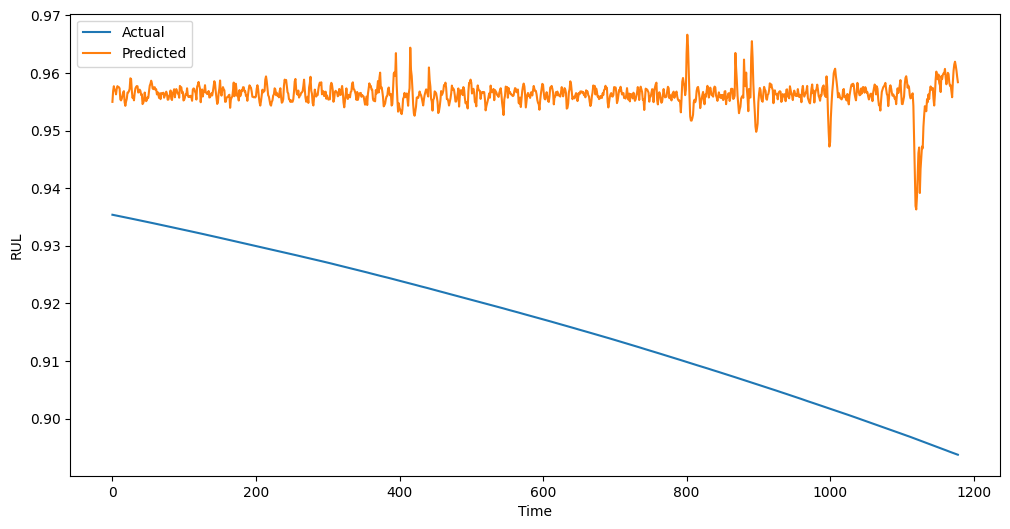

Epoch 1/20
166/166 - 4s - loss: 0.0640 - val_loss: 0.0026 - 4s/epoch - 22ms/step
Epoch 2/20
166/166 - 1s - loss: 0.0024 - val_loss: 7.2579e-04 - 1s/epoch - 7ms/step
Epoch 3/20
166/166 - 1s - loss: 3.3935e-04 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 4/20
166/166 - 1s - loss: 1.9737e-04 - val_loss: 0.0016 - 1s/epoch - 6ms/step
Epoch 5/20
166/166 - 1s - loss: 1.8872e-04 - val_loss: 0.0022 - 1s/epoch - 7ms/step
Epoch 6/20
166/166 - 1s - loss: 1.8410e-04 - val_loss: 0.0020 - 1s/epoch - 6ms/step
Epoch 7/20
166/166 - 1s - loss: 1.8378e-04 - val_loss: 0.0026 - 1s/epoch - 7ms/step
Epoch 8/20
166/166 - 1s - loss: 1.7759e-04 - val_loss: 0.0018 - 1s/epoch - 6ms/step
Epoch 9/20
166/166 - 1s - loss: 1.8078e-04 - val_loss: 0.0019 - 1s/epoch - 6ms/step
Epoch 10/20
166/166 - 1s - loss: 1.7502e-04 - val_loss: 0.0018 - 1s/epoch - 6ms/step
Epoch 11/20
166/166 - 1s - loss: 1.6895e-04 - val_loss: 0.0025 - 1s/epoch - 6ms/step
Epoch 12/20
166/166 - 1s - loss: 1.6773e-04 - val_loss: 0.0018 - 1s/epoch - 7

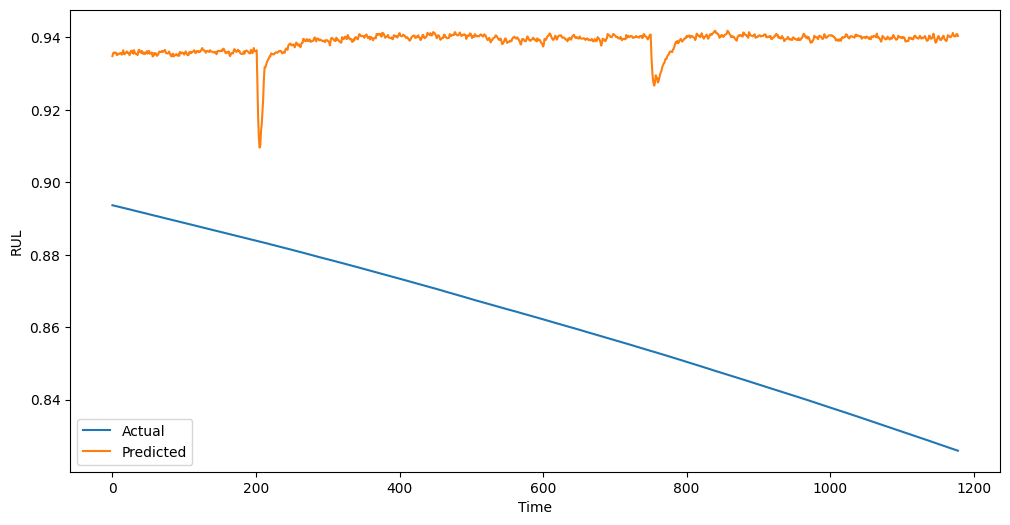

Epoch 1/20
200/200 - 4s - loss: 0.0267 - val_loss: 0.0018 - 4s/epoch - 19ms/step
Epoch 2/20
200/200 - 1s - loss: 0.0015 - val_loss: 0.0043 - 1s/epoch - 7ms/step
Epoch 3/20
200/200 - 1s - loss: 5.2939e-04 - val_loss: 0.0068 - 1s/epoch - 6ms/step
Epoch 4/20
200/200 - 1s - loss: 4.7789e-04 - val_loss: 0.0075 - 1s/epoch - 6ms/step
Epoch 5/20
200/200 - 1s - loss: 4.7242e-04 - val_loss: 0.0074 - 1s/epoch - 6ms/step
Epoch 6/20
200/200 - 1s - loss: 4.7559e-04 - val_loss: 0.0083 - 1s/epoch - 7ms/step
Epoch 7/20
200/200 - 1s - loss: 4.9328e-04 - val_loss: 0.0070 - 1s/epoch - 7ms/step
Epoch 8/20
200/200 - 1s - loss: 4.7280e-04 - val_loss: 0.0090 - 1s/epoch - 6ms/step
Epoch 9/20
200/200 - 1s - loss: 4.7600e-04 - val_loss: 0.0066 - 1s/epoch - 7ms/step
Epoch 10/20
200/200 - 1s - loss: 5.0035e-04 - val_loss: 0.0059 - 1s/epoch - 7ms/step
Epoch 11/20
200/200 - 1s - loss: 4.7308e-04 - val_loss: 0.0077 - 1s/epoch - 7ms/step
Epoch 12/20
200/200 - 1s - loss: 4.6478e-04 - val_loss: 0.0082 - 1s/epoch - 7ms/s

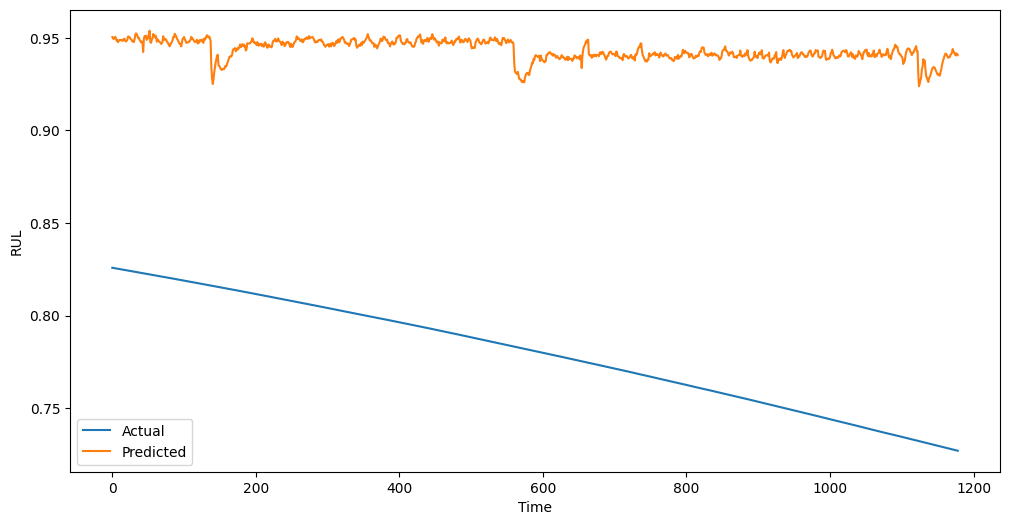

Epoch 1/20
233/233 - 4s - loss: 0.0607 - val_loss: 0.0102 - 4s/epoch - 17ms/step
Epoch 2/20
233/233 - 1s - loss: 0.0019 - val_loss: 0.0169 - 1s/epoch - 6ms/step
Epoch 3/20
233/233 - 2s - loss: 0.0015 - val_loss: 0.0173 - 2s/epoch - 7ms/step
Epoch 4/20
233/233 - 2s - loss: 0.0015 - val_loss: 0.0169 - 2s/epoch - 7ms/step
Epoch 5/20
233/233 - 2s - loss: 0.0014 - val_loss: 0.0139 - 2s/epoch - 7ms/step
Epoch 6/20
233/233 - 2s - loss: 0.0015 - val_loss: 0.0183 - 2s/epoch - 7ms/step
Epoch 7/20
233/233 - 1s - loss: 0.0015 - val_loss: 0.0155 - 1s/epoch - 6ms/step
Epoch 8/20
233/233 - 1s - loss: 0.0014 - val_loss: 0.0202 - 1s/epoch - 6ms/step
Epoch 9/20
233/233 - 1s - loss: 0.0015 - val_loss: 0.0172 - 1s/epoch - 6ms/step
Epoch 10/20
233/233 - 1s - loss: 0.0014 - val_loss: 0.0155 - 1s/epoch - 6ms/step
Epoch 11/20
233/233 - 1s - loss: 0.0014 - val_loss: 0.0174 - 1s/epoch - 6ms/step
Epoch 12/20
233/233 - 1s - loss: 0.0015 - val_loss: 0.0152 - 1s/epoch - 6ms/step
Epoch 13/20
233/233 - 1s - loss: 0.0

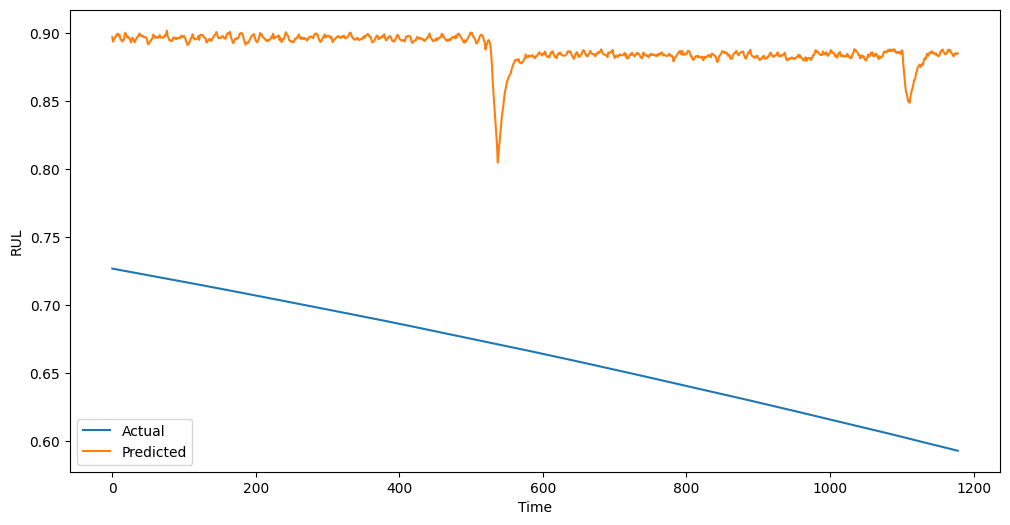

Epoch 1/20
266/266 - 5s - loss: 0.0272 - val_loss: 0.0310 - 5s/epoch - 20ms/step
Epoch 2/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0452 - 2s/epoch - 7ms/step
Epoch 3/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0415 - 2s/epoch - 6ms/step
Epoch 4/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0415 - 2s/epoch - 6ms/step
Epoch 5/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0427 - 2s/epoch - 6ms/step
Epoch 6/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0415 - 2s/epoch - 6ms/step
Epoch 7/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0444 - 2s/epoch - 7ms/step
Epoch 8/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0341 - 2s/epoch - 7ms/step
Epoch 9/20
266/266 - 2s - loss: 0.0033 - val_loss: 0.0371 - 2s/epoch - 7ms/step
Epoch 10/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0470 - 2s/epoch - 7ms/step
Epoch 11/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0399 - 2s/epoch - 7ms/step
Epoch 12/20
266/266 - 2s - loss: 0.0032 - val_loss: 0.0428 - 2s/epoch - 6ms/step
Epoch 13/20
266/266 - 2s - loss: 0.0

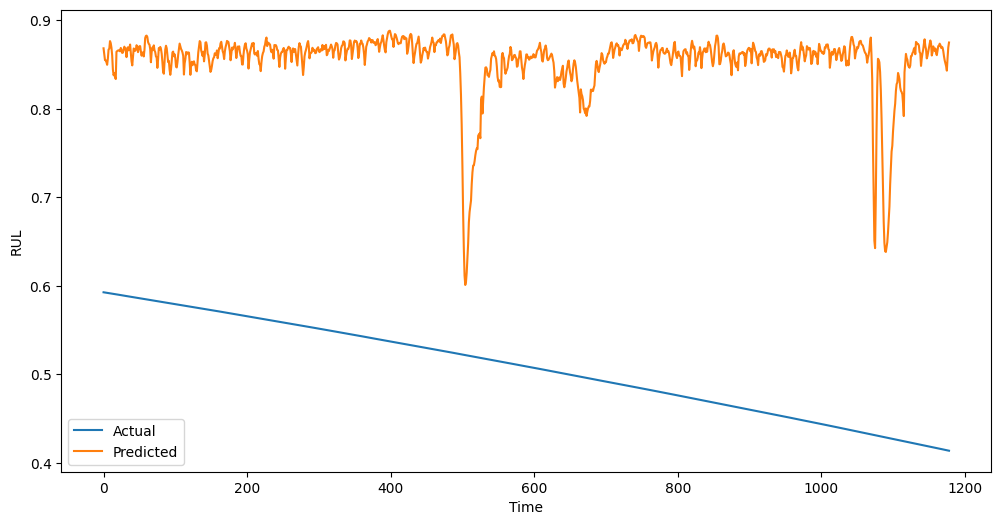

Epoch 1/20
299/299 - 5s - loss: 0.0408 - val_loss: 0.0829 - 5s/epoch - 15ms/step
Epoch 2/20
299/299 - 2s - loss: 0.0065 - val_loss: 0.0851 - 2s/epoch - 6ms/step
Epoch 3/20
299/299 - 2s - loss: 0.0064 - val_loss: 0.0778 - 2s/epoch - 6ms/step
Epoch 4/20
299/299 - 2s - loss: 0.0061 - val_loss: 0.0668 - 2s/epoch - 6ms/step
Epoch 5/20
299/299 - 2s - loss: 0.0052 - val_loss: 0.0393 - 2s/epoch - 7ms/step
Epoch 6/20
299/299 - 2s - loss: 0.0041 - val_loss: 0.0405 - 2s/epoch - 6ms/step
Epoch 7/20
299/299 - 2s - loss: 0.0034 - val_loss: 0.0376 - 2s/epoch - 7ms/step
Epoch 8/20
299/299 - 2s - loss: 0.0032 - val_loss: 0.0484 - 2s/epoch - 6ms/step
Epoch 9/20
299/299 - 2s - loss: 0.0030 - val_loss: 0.0396 - 2s/epoch - 6ms/step
Epoch 10/20
299/299 - 2s - loss: 0.0029 - val_loss: 0.0429 - 2s/epoch - 6ms/step
Epoch 11/20
299/299 - 2s - loss: 0.0022 - val_loss: 0.0300 - 2s/epoch - 7ms/step
Epoch 12/20
299/299 - 2s - loss: 0.0018 - val_loss: 0.0204 - 2s/epoch - 7ms/step
Epoch 13/20
299/299 - 2s - loss: 0.0

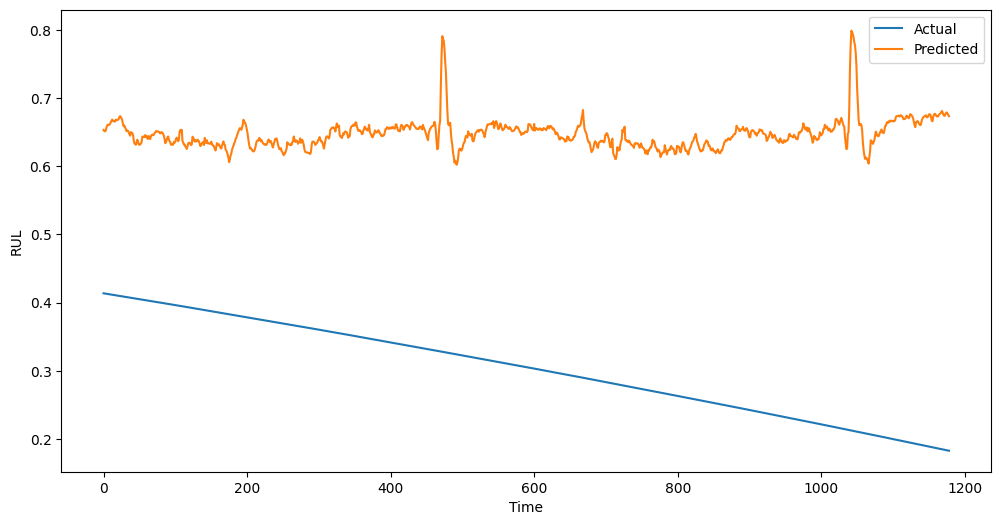

Epoch 1/20
332/332 - 5s - loss: 0.0250 - val_loss: 0.1625 - 5s/epoch - 14ms/step
Epoch 2/20
332/332 - 2s - loss: 0.0111 - val_loss: 0.1550 - 2s/epoch - 6ms/step
Epoch 3/20
332/332 - 2s - loss: 0.0070 - val_loss: 0.0873 - 2s/epoch - 6ms/step
Epoch 4/20
332/332 - 2s - loss: 0.0065 - val_loss: 0.1039 - 2s/epoch - 7ms/step
Epoch 5/20
332/332 - 2s - loss: 0.0065 - val_loss: 0.0956 - 2s/epoch - 6ms/step
Epoch 6/20
332/332 - 2s - loss: 0.0062 - val_loss: 0.1059 - 2s/epoch - 6ms/step
Epoch 7/20
332/332 - 2s - loss: 0.0041 - val_loss: 0.0866 - 2s/epoch - 6ms/step
Epoch 8/20
332/332 - 2s - loss: 0.0025 - val_loss: 0.0721 - 2s/epoch - 6ms/step
Epoch 9/20
332/332 - 2s - loss: 0.0023 - val_loss: 0.0550 - 2s/epoch - 6ms/step
Epoch 10/20
332/332 - 2s - loss: 0.0022 - val_loss: 0.0707 - 2s/epoch - 7ms/step
Epoch 11/20
332/332 - 2s - loss: 0.0023 - val_loss: 0.0855 - 2s/epoch - 6ms/step
Epoch 12/20
332/332 - 2s - loss: 0.0022 - val_loss: 0.0666 - 2s/epoch - 6ms/step
Epoch 13/20
332/332 - 2s - loss: 0.0

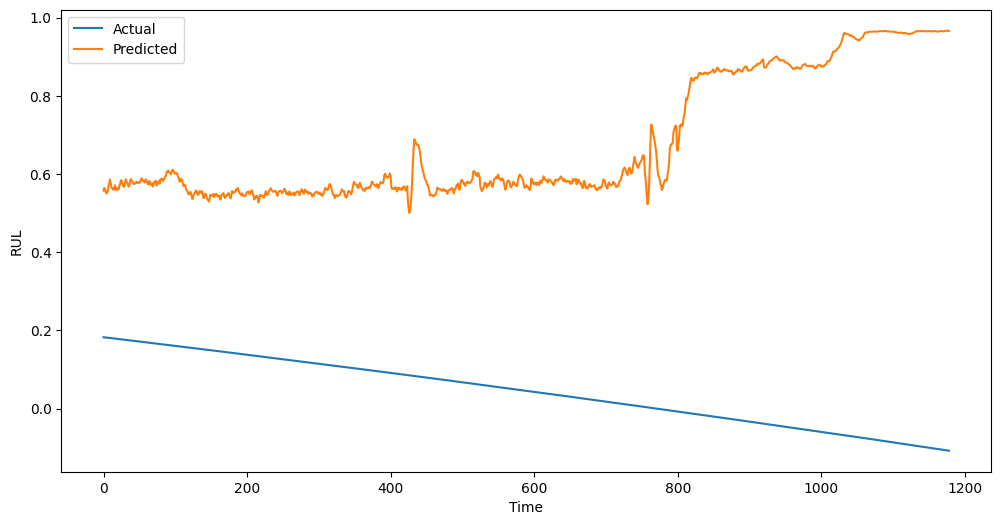

Average MSE across folds: 0.07905455695835462
All MSE Scores: [0.015451261574511333, 0.00018475466908620124, 0.0004003589668082861, 0.001724047069722521, 0.0063000200369310025, 0.02778562603877588, 0.05206405890016002, 0.1246827990140297, 0.12335439345076829, 0.438598249862753]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'data_filtered_every_20th' is your DataFrame with 'MotorTemperature' and 'Torque1Mean'

# Step 1: Prepare your data
# Extract the relevant columns and convert them to NumPy arrays
motor_temperature = data_filtered_every_20th['MotorTemperature'].values
torque1_mean = data_filtered_every_20th['Torque1Mean'].values
rul = data_filtered_every_20th['RUL'].values  # Target variable 'RUL'

# Normalize the data
scaler = MinMaxScaler()
motor_temperature = scaler.fit_transform(motor_temperature.reshape(-1, 1))
torque1_mean = scaler.fit_transform(torque1_mean.reshape(-1, 1))

# Combine the features into one array
X = np.column_stack((motor_temperature, torque1_mean))

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X_seq, y = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i + sequence_length])
    y.append(rul[i + sequence_length])

X_seq = np.array(X_seq)
y = np.array(y)

# Split the data using TimeSeriesSplit with 10% for testing
tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits

# Initialize lists to store metrics for each fold (e.g., MSE)
mse_scores = []

# Iterate through the splits
for train_index, test_index in tscv.split(X_seq):
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training data further into training and validation (90% for training, 10% for validation)
    val_size = int(0.1 * len(X_train))
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]

    # Create and train your LSTM model for this fold
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, 2)))  # Input shape is (sequence_length, 2) for two features
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

    # Evaluate the model on the test data and calculate MSE
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    mse_scores.append(mse)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()

# Calculate and report the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f'Average MSE across folds: {average_mse}')

# Print all values in mse_scores
print("All MSE Scores:", mse_scores)


In [ ]:
data_filtered_every_20th.columns

Index(['MotorTemperature', 'TimeLength', 'PositionInit', 'PositionLength',
       'Speed1Mean', 'Speed1Std', 'Speed1Min', 'Speed1Q1', 'Speed1Q2',
       'Speed1Q3', 'Speed1Max', 'Torque1Mean', 'Torque1Std', 'Torque1Min',
       'Torque1Q1', 'Torque1Q2', 'Torque1Q3', 'Torque1Max', 'RUL',
       'Process_BF1', 'Process_BF2', 'Process_BF3', 'Process_BF4',
       'Process_BF5', 'Process_BF6', 'CurveProcess_acceleration',
       'CurveProcess_decceleration', 'CurveProcess_top'],
      dtype='object')

## Predict RUL using all columns

Epoch 1/20
34/34 - 3s - loss: 0.1135 - val_loss: 0.0036 - 3s/epoch - 83ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0016 - val_loss: 2.4127e-04 - 288ms/epoch - 8ms/step
Epoch 3/20
34/34 - 0s - loss: 4.4928e-04 - val_loss: 2.8377e-04 - 264ms/epoch - 8ms/step
Epoch 4/20
34/34 - 0s - loss: 4.0147e-04 - val_loss: 2.3225e-04 - 260ms/epoch - 8ms/step
Epoch 5/20
34/34 - 0s - loss: 3.6966e-04 - val_loss: 2.1489e-04 - 267ms/epoch - 8ms/step
Epoch 6/20
34/34 - 0s - loss: 3.5010e-04 - val_loss: 2.0831e-04 - 270ms/epoch - 8ms/step
Epoch 7/20
34/34 - 0s - loss: 3.3770e-04 - val_loss: 2.1280e-04 - 258ms/epoch - 8ms/step
Epoch 8/20
34/34 - 0s - loss: 3.1354e-04 - val_loss: 1.9203e-04 - 256ms/epoch - 8ms/step
Epoch 9/20
34/34 - 0s - loss: 2.9966e-04 - val_loss: 1.8961e-04 - 262ms/epoch - 8ms/step
Epoch 10/20
34/34 - 0s - loss: 2.7514e-04 - val_loss: 2.0174e-04 - 257ms/epoch - 8ms/step
Epoch 11/20
34/34 - 0s - loss: 2.6077e-04 - val_loss: 1.7037e-04 - 263ms/epoch - 8ms/step
Epoch 12/20
34/34 - 0s - loss: 2.

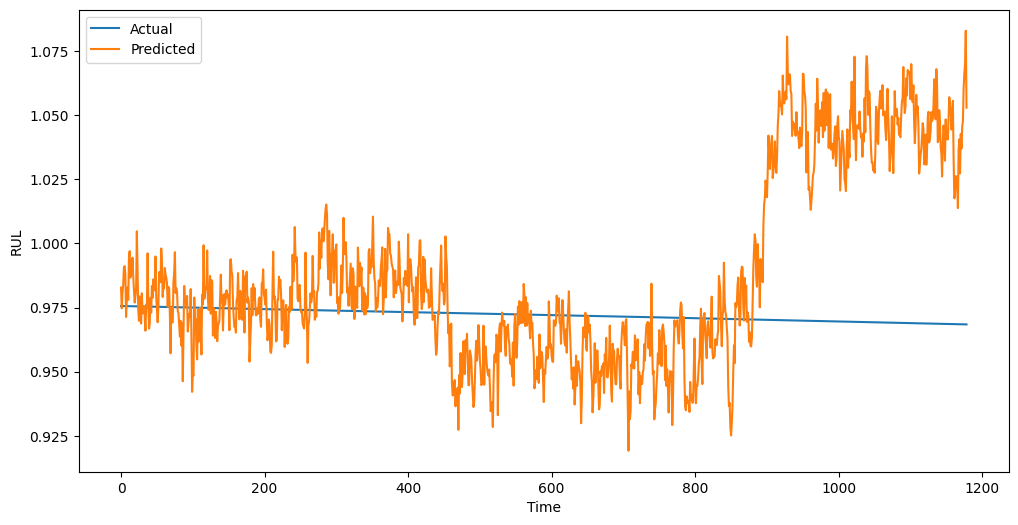

Epoch 1/20
67/67 - 4s - loss: 0.0739 - val_loss: 0.0050 - 4s/epoch - 61ms/step
Epoch 2/20
67/67 - 0s - loss: 0.0024 - val_loss: 5.0264e-04 - 475ms/epoch - 7ms/step
Epoch 3/20
67/67 - 0s - loss: 8.8461e-04 - val_loss: 7.4514e-04 - 454ms/epoch - 7ms/step
Epoch 4/20
67/67 - 0s - loss: 4.3080e-04 - val_loss: 0.0016 - 474ms/epoch - 7ms/step
Epoch 5/20
67/67 - 0s - loss: 3.1870e-04 - val_loss: 0.0013 - 471ms/epoch - 7ms/step
Epoch 6/20
67/67 - 0s - loss: 2.5992e-04 - val_loss: 7.2479e-04 - 483ms/epoch - 7ms/step
Epoch 7/20
67/67 - 0s - loss: 2.0975e-04 - val_loss: 3.1114e-04 - 465ms/epoch - 7ms/step
Epoch 8/20
67/67 - 0s - loss: 1.6992e-04 - val_loss: 1.7350e-04 - 465ms/epoch - 7ms/step
Epoch 9/20
67/67 - 0s - loss: 1.4206e-04 - val_loss: 8.6098e-05 - 464ms/epoch - 7ms/step
Epoch 10/20
67/67 - 0s - loss: 1.1619e-04 - val_loss: 7.8661e-05 - 447ms/epoch - 7ms/step
Epoch 11/20
67/67 - 0s - loss: 9.6256e-05 - val_loss: 9.9809e-05 - 472ms/epoch - 7ms/step
Epoch 12/20
67/67 - 0s - loss: 8.4943e-05

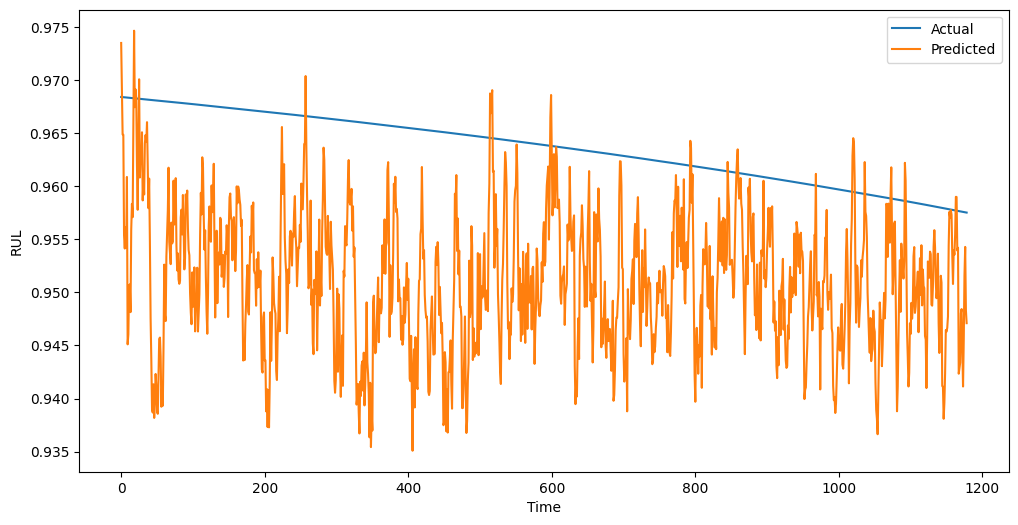

Epoch 1/20
100/100 - 3s - loss: 0.0450 - val_loss: 0.0018 - 3s/epoch - 34ms/step
Epoch 2/20
100/100 - 1s - loss: 8.4714e-04 - val_loss: 3.1126e-04 - 729ms/epoch - 7ms/step
Epoch 3/20
100/100 - 1s - loss: 4.4746e-04 - val_loss: 2.2583e-04 - 791ms/epoch - 8ms/step
Epoch 4/20
100/100 - 1s - loss: 3.5769e-04 - val_loss: 1.5590e-04 - 702ms/epoch - 7ms/step
Epoch 5/20
100/100 - 1s - loss: 2.8041e-04 - val_loss: 1.1021e-04 - 693ms/epoch - 7ms/step
Epoch 6/20
100/100 - 1s - loss: 2.2914e-04 - val_loss: 9.8201e-05 - 771ms/epoch - 8ms/step
Epoch 7/20
100/100 - 1s - loss: 1.8937e-04 - val_loss: 8.2927e-05 - 689ms/epoch - 7ms/step
Epoch 8/20
100/100 - 1s - loss: 1.5235e-04 - val_loss: 7.8320e-05 - 715ms/epoch - 7ms/step
Epoch 9/20
100/100 - 1s - loss: 1.2627e-04 - val_loss: 7.0958e-05 - 756ms/epoch - 8ms/step
Epoch 10/20
100/100 - 1s - loss: 1.0440e-04 - val_loss: 1.1215e-04 - 722ms/epoch - 7ms/step
Epoch 11/20
100/100 - 1s - loss: 9.0092e-05 - val_loss: 6.0512e-05 - 708ms/epoch - 7ms/step
Epoch 1

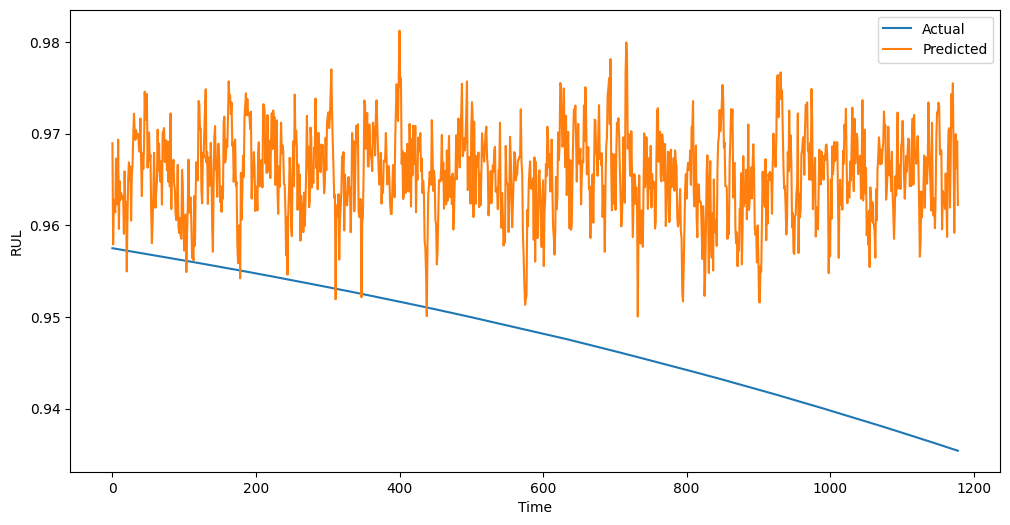

Epoch 1/20
133/133 - 4s - loss: 0.0023 - val_loss: 3.4298e-04 - 4s/epoch - 27ms/step
Epoch 2/20
133/133 - 1s - loss: 2.1434e-04 - val_loss: 6.3732e-04 - 974ms/epoch - 7ms/step
Epoch 3/20
133/133 - 1s - loss: 1.2831e-04 - val_loss: 5.1682e-04 - 973ms/epoch - 7ms/step
Epoch 4/20
133/133 - 1s - loss: 9.7887e-05 - val_loss: 3.7299e-04 - 990ms/epoch - 7ms/step
Epoch 5/20
133/133 - 1s - loss: 8.1458e-05 - val_loss: 6.9474e-04 - 911ms/epoch - 7ms/step
Epoch 6/20
133/133 - 1s - loss: 7.0635e-05 - val_loss: 5.6348e-04 - 904ms/epoch - 7ms/step
Epoch 7/20
133/133 - 1s - loss: 5.2100e-05 - val_loss: 5.1019e-04 - 930ms/epoch - 7ms/step
Epoch 8/20
133/133 - 1s - loss: 4.9604e-05 - val_loss: 3.0914e-04 - 926ms/epoch - 7ms/step
Epoch 9/20
133/133 - 1s - loss: 4.7812e-05 - val_loss: 2.1603e-04 - 951ms/epoch - 7ms/step
Epoch 10/20
133/133 - 1s - loss: 4.0187e-05 - val_loss: 9.6761e-04 - 904ms/epoch - 7ms/step
Epoch 11/20
133/133 - 1s - loss: 3.6395e-05 - val_loss: 5.7477e-04 - 944ms/epoch - 7ms/step
Epo

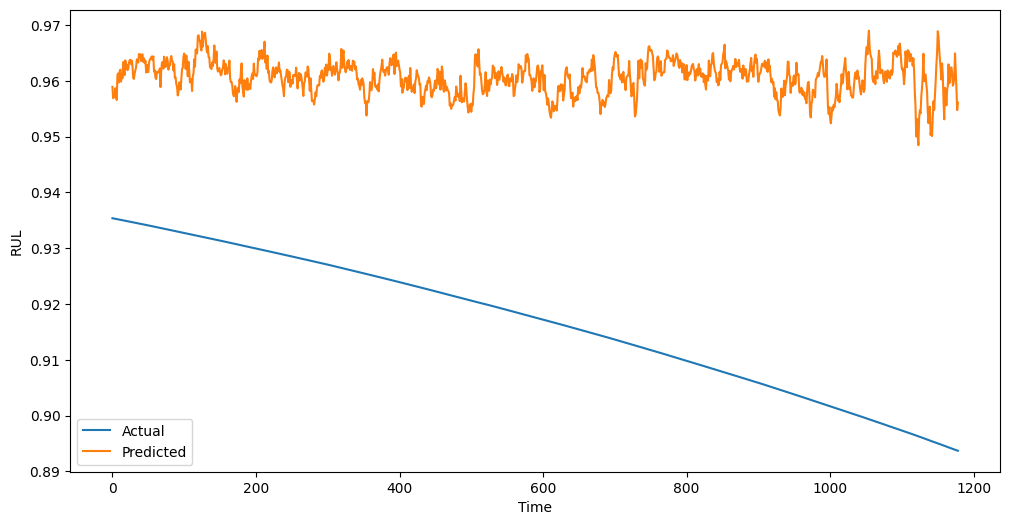

Epoch 1/20
166/166 - 4s - loss: 0.0146 - val_loss: 0.0021 - 4s/epoch - 24ms/step
Epoch 2/20
166/166 - 1s - loss: 6.7501e-04 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 3/20
166/166 - 1s - loss: 3.5210e-04 - val_loss: 0.0013 - 1s/epoch - 8ms/step
Epoch 4/20
166/166 - 1s - loss: 2.4794e-04 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 5/20
166/166 - 1s - loss: 1.9965e-04 - val_loss: 0.0014 - 1s/epoch - 7ms/step
Epoch 6/20
166/166 - 1s - loss: 1.7122e-04 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 7/20
166/166 - 1s - loss: 1.5210e-04 - val_loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 8/20
166/166 - 1s - loss: 1.3732e-04 - val_loss: 0.0012 - 1s/epoch - 7ms/step
Epoch 9/20
166/166 - 1s - loss: 1.2956e-04 - val_loss: 0.0011 - 1s/epoch - 7ms/step
Epoch 10/20
166/166 - 1s - loss: 1.2247e-04 - val_loss: 0.0015 - 1s/epoch - 7ms/step
Epoch 11/20
166/166 - 1s - loss: 1.2235e-04 - val_loss: 0.0011 - 1s/epoch - 7ms/step
Epoch 12/20
166/166 - 1s - loss: 1.1927e-04 - val_loss: 7.6631e-04 - 1s/epoch

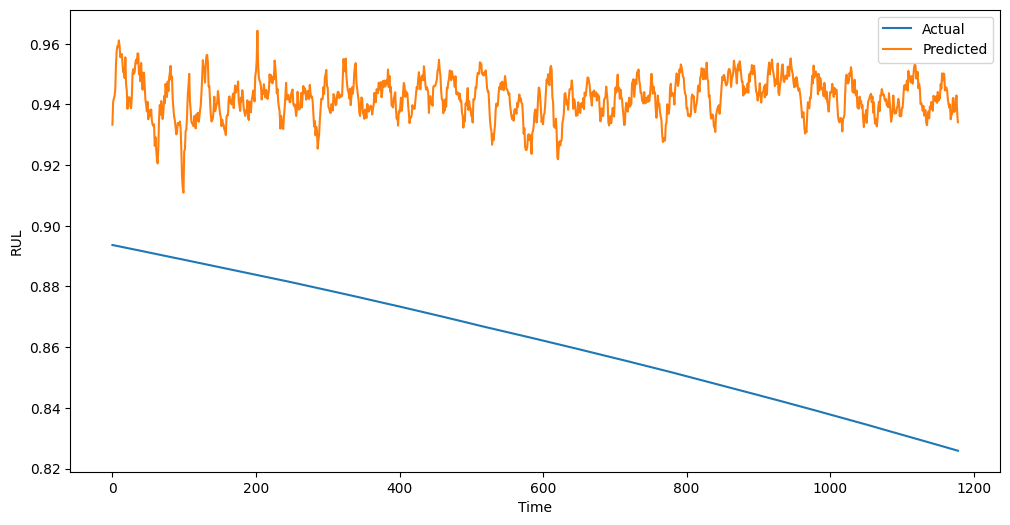

Epoch 1/20
200/200 - 5s - loss: 0.0106 - val_loss: 0.0057 - 5s/epoch - 25ms/step
Epoch 2/20
200/200 - 1s - loss: 7.7425e-04 - val_loss: 0.0041 - 1s/epoch - 7ms/step
Epoch 3/20
200/200 - 1s - loss: 5.4765e-04 - val_loss: 0.0046 - 1s/epoch - 7ms/step
Epoch 4/20
200/200 - 1s - loss: 4.2610e-04 - val_loss: 0.0051 - 1s/epoch - 7ms/step
Epoch 5/20
200/200 - 1s - loss: 3.7186e-04 - val_loss: 0.0051 - 1s/epoch - 7ms/step
Epoch 6/20
200/200 - 1s - loss: 3.2821e-04 - val_loss: 0.0022 - 1s/epoch - 7ms/step
Epoch 7/20
200/200 - 1s - loss: 3.3071e-04 - val_loss: 0.0027 - 1s/epoch - 7ms/step
Epoch 8/20
200/200 - 1s - loss: 3.1572e-04 - val_loss: 0.0038 - 1s/epoch - 7ms/step
Epoch 9/20
200/200 - 1s - loss: 3.3633e-04 - val_loss: 0.0044 - 1s/epoch - 7ms/step
Epoch 10/20
200/200 - 1s - loss: 2.8575e-04 - val_loss: 0.0034 - 1s/epoch - 7ms/step
Epoch 11/20
200/200 - 1s - loss: 2.6917e-04 - val_loss: 0.0029 - 1s/epoch - 6ms/step
Epoch 12/20
200/200 - 1s - loss: 2.7136e-04 - val_loss: 0.0031 - 1s/epoch - 7

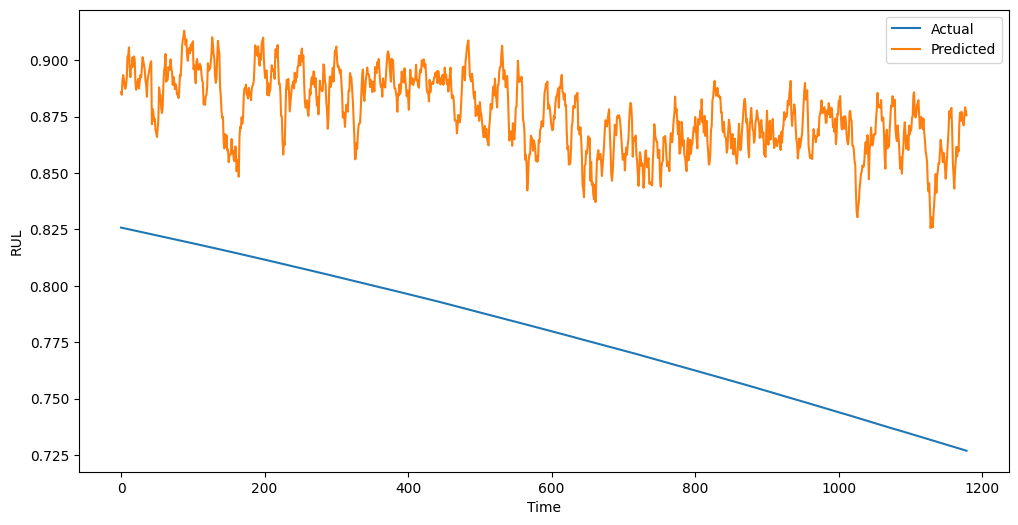

Epoch 1/20
233/233 - 4s - loss: 0.0102 - val_loss: 0.0150 - 4s/epoch - 18ms/step
Epoch 2/20
233/233 - 2s - loss: 0.0010 - val_loss: 0.0131 - 2s/epoch - 7ms/step
Epoch 3/20
233/233 - 2s - loss: 7.2251e-04 - val_loss: 0.0086 - 2s/epoch - 7ms/step
Epoch 4/20
233/233 - 2s - loss: 5.8002e-04 - val_loss: 0.0065 - 2s/epoch - 7ms/step
Epoch 5/20
233/233 - 2s - loss: 4.8253e-04 - val_loss: 0.0067 - 2s/epoch - 7ms/step
Epoch 6/20
233/233 - 2s - loss: 4.4608e-04 - val_loss: 0.0062 - 2s/epoch - 7ms/step
Epoch 7/20
233/233 - 2s - loss: 4.4107e-04 - val_loss: 0.0043 - 2s/epoch - 7ms/step
Epoch 8/20
233/233 - 2s - loss: 3.9933e-04 - val_loss: 0.0034 - 2s/epoch - 8ms/step
Epoch 9/20
233/233 - 2s - loss: 3.9939e-04 - val_loss: 0.0061 - 2s/epoch - 7ms/step
Epoch 10/20
233/233 - 2s - loss: 3.7269e-04 - val_loss: 0.0053 - 2s/epoch - 7ms/step
Epoch 11/20
233/233 - 2s - loss: 3.6706e-04 - val_loss: 0.0038 - 2s/epoch - 7ms/step
Epoch 12/20
233/233 - 2s - loss: 3.5465e-04 - val_loss: 0.0060 - 2s/epoch - 7ms/s

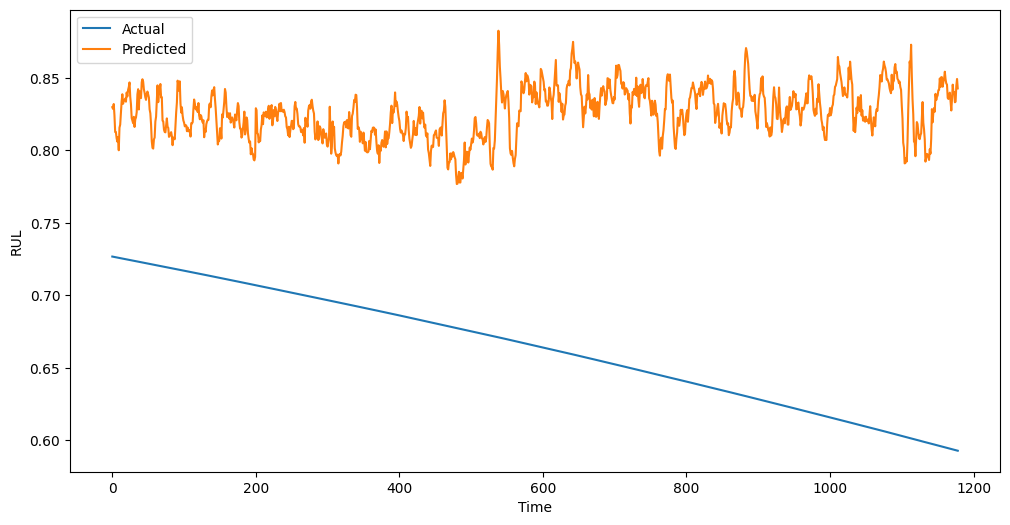

Epoch 1/20
266/266 - 5s - loss: 0.0136 - val_loss: 0.0460 - 5s/epoch - 17ms/step
Epoch 2/20
266/266 - 2s - loss: 0.0021 - val_loss: 0.0295 - 2s/epoch - 7ms/step
Epoch 3/20
266/266 - 2s - loss: 0.0013 - val_loss: 0.0218 - 2s/epoch - 7ms/step
Epoch 4/20
266/266 - 2s - loss: 0.0012 - val_loss: 0.0206 - 2s/epoch - 7ms/step
Epoch 5/20
266/266 - 2s - loss: 0.0011 - val_loss: 0.0246 - 2s/epoch - 7ms/step
Epoch 6/20
266/266 - 2s - loss: 9.6785e-04 - val_loss: 0.0248 - 2s/epoch - 7ms/step
Epoch 7/20
266/266 - 2s - loss: 9.1908e-04 - val_loss: 0.0251 - 2s/epoch - 7ms/step
Epoch 8/20
266/266 - 2s - loss: 8.8312e-04 - val_loss: 0.0257 - 2s/epoch - 7ms/step
Epoch 9/20
266/266 - 2s - loss: 8.2539e-04 - val_loss: 0.0219 - 2s/epoch - 7ms/step
Epoch 10/20
266/266 - 2s - loss: 7.9680e-04 - val_loss: 0.0154 - 2s/epoch - 7ms/step
Epoch 11/20
266/266 - 2s - loss: 7.9316e-04 - val_loss: 0.0196 - 2s/epoch - 7ms/step
Epoch 12/20
266/266 - 2s - loss: 7.9453e-04 - val_loss: 0.0191 - 2s/epoch - 7ms/step
Epoch 13

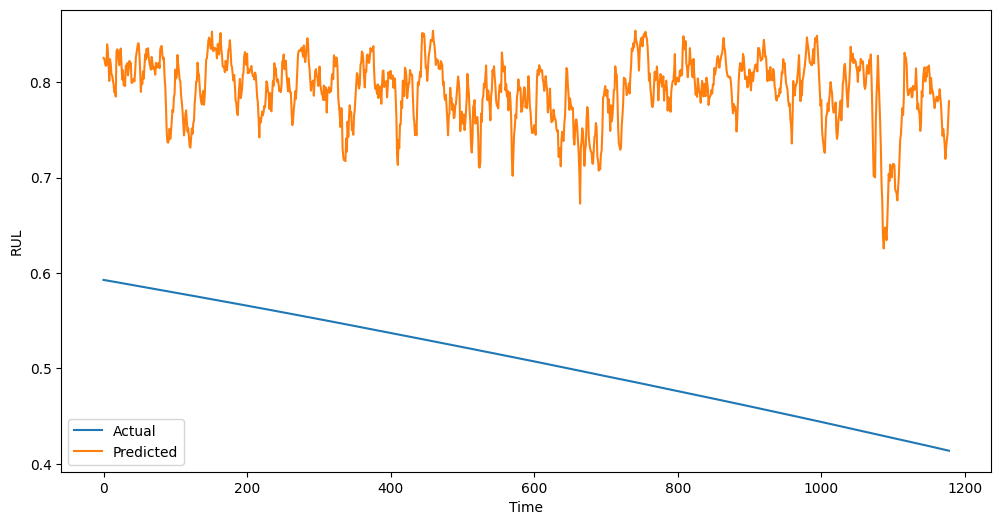

Epoch 1/20
299/299 - 5s - loss: 0.0192 - val_loss: 0.0696 - 5s/epoch - 15ms/step
Epoch 2/20
299/299 - 2s - loss: 0.0034 - val_loss: 0.0433 - 2s/epoch - 7ms/step
Epoch 3/20
299/299 - 2s - loss: 0.0023 - val_loss: 0.0576 - 2s/epoch - 7ms/step
Epoch 4/20
299/299 - 2s - loss: 0.0018 - val_loss: 0.0284 - 2s/epoch - 7ms/step
Epoch 5/20
299/299 - 2s - loss: 0.0014 - val_loss: 0.0222 - 2s/epoch - 6ms/step
Epoch 6/20
299/299 - 2s - loss: 0.0013 - val_loss: 0.0243 - 2s/epoch - 7ms/step
Epoch 7/20
299/299 - 2s - loss: 0.0012 - val_loss: 0.0266 - 2s/epoch - 7ms/step
Epoch 8/20
299/299 - 2s - loss: 0.0011 - val_loss: 0.0218 - 2s/epoch - 7ms/step
Epoch 9/20
299/299 - 2s - loss: 0.0012 - val_loss: 0.0195 - 2s/epoch - 7ms/step
Epoch 10/20
299/299 - 2s - loss: 0.0010 - val_loss: 0.0178 - 2s/epoch - 7ms/step
Epoch 11/20
299/299 - 2s - loss: 0.0011 - val_loss: 0.0266 - 2s/epoch - 6ms/step
Epoch 12/20
299/299 - 2s - loss: 9.6616e-04 - val_loss: 0.0356 - 2s/epoch - 7ms/step
Epoch 13/20
299/299 - 2s - loss:

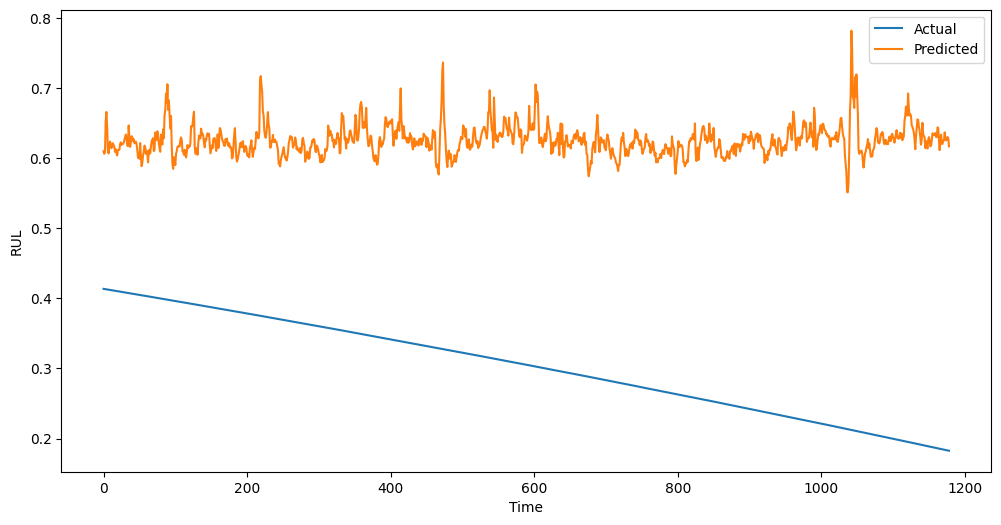

Epoch 1/20
332/332 - 6s - loss: 0.0187 - val_loss: 0.1345 - 6s/epoch - 17ms/step
Epoch 2/20
332/332 - 2s - loss: 0.0039 - val_loss: 0.0661 - 2s/epoch - 7ms/step
Epoch 3/20
332/332 - 2s - loss: 0.0029 - val_loss: 0.0506 - 2s/epoch - 7ms/step
Epoch 4/20
332/332 - 2s - loss: 0.0025 - val_loss: 0.0743 - 2s/epoch - 7ms/step
Epoch 5/20
332/332 - 2s - loss: 0.0022 - val_loss: 0.0545 - 2s/epoch - 6ms/step
Epoch 6/20
332/332 - 2s - loss: 0.0021 - val_loss: 0.0497 - 2s/epoch - 7ms/step
Epoch 7/20
332/332 - 2s - loss: 0.0019 - val_loss: 0.0620 - 2s/epoch - 6ms/step
Epoch 8/20
332/332 - 2s - loss: 0.0018 - val_loss: 0.0495 - 2s/epoch - 7ms/step
Epoch 9/20
332/332 - 2s - loss: 0.0016 - val_loss: 0.0576 - 2s/epoch - 7ms/step
Epoch 10/20
332/332 - 2s - loss: 0.0017 - val_loss: 0.0498 - 2s/epoch - 7ms/step
Epoch 11/20
332/332 - 2s - loss: 0.0015 - val_loss: 0.0455 - 2s/epoch - 7ms/step
Epoch 12/20
332/332 - 2s - loss: 0.0014 - val_loss: 0.0484 - 2s/epoch - 6ms/step
Epoch 13/20
332/332 - 2s - loss: 0.0

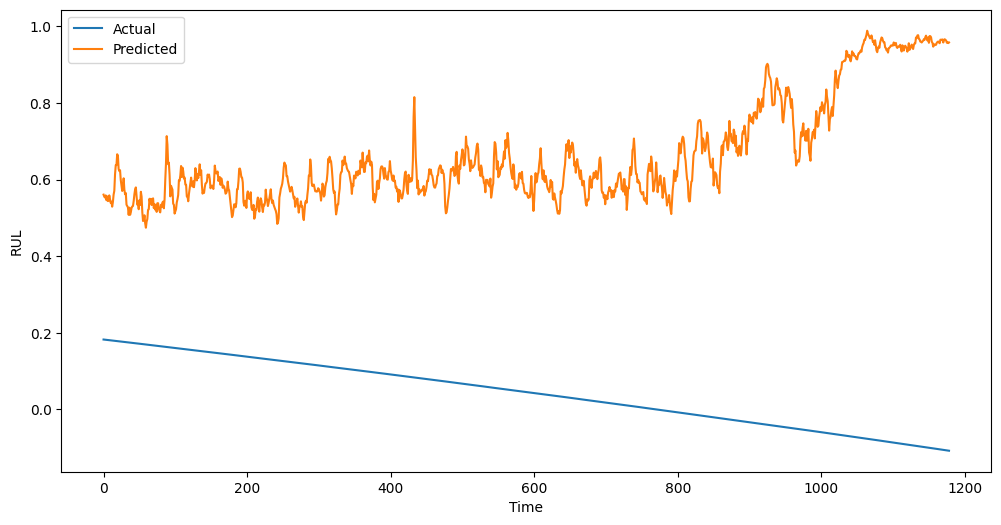

Average MSE across folds: 0.06535549143014699
All MSE Scores: [0.0015455905134765212, 0.000205630830952246, 0.00038045505517346327, 0.0020961611673146357, 0.006896384635795043, 0.010515685831171061, 0.0282092303298979, 0.08460829045058754, 0.10897066006531285, 0.41012682542178863]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'data_filtered_every_20th' is your DataFrame with all relevant columns

# Step 1: Prepare your data
# Extract the relevant columns and convert them to NumPy arrays
data2 = data_filtered_every_20th.copy()  # Make a copy of the original DataFrame

# Select columns for X (all columns except 'RUL')
X_columns = data2.columns.difference(['RUL'])
X = data2[X_columns].values

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Target variable 'RUL'
y = data2['RUL'].values

# Create sequences of data for input and output (e.g., use a sequence length of 10)
sequence_length = 10
X_seq, y_seq = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i + sequence_length])
    y_seq.append(y[i + sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split the data using TimeSeriesSplit with 10% for testing
tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits

# Initialize lists to store metrics for each fold (e.g., MSE)
mse_scores = []

# Iterate through the splits
for train_index, test_index in tscv.split(X_seq):
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # Split the training data further into training and validation (90% for training, 10% for validation)
    val_size = int(0.1 * len(X_train))
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]

    # Create and train your LSTM model for this fold
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, X_seq.shape[2])))  # Input shape adjusted for all columns
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

    # Evaluate the model on the test data and calculate MSE
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred) ** 2)
    mse_scores.append(mse)

    # Plot actual vs. predicted values for this fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()

# Calculate and report the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f'Average MSE across folds: {average_mse}')

# Print all values in mse_scores
print("All MSE Scores:", mse_scores)


### Normalization

In [ ]:
backupData2 = data

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming 'data' is your DataFrame with numerical and one-hot encoded columns

# Extract the numerical columns (excluding one-hot encoded)
numerical_columns = ['MotorTemperature', 'TimeLength', 'PositionInit', 'PositionLength',
       'Speed1Mean', 'Speed1Std', 'Speed1Min', 'Speed1Q1', 'Speed1Q2',
       'Speed1Q3', 'Speed1Max', 'Torque1Mean', 'Torque1Std', 'Torque1Min',
       'Torque1Q1', 'Torque1Q2', 'Torque1Q3', 'Torque1Max']
numerical_data = data[numerical_columns]

# Extract the one-hot encoded columns
categorical_columns = [col for col in data.columns if col not in numerical_columns]

# Normalize the numerical data using StandardScaler
scaler = StandardScaler()
normalized_numerical_data = pd.DataFrame(scaler.fit_transform(numerical_data), columns=numerical_columns)

# Combine the normalized numerical data with the one-hot encoded data
normalized_data = pd.concat([normalized_numerical_data, data[categorical_columns]], axis=1)

# Now, 'normalized_data' contains the normalized numerical features and the one-hot encoded features
normalized_data.head()

MotorTemperature  TimeLength  PositionInit  PositionLength  Speed1Mean  \
0         -4.081674   -0.380985     -0.679458       -0.334674    1.019832   
1         -4.081674   -0.306061      0.049312       -0.865973    1.019832   
2         -4.081674   -0.558078      0.318898       -0.317836   -0.684036   
3         -4.081674    2.547861     -0.723609        2.426356    0.593940   
4         -4.081674   -0.558078      1.544786       -0.317710   -0.683387   

   Speed1Std  Speed1Min  Speed1Q1  Speed1Q2  Speed1Q3  ...       RUL  \
0  -0.647091   1.000981  1.013501  1.022658  0.853818  ...  0.986150   
1  -0.647091   1.000981  1.013501  1.022658  0.853818  ...  0.986150   
2   1.725121  -1.213943 -1.127236 -0.724860  0.093739  ...  0.986149   
3  -0.650502   0.687581  0.687569  0.607309  0.358622  ...  0.986149   
4   1.723278  -1.213943 -1.130412 -0.721115  0.082797  ...  0.986149   

   Process_BF1  Process_BF2  Process_BF3  Process_BF4  Process_BF5  \
0            0            0            0            1            0   
1            0            0            0            1            0   
2            0            0            0            1            0   
3            0            0            0            0            1   
4            0            0            0            0            0   

   Process_BF6  CurveProcess_acceleration CurveProcess_decceleration  \
0            0                          0                          1   
1            0                          0                          0   
2            0                          1                          0   
3            0                          0                          0   
4            1                          1                          0   

   CurveProcess_top  
0                 0  
1                 1  
2                 0  
3                 1  
4                 0  

[5 rows x 29 columns]

## Timeseries Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 3)
normalized_data = normalized_data.sort_values('Datetime')
normalized_data.reset_index(drop=True, inplace=True)
#normalized_data.set_index('Datetime', inplace=True)
#normalized_data.sort_index(inplace=True)
X = normalized_data.drop(labels=['RUL'], axis=1)
y = normalized_data['RUL']

In [ ]:
#Default 75% training 25% testing
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
print ("Train Data is between: ", X_train['Datetime'].min(), " and: ", X_train['Datetime'].max(), ' and N rows: ', X_train.shape[0])
print ("Test Data is between: ", X_test['Datetime'].min(), " and: ", X_test['Datetime'].max(), ' and N rows: ', X_test.shape[0])

Train Data is between:  2023-03-17 09:49:57  and:  2023-04-07 02:03:43  and N rows:  3493764
Test Data is between:  2023-04-07 02:03:43  and:  2023-04-13 02:03:55  and N rows:  1164588


In [ ]:
X_train.head()

MotorTemperature  TimeLength  PositionInit  PositionLength  Speed1Mean  \
0         -4.081674   -0.380985     -0.679458       -0.334674    1.019832   
1         -4.081674   -0.306061      0.049312       -0.865973    1.019832   
2         -4.081674   -0.558078      0.318898       -0.317836   -0.684036   
3         -4.081674   -0.558078     -0.959540        0.276840   -0.857075   
4         -4.081674   -0.367362      0.597254       -0.331584    1.020655   

   Speed1Std  Speed1Min  Speed1Q1  Speed1Q2  Speed1Q3  ...  \
0  -0.647091   1.000981  1.013501  1.022658  0.853818  ...   
1  -0.647091   1.000981  1.013501  1.022658  0.853818  ...   
2   1.725121  -1.213943 -1.127236 -0.724860  0.093739  ...   
3   1.417812  -1.213943 -1.166319 -0.884638 -0.265291  ...   
4  -0.647078   1.000194  1.013049  1.023769  0.856203  ...   

             Datetime  Process_BF1  Process_BF2  Process_BF3  Process_BF4  \
0 2023-03-17 09:49:57            0            0            0            1   
1 2023-03-17 09:49:57            0            0            0            1   
2 2023-03-17 09:49:57            0            0            0            1   
3 2023-03-17 09:49:58            0            0            0            0   
4 2023-03-17 09:49:58            0            0            0            0   

   Process_BF5  Process_BF6  CurveProcess_acceleration  \
0            0            0                          0   
1            0            0                          0   
2            0            0                          1   
3            1            0                          1   
4            0            1                          0   

  CurveProcess_decceleration  CurveProcess_top  
0                          1                 0  
1                          0                 1  
2                          0                 0  
3                          0                 0  
4                          1                 0  

[5 rows x 28 columns]

In [ ]:
from scipy.stats import randint as sp_randint
param_dist = {"n_estimators": [2, 4, 8, 16, 32, 64], # Number of trees in random forest
              "max_features": [1.0], # Auto, Number of features to consider at every split
              "max_depth": [None, 2, 4, 8, 16], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["absolute_error"]}

In [ ]:
import os

# Create the "DataModeling" folder if it doesn't exist
folder_name = "DataModeling"
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

# Assuming you have X_train, X_test, y_train, and y_test DataFrames

# Define file paths within the "DataModeling" folder for saving
X_train.to_csv(os.path.join(folder_name, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(folder_name, 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(folder_name, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(folder_name, 'y_test.csv'), index=False)

In [ ]:
#Define file paths for saving
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [ ]:
X_train['RUL']=y_train

<ipython-input-38-257c3ea895ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['RUL']=y_train


In [ ]:
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5) #Window cross-validation for time series

regressor = RandomForestRegressor()

# Initialize the RandomizedSearchCV with time series split
rnd_regres = RandomizedSearchCV(estimator=regressor, param_distributions=param_dist, n_iter=10, cv=tscv, random_state=42, n_jobs=1, verbose=1)

# Fit the random search model
rnd_regres.fit(X=X_train.drop(['RUL', 'Datetime'], axis=1), y=X_train['RUL'])
#rnd_regres.fit(X=sj_train_scaled.drop(['total_cases'], axis=1), y=sj_train_scaled['total_cases'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(rnd_regres.cv_results_, 5)